# Imports

In [1]:
!which jupyter
import numpy as np
import pandas as pd
from pprint import pprint
from tqdm import tqdm
import re
from scipy.stats import mode as mode
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
pd.set_option('display.max_columns', 100)

/home/ubuntu/thesis_env2/bin/jupyter


In [2]:
# NER File
df_ner = pd.read_pickle('./data/df_ner_matched_210913.pickle')
print(len(df_ner))

# Sentiment Analysis
df_sent = pd.read_pickle('./data/df_sentiment.pickle')
df_sent['finbert'] = df_sent['finbert'].str.upper()

# measure of if all sentiment agree
sentiment_match = np.array(df_sent[['finbert', 'distilbert', 'roberta']])
sentiment_match = np.all(np.equal(sentiment_match, sentiment_match[:,:1]), axis=1)
df_sent['sentiment_match'] = sentiment_match

# most common sentiment
df_sent['sentiment'] = df_sent.apply(lambda x: mode([x['distilbert'], x['finbert'], x['roberta']])[0][0], axis=1)
print(len(df_sent))

# Topics
df_topics = pd.read_pickle("./data/df_with_topics")
df_topics['topic_label_str'] = ['_'.join(map(str, l)) for l in df_topics['topic_label']]
print(len(df_topics))

# Topics - manual defined topics
df_topics_manual = pd.read_pickle('df_doc_embeddings_word_additional.pickle')
print(len(df_topics_manual))

369045
365200
365200
365200


In [3]:
df_ner.head(1)

author       date      domain  \
0  Thomas Hughes 2020-01-02  marketbeat   

                                            title  \
0  Three Industrial Giants You Should Own In 2020   

                                                 url  \
0  https://www.marketbeat.com/originals/three-ind...   

                                             content topic_area  \
0  With the end of the year just around the corne...   business   

                                           org_names  \
0  [BA, Boeing, CAT, CMI, Caterpillar, Cummins In...   

                                      filtered_names  \
0  [Boeing, Caterpillar, Cummins Inc, Deere & Com...   

                                filtered_names_match  \
0  [Caterpillar Inc., Cummins Inc., Deere & Compa...   

  filtered_names_titles_match  
0                          []

In [4]:
df_sent.head(1)

author       date      domain  \
0  Thomas Hughes 2020-01-02  marketbeat   

                                            title  \
0  Three Industrial Giants You Should Own In 2020   

                                                 url  \
0  https://www.marketbeat.com/originals/three-ind...   

                                             content topic_area  \
0  With the end of the year just around the corne...   business   

                                   content_processed distilbert  finbert  \
0  end year corner past time think positioning fo...   POSITIVE  NEUTRAL   

    roberta  sentiment_match sentiment  
0  POSITIVE            False  POSITIVE

In [5]:
df_topics.head(1)

author       date      domain  \
0  Thomas Hughes 2020-01-02  marketbeat   

                                            title  \
0  Three Industrial Giants You Should Own In 2020   

                                                 url  \
0  https://www.marketbeat.com/originals/three-ind...   

                                             content topic_area  \
0  With the end of the year just around the corne...   business   

                                   content_processed topic_id topic_label  \
0  end year corner past time think positioning fo...      970               

   topic_score topic_score_rating  \
0     0.437342                low   

                                         topic_words primary_topic  \
0  [caterpillar, ibe, fourthquarter, secondquarte...                 

  secondary_topics topic_label_str  
0

In [6]:
df_topics_manual.head(1)

author       date      domain  \
0  Thomas Hughes 2020-01-02  marketbeat   

                                            title  \
0  Three Industrial Giants You Should Own In 2020   

                                                 url  \
0  https://www.marketbeat.com/originals/three-ind...   

                                             content topic_area  \
0  With the end of the year just around the corne...   business   

                                   content_processed  \
0  end year corner past time think positioning fo...   

                                       content_lemma  \
0  end year corner past time think positioning fo...   

                                       doc_embedding  blockchain  \
0  [-0.10415985, 0.034574475, -0.018250903, 0.040...     0.64344   

   digitization  machine_learne     cloud       iot  store_closure  delivery  \
0      0.492892        0.579234  0.571812  0.521615       0.453935  0.221586   

   redundancy  costcutte   flight  supply_chain  shutdown  outsourcing  \
0    0.588197   0.209348  0.51657      0.274569  0.142759     0.503211   

   workfromhome  diversification  blockchain_word  digitization_word  \
0      0.464359         0.674917         0.765884           0.667034   

   machine_learne_word  cloud_word  iot_word  store_closure_word  \
0             0.723726    0.718853  0.685893            0.641455   

   delivery_word  redundancy_word  costcutte_word  flight_word  \
0       0.488895         0.729611         0.48086     0.682581   

   supply_chain_word  shutdown_word  outsourcing_word  workfromhome_word  \
0           0.523684       0.437137           0.67381           0.648299   

   diversification_word  vaccines_word  drug_discovery_word  tele_health_word  \
0              0.786551       0.692542             0.646232          0.677501   

   cybersecurity_word  
0            0.625921

In [7]:
df_topics_manual.columns

Index(['author', 'date', 'domain', 'title', 'url', 'content', 'topic_area',
       'content_processed', 'content_lemma', 'doc_embedding', 'blockchain',
       'digitization', 'machine_learne', 'cloud', 'iot', 'store_closure',
       'delivery', 'redundancy', 'costcutte', 'flight', 'supply_chain',
       'shutdown', 'outsourcing', 'workfromhome', 'diversification',
       'blockchain_word', 'digitization_word', 'machine_learne_word',
       'cloud_word', 'iot_word', 'store_closure_word', 'delivery_word',
       'redundancy_word', 'costcutte_word', 'flight_word', 'supply_chain_word',
       'shutdown_word', 'outsourcing_word', 'workfromhome_word',
       'diversification_word', 'vaccines_word', 'drug_discovery_word',
       'tele_health_word', 'cybersecurity_word'],
      dtype='object')

In [8]:
df_combined = pd.merge(df_sent, df_topics[['topic_id', 'topic_label', 'topic_label_str', 'topic_score', 'topic_words', 'primary_topic']], how='left', left_index=True, right_index=True)
df_combined = pd.merge(df_combined, df_ner[['filtered_names_match', 'filtered_names_titles_match']], how='left', left_index=True, right_index=True)
df_combined['nb_companies'] = df_combined['filtered_names_match'].apply(lambda x: len(x))
df_combined['nb_companies_title'] = df_combined['filtered_names_titles_match'].apply(lambda x: len(x))
df_combined = pd.merge(df_combined, df_topics_manual[['blockchain', 'digitization', 'machine_learne', 'cloud', 'iot', 'store_closure', 'delivery', 'redundancy', 'costcutte', 'flight', 'supply_chain', 'shutdown', 'outsourcing', 'workfromhome', 'diversification',
                                                     'blockchain_word', 'digitization_word', 'machine_learne_word', 'cloud_word', 'iot_word', 'store_closure_word', 'delivery_word', 'redundancy_word', 'costcutte_word', 'flight_word', 'supply_chain_word',
                                                     'shutdown_word', 'outsourcing_word', 'workfromhome_word','diversification_word', 'vaccines_word', 'drug_discovery_word', 'tele_health_word', 'cybersecurity_word']], 
                       how='left', left_index=True, right_index=True)
df_combined = df_combined[df_combined['sentiment'] != ""]
df_combined = df_combined[df_combined['sentiment'] != 'too_long']
df_combined['month'] = df_combined['date'].dt.month
print(len(df_combined[df_combined['topic_label_str'] != ""]))

304898


In [9]:
df_combined.head(1)

author       date      domain  \
0  Thomas Hughes 2020-01-02  marketbeat   

                                            title  \
0  Three Industrial Giants You Should Own In 2020   

                                                 url  \
0  https://www.marketbeat.com/originals/three-ind...   

                                             content topic_area  \
0  With the end of the year just around the corne...   business   

                                   content_processed distilbert  finbert  \
0  end year corner past time think positioning fo...   POSITIVE  NEUTRAL   

    roberta  sentiment_match sentiment topic_id topic_label topic_label_str  \
0  POSITIVE            False  POSITIVE      970                               

   topic_score                                        topic_words  \
0     0.437342  [caterpillar, ibe, fourthquarter, secondquarte...   

  primary_topic                               filtered_names_match  \
0                [Caterpillar Inc., Cummins Inc., Deere & Compa...   

  filtered_names_titles_match  nb_companies  nb_companies_title  blockchain  \
0                          []             5                   0     0.64344   

   digitization  machine_learne     cloud       iot  store_closure  delivery  \
0      0.492892        0.579234  0.571812  0.521615       0.453935  0.221586   

   redundancy  costcutte   flight  supply_chain  shutdown  outsourcing  \
0    0.588197   0.209348  0.51657      0.274569  0.142759     0.503211   

   workfromhome  diversification  blockchain_word  digitization_word  \
0      0.464359         0.674917         0.765884           0.667034   

   machine_learne_word  cloud_word  iot_word  store_closure_word  \
0             0.723726    0.718853  0.685893            0.641455   

   delivery_word  redundancy_word  costcutte_word  flight_word  \
0       0.488895         0.729611         0.48086     0.682581   

   supply_chain_word  shutdown_word  outsourcing_word  workfromhome_word  \
0           0.523684       0.437137           0.67381           0.648299   

   diversification_word  vaccines_word  drug_discovery_word  tele_health_word  \
0              0.786551       0.692542             0.646232          0.677501   

   cybersecurity_word  month  
0            0.625921      1

# Company Data

In [10]:
# List of all companies in filterned_names_match
companies = [comp for sublist in df_ner['filtered_names_match'].tolist() for comp in sublist]
#list(filter(lambda x: "Wesfarmers" in x, companies))

In [11]:
from collections import Counter
companies_count = Counter(companies)
companies_count = pd.DataFrame.from_dict(companies_count, orient='index', columns=['count']).reset_index()
companies_count.columns = ['company', 'count']
print(len(companies_count))
companies_count.head(1)

9704


company  count
0  Caterpillar Inc.    526

In [12]:
companies_count[companies_count['company'].str.lower().str.contains('astra')]

company  count
156  AstraZeneca PLC   3875

In [13]:
companies_count.sort_values(by='count', ascending=False)

company  count
138   American International Holdings Corp.  19192
12                             Nasdaq, Inc.  12152
125                    Treasury Metals Inc.  11742
63                               Apple Inc.   9132
9                The New York Times Company   7181
...                                     ...    ...
8569           Geopacific Resources Limited      1
7116     Virginia Community Bankshares Inc.      1
7770            Oramed Pharmaceuticals Inc.      1
4903                      Centaur Media Plc      1
9703                  Raise Production Inc.      1

[9704 rows x 2 columns]

### Load Company Data

In [14]:
def load_listed_companies(file_path, sheet_name, countries):

    companies_list = pd.read_excel(file_path, sheet_name = sheet_name)

    # Drop companies names that are 2 or 3 characters long
    companies_list = companies_list.drop(labels = companies_list[companies_list['name'].str.len() < 4].index)

    # Countries of interest
    companies_list = companies_list[companies_list['country'].isin(countries)]
    
    return companies_list

In [15]:
# Import listed companies
filepath_companies = './data/ner/company_names_listed.xlsx'
sheet_name = 'company_names'
countries_included = ['United States', 'Canada', 'Australia', 'United Kingdom']

companies_list = load_listed_companies(filepath_companies, sheet_name, countries_included)
companies_list.loc[companies_list[companies_list['name'] == 'Capstone Turbine Corporation'].index.values[0],'ticker_symbol'] = 'CGRN' # now known as Capstone Green Energy and historical prices are found under new name and code

comp_ind_dict = dict(zip(companies_list['name'], companies_list['industry']))
comp_subind_dict = dict(zip(companies_list['name'], companies_list['subindustry']))
comp_ticker_dict = dict(zip(companies_list['name'], companies_list['ticker_symbol']))
comp_country_dict = dict(zip(companies_list['name'], companies_list['country']))
ticker_ind_dict = dict(zip(companies_list['ticker_symbol'], companies_list['industry']))
ticker_subind_dict = dict(zip(companies_list['ticker_symbol'], companies_list['industry']))


print(companies_list['country'].value_counts())
print(len(companies_list))

United States     8848
Canada            3405
Australia         1873
United Kingdom    1424
Name: country, dtype: int64
15550


In [16]:
companies_list

id                               name                 common_names  \
0       35931  The Ultimate Software Group, Inc.                          NaN   
1       35908               U.S. Personnel, Inc.                          NaN   
2      203152              e.Digital Corporation                          NaN   
3      300794                Rowan Companies plc                          NaN   
5      388503               HopFed Bancorp, Inc.                          NaN   
...       ...                                ...                          ...   
51259  new003         Revolution Medicines, Inc.                          NaN   
51260  new004                   PG&E Corporation  Pacific Gas and Electric Co   
51261  new005     Virgin Galactic Holdings, Inc.                          NaN   
51262  new006             Rocket Companies, Inc.                          NaN   
51263  new007         Carrier Global Corporation                          NaN   

      ticker_symbol        country                industry  \
0              ULTI  United States  Information Technology   
1              USPE  United States             Industrials   
2              EDIG  United States  Information Technology   
3               RDC  United States                  Energy   
5              HFBC  United States              Financials   
...             ...            ...                     ...   
51259          RVMD  United States              Healthcare   
51260           PCG  United States               Utilities   
51261          SPCE  United States             Industrials   
51262           RKT  United States              Financials   
51263          CARR  United States             Industrials   

                                        subindustry  
0                                          Software  
1                             Professional Services  
2      Technology Hardware, Storage and Peripherals  
3                     Energy Equipment and Services  
5                      Thrifts and Mortgage Finance  
...                                             ...  
51259                                 Biotechnology  
51260                               Multi-Utilities  
51261                         Aerospace and Defense  
51262                  Thrifts and Mortgage Finance  
51263                             Building Products  

[15550 rows x 7 columns]

In [17]:
df_comp = df_combined.explode('filtered_names_match')
df_comp['industry'] = df_comp['filtered_names_match'].map(comp_ind_dict)
df_comp['subindustry'] = df_comp['filtered_names_match'].map(comp_subind_dict)
df_comp['ticker_symbol'] = df_comp['filtered_names_match'].map(comp_ticker_dict)
df_comp['country'] = df_comp['filtered_names_match'].map(comp_country_dict)

# Drop known problematic company names - names made up of very common company name words have very high false positive rate
comp_drop = ['Corporate Office Properties Trust', 'American International Holdings Corp.', 'First State Financial Corporation', 'The National Security Group, Inc.', 'The New York Times Company', 'Oxford Bank Corporation', 'SPX Corporation']
df_comp = df_comp[~df_comp['filtered_names_match'].isin(comp_drop)]

In [18]:
# Number of companies per article
df_combined['nb_companies'].value_counts()

0     177717
1      96978
2      43928
3      20231
4      10614
5       5990
6       3718
7       2243
8       1327
9        730
10       461
11       294
12       233
13       146
14       117
15        97
16        56
17        47
18        43
19        21
20        19
21        15
24        10
23         7
25         7
27         7
40         6
32         5
26         5
22         5
31         4
34         3
36         3
29         3
33         2
28         2
37         2
30         2
42         2
54         2
50         1
75         1
70         1
57         1
51         1
46         1
47         1
35         1
44         1
39         1
38         1
79         1
Name: nb_companies, dtype: int64

### Calculate company relevance score
- When company in article title: score = 1
- Else 1 / number of companies mention in article text

In [19]:
def company_relvance_cacl(df_row):
    
    if not pd.isna(df_row['filtered_names_match']):
        if df_row['filtered_names_match'] in df_row['filtered_names_titles_match']:
            return 1
        else:
            return 1 / df_row['nb_companies']

tqdm.pandas()
df_comp['company_relevance'] = df_comp.progress_apply(company_relvance_cacl, axis=1)

100%|██████████| 538700/538700 [00:09<00:00, 58141.14it/s] 


# Financial Data

### Alpha Vantage
- API limits too small to process all data, use YFinance for long calls

In [20]:
from alpha_vantage.timeseries import TimeSeries
av_key = '2U3MBQY8379TF36Z'
ts = TimeSeries(key=av_key, output_format='pandas')

In [21]:
#ts.get_symbol_search('AAP Inc')

In [22]:
def get_prices(comp_select):
    price_list = []
    ticker_symbol = []

    for comp in comp_select:
        _ticker_symbol = comp_ticker_dict[comp]
        _prices = ts.get_monthly(_ticker_symbol)[0]['4. close']
        ticker_symbol.append(_ticker_symbol)
        price_list.append(_prices)

    df_prices = pd.DataFrame(price_list)
    df_prices.index = ticker_symbol
    
    return df_prices

### Yahoo Finance

In [23]:
import yfinance as yf
import datetime
import pickle

In [24]:
# Yahoo Finance Stock Ticker Suffixes
australia = 'AX'
canada = 'TO'
canada = 'V'
uk = 'L'

companies_count['ticker'] = companies_count['company'].map(comp_ticker_dict)
companies_count['country'] = companies_count['company'].map(comp_country_dict)
companies_count.head(1)

company  count ticker        country
0  Caterpillar Inc.    526    CAT  United States

In [25]:
companies_count_us = companies_count[companies_count['country'] == 'United States']
companies_count_au = companies_count[companies_count['country'] == 'Australia']
companies_count_ca = companies_count[companies_count['country'] == 'Canada']
companies_count_uk = companies_count[companies_count['country'] == 'United Kingdom']
print(len(companies_count_us))
print(len(companies_count_au))
print(len(companies_count_ca))
print(len(companies_count_uk))

5687
896
2116
1005


In [26]:
#yf.Ticker("MEGH").info['marketCap']

In [27]:
# Indices Download

get_indices_prices = False

indices = {'S&P500': '^GSPC', 'Dow30': '^DJI', 'Nasdaq': '^IXIC', 'FTSE100': '^FTSE', 'ASX200': '^AXJO', 'TSX': '^GSPTSE'}

if get_indices_prices:

    start = datetime.datetime(2019,12,1)
    end = datetime.datetime(2021,8,2)
    index_price_dict = {}

    for key, ticker in indices.items():

        # download the stock price 
        stock = yf.download(ticker, start=start, end=end, progress=False, interval='1mo')['Adj Close']
        index_price_dict[key] = stock

        with open('./data/stock_prices/index_price_dict.pickle', 'wb') as handle:
            pickle.dump(index_price_dict, handle)

In [28]:
get_stock_prices = False

if get_stock_prices:
    
    start = datetime.datetime(2019,12,1)
    end = datetime.datetime(2021,8,2)
    stock_final = pd.DataFrame()
    stock_final_dict = {}
    companies_to_take = list(companies_count_us['company'])
    ticker_list = [comp_ticker_dict[comp] for comp in companies_to_take]
    ticker_list = [str(x) for x in ticker_list if pd.notnull(x)]

    for idx, ticker in enumerate(ticker_list):

        ticker_suffix = str(ticker)
        # download the stock price 
        stock = yf.download(ticker_suffix, start=start, end=end, progress=False, interval='1mo')['Adj Close']
        stock_final_dict[ticker] = stock
        
        if idx % 250 == 0:
            print(idx)
            
    with open('./data/stock_prices/stock_final_dict_xx.pickle', 'wb') as handle:
        pickle.dump(stock_final_dict, handle)

In [29]:
get_stock_prices = False

if get_stock_prices:
    
    start = datetime.datetime(2019,12,1)
    end = datetime.datetime(2021,8,2)
    stock_final = pd.DataFrame()
    stock_final_dict = {}
    #companies_to_take = list(companies_count_uk['company'])
    companies_to_take = list(companies_count_au['company'])
    ticker_list = [comp_ticker_dict[comp] for comp in companies_to_take]
    ticker_list = [str(x) for x in ticker_list if pd.notnull(x)]

    for idx, ticker in enumerate(ticker_list):

        ticker_suffix = str(ticker) + str(".AX")
        # download the stock price 
        stock = yf.download(ticker_suffix, start=start, end=end, progress=False, interval='1mo')['Adj Close']
        stock_final_dict[ticker] = stock
        
        if idx % 250 == 0:
            print(idx)
            
    with open('./data/stock_prices/stock_final_dict_au.pickle', 'wb') as handle:
        pickle.dump(stock_final_dict, handle)

In [30]:
#stock_final_dict

In [31]:
#with open('stock_final_dict_xx.pickle', 'wb') as handle:
 #   pickle.dump(stock_final_dict, handle)

In [32]:
with open('./data/stock_prices/stock_final_dict_us.pickle', 'rb') as handle:
    stock_final_dict_us = pickle.load(handle)

stock_final = pd.DataFrame(stock_final_dict_us).T
print(len(stock_final))
stock_final.columns = pd.to_datetime(stock_final.columns).strftime("%Y-%m-%d")
# month date is value at end of month, i.e. date of "2019-12-01" is value at end of month
stock_final = stock_final[["2019-12-01", "2020-01-01", "2020-02-01", "2020-03-01", "2020-04-01", "2020-05-01", "2020-06-01", "2020-07-01", "2020-08-01", "2020-09-01", "2020-10-01", "2020-11-01", "2020-12-01"]]
stock_final

5670


Date    2019-12-01  2020-01-01  2020-02-01  2020-03-01  2020-04-01  \
CAT     140.427734  124.899681  118.967499  111.115486  111.441063   
CMI     171.076935  152.923447  144.625793  130.377625  157.528412   
DE      168.243652  154.657242  152.609177  134.742371  142.271973   
HON     170.059189  166.427399  155.810699  129.239334  137.073502   
BA      323.833313  316.387573  273.482849  149.139999  141.020004   
...            ...         ...         ...         ...         ...   
FGFT           NaN         NaN         NaN         NaN         NaN   
ECRD           NaN         NaN         NaN         NaN         NaN   
CCHZ      0.015000    0.015000    0.010000    0.010000    0.000300   
ELAM.F         NaN         NaN         NaN         NaN         NaN   
ITLK      0.003700    0.004000    0.004000    0.004000    0.004000   

Date    2020-05-01  2020-06-01  2020-07-01  2020-08-01  2020-09-01  \
CAT     116.088005  122.243683  128.409012  138.551666  145.210999   
CMI     163.405624  168.295212  187.722092  201.311218  206.390518   
DE      149.196259  154.129593  173.807663  207.078629  218.484436   
HON     140.889160  140.701782  145.353241  161.098145  161.089157   
BA      145.850006  183.300003  158.000000  171.820007  165.259995   
...            ...         ...         ...         ...         ...   
FGFT           NaN         NaN         NaN         NaN         NaN   
ECRD           NaN         NaN         NaN         NaN         NaN   
CCHZ      0.000300    0.000300    0.001000    0.003000    0.100000   
ELAM.F         NaN         NaN         NaN         NaN         NaN   
ITLK      0.004000    0.004000    0.010000    0.004500    0.010000   

Date    2020-10-01  2020-11-01  2020-12-01  
CAT     152.902390  170.037857  178.295364  
CMI     214.923325  225.948547  223.261520  
DE      223.469040  258.793213  266.142914  
HON     161.421875  199.558350  209.126480  
BA      144.389999  210.710007  214.059998  
...            ...         ...         ...  
FGFT           NaN         NaN         NaN  
ECRD           NaN         NaN         NaN  
CCHZ      0.020000    0.020000    0.020000  
ELAM.F         NaN         NaN         NaN  
ITLK      0.010000    0.010000    0.010000  

[5670 rows x 13 columns]

In [33]:
with open('./data/stock_prices/stock_final_dict_au.pickle', 'rb') as handle:
    stock_final_dict_au = pickle.load(handle)

stock_final_au = pd.DataFrame(stock_final_dict_au).T
print(len(stock_final_au))
stock_final_au.columns = pd.to_datetime(stock_final_au.columns).strftime("%Y-%m-%d")
stock_final_au = stock_final_au[["2019-12-01", "2020-01-01", "2020-02-01", "2020-03-01", "2020-04-01", "2020-05-01", "2020-06-01", "2020-07-01", "2020-08-01", "2020-09-01", "2020-10-01", "2020-11-01", "2020-12-01"]]
stock_final_au

894


Date  2019-12-01  2020-01-01  2020-02-01  2020-03-01  2020-04-01  2020-05-01  \
AMA     0.895000    0.910000    0.520000    0.280000    0.425000    0.635000   
EWC     0.078000    0.072000    0.065000    0.059000    0.070000    0.062825   
FSA     1.273460    1.237461    1.079966    0.874627    0.837801    0.847008   
BFG     1.043362    1.205565    0.981987    0.675116    1.022528    1.036223   
NAB    23.322231   24.486923   23.767277   15.794350   16.059481   16.864351   
..           ...         ...         ...         ...         ...         ...   
RPM     0.175000    0.180000    0.145000    0.140000    0.130000    0.140000   
TGA     0.145939    0.156364    0.118141    0.035442    0.097293    0.086869   
PTM     4.014496    4.209892    3.614823    2.957582    3.201963    3.660697   
TLT          NaN         NaN         NaN         NaN         NaN         NaN   
BRN     0.047000    0.051000    0.048000    0.039000    0.050000    0.071000   

Date  2020-06-01  2020-07-01  2020-08-01  2020-09-01  2020-10-01  2020-11-01  \
AMA     0.595000    0.520000    0.630000    0.635000    0.730000    0.745000   
EWC     0.057199    0.054386    0.055323    0.065638    0.058137    0.069389   
FSA     0.796371    0.865421    0.929867    0.947218    0.985107    1.089301   
BFG     1.068176    1.086436    1.063612    1.201288    1.191866    1.361459   
NAB    17.563251   17.023438   17.283707   17.110193   17.929554   22.064920   
..           ...         ...         ...         ...         ...         ...   
RPM     0.135000    0.195000    0.200000    0.185000    0.190000    0.195000   
TGA     0.058376    0.090343    0.142465    0.156364    0.107717    0.157667   
PTM     3.422155    3.422155    3.403806    2.816626    2.883780    3.933286   
TLT          NaN         NaN         NaN         NaN         NaN         NaN   
BRN     0.081000    0.165000    0.315000    0.320000    0.355000    0.355000   

Date  2020-12-01  
AMA     0.800000  
EWC     0.069389  
FSA     1.089301  
BFG     1.714779  
NAB    22.089073  
..           ...  
RPM     0.205000  
TGA     0.191111  
PTM     3.857646  
TLT          NaN  
BRN     0.430000  

[894 rows x 13 columns]

In [34]:
with open('./data/stock_prices/index_price_dict.pickle', 'rb') as handle:
    index_price_dict = pickle.load(handle)

stock_indices = pd.DataFrame(index_price_dict).T
stock_indices.columns = pd.to_datetime(stock_indices.columns).strftime("%Y-%m-%d")
stock_indices = stock_indices[["2019-12-01", "2020-01-01", "2020-02-01", "2020-03-01", "2020-04-01", "2020-05-01", "2020-06-01", "2020-07-01", "2020-08-01", "2020-09-01", "2020-10-01", "2020-11-01", "2020-12-01", "2021-01-01"]]

index_mvmt_analysis = stock_indices.T.pct_change()[1:13]
index_mvmt_analysis.index = [1,2,3,4,5,6,7,8,9,10,11,12]

index_mvmt_analysis_cum = index_mvmt_analysis.copy()
index_mvmt_analysis_cum = (index_mvmt_analysis_cum + 1).cumprod() - 1

stock_indices

Date       2019-12-01    2020-01-01    2020-02-01    2020-03-01    2020-04-01  \
S&P500    3230.780029   3225.520020   2954.219971   2584.590088   2912.429932   
Dow30    28538.439453  28256.029297  25409.359375  21917.160156  24345.720703   
Nasdaq    8972.599609   9150.940430   8567.370117   7700.100098   8889.549805   
FTSE100   7542.399902   7286.000000   6580.600098   5672.000000   5901.200195   
ASX200    6684.100098   7017.200195   6441.200195   5076.799805   5522.399902   
TSX      17063.400391  17318.500000  16263.099609  13378.799805  14780.700195   

Date       2020-05-01    2020-06-01    2020-07-01    2020-08-01    2020-09-01  \
S&P500    3044.310059   3100.290039   3271.120117   3500.310059   3363.000000   
Dow30    25383.109375  25812.880859  26428.320312  28430.050781  27781.699219   
Nasdaq    9489.870117  10058.769531  10745.269531  11775.459961  11167.509766   
FTSE100   6076.600098   6169.700195   5897.799805   5963.600098   5866.100098   
ASX200    5755.700195   5897.899902   5927.799805   6060.500000   5815.899902   
TSX      15192.799805  15515.200195  16169.200195  16514.400391  16121.400391   

Date       2020-10-01    2020-11-01    2020-12-01    2021-01-01  
S&P500    3269.959961   3621.629883   3756.070068   3714.239990  
Dow30    26501.599609  29638.640625  30606.480469  29982.619141  
Nasdaq   10911.589844  12198.740234  12888.280273  13070.690430  
FTSE100   5577.299805   6266.200195   6460.500000   6407.500000  
ASX200    5927.600098   6517.799805   6587.100098   6607.399902  
TSX      15580.599609  17190.300781  17433.400391  17337.000000

In [35]:
stock_log = stock_final.copy()
stock_log = stock_log[stock_log["2019-12-01"] >= 1] # remove small value stocks
stock_log = stock_log[stock_log["2020-12-01"] >= 1] # remove small value stocks
stock_log = np.log(stock_log)
stock_log['industry'] = stock_log.index.map(ticker_ind_dict)
stock_log['subindustry'] = stock_log.index.map(ticker_ind_dict)
stock_log

Date  2019-12-01  2020-01-01  2020-02-01  2020-03-01  2020-04-01  2020-05-01  \
CAT     4.944693    4.827511    4.778850    4.710570    4.713496    4.754349   
CMI     5.142113    5.029937    4.974150    4.870435    5.059606    5.096236   
DE      5.125413    5.041211    5.027880    4.903365    4.957741    5.005263   
HON     5.136147    5.114559    5.048642    4.861666    4.920517    4.947973   
BA      5.780229    5.756968    5.611239    5.004885    4.948902    4.982579   
...          ...         ...         ...         ...         ...         ...   
SQCF    2.854587    2.881297    2.794990    2.721965    2.788778    2.788778   
SPCO    0.530628    0.615186    0.559616    0.470004    0.165514    0.405465   
NESW    3.120405    3.128261    3.128261    3.099090    3.106828    3.097778   
NTFY    1.609438    1.609438    1.609438    0.693147    0.405465    0.693147   
GPMT    2.760160    2.777748    2.669894    1.494734    1.476823    1.464702   

Date  2020-06-01  2020-07-01  2020-08-01  2020-09-01  2020-10-01  2020-11-01  \
CAT     4.806016    4.855221    4.931243    4.978188    5.029800    5.136021   
CMI     5.125720    5.234963    5.304852    5.329770    5.370281    5.420307   
DE      5.037794    5.157949    5.333099    5.386715    5.409273    5.556029   
HON     4.946643    4.979167    5.082014    5.081958    5.084021    5.296107   
BA      5.211124    5.062595    5.146447    5.107520    4.972518    5.350483   
...          ...         ...         ...         ...         ...         ...   
SQCF    2.759791    2.782362    2.819351    2.767764    2.813030    2.813030   
SPCO    0.371564    0.916291    0.916291    0.963174    0.858662    0.916291   
NESW    3.093440    3.048134    3.048134    3.056808    3.065064    3.065064   
NTFY    0.693147    0.693147    0.693147    0.058269    1.386294    1.386294   
GPMT    1.842693    1.786844    1.764505    1.830079    1.779453    2.124496   

Date  2020-12-01                industry             subindustry  
CAT     5.183442  Information Technology  Information Technology  
CMI     5.408344  Information Technology  Information Technology  
DE      5.584033              Financials              Financials  
HON     5.342939             Industrials             Industrials  
BA      5.366256             Industrials             Industrials  
...          ...                     ...                     ...  
SQCF    2.804495              Financials              Financials  
SPCO    0.970779        Consumer Staples        Consumer Staples  
NESW    3.087537               Utilities               Utilities  
NTFY    2.079442  Information Technology  Information Technology  
GPMT    2.200377              Financials              Financials  

[3459 rows x 15 columns]

In [36]:
#stock_log.pivot_table(index='industry', columns)
stock_log_ind = stock_log.groupby('industry').sum()
stock_log_ind

Date                         2019-12-01   2020-01-01   2020-02-01  \
industry                                                            
Consumer Discreptionary     1149.798350  1138.499318  1097.284383   
Consumer Staples             341.942322   337.128178   328.986061   
Energy                       571.148170   547.064488   513.089847   
Financials                  2383.075672  2367.114519  2315.461138   
Healthcare                  1677.133146  1666.051486  1621.014574   
Industrials                 1279.160903  1265.533608  1226.923386   
Information Technology      1541.762418  1540.384009  1497.415266   
Materials                    890.479253   872.497766   841.076669   
Real Estate                  570.137620   569.294137   554.563309   
Telecommunication Services    72.057632    72.447658    71.066230   
Utilities                    219.209047   219.901576   214.479460   

Date                         2020-03-01   2020-04-01   2020-05-01  \
industry                                                            
Consumer Discreptionary      940.541032  1015.598252  1050.592334   
Consumer Staples             310.418298   321.179827   326.515177   
Energy                       395.477790   457.365323   464.989959   
Financials                  2094.204591  2142.424703  2140.923590   
Healthcare                  1482.531856  1589.466228  1641.818924   
Industrials                 1107.552985  1157.316768  1174.126926   
Information Technology      1374.719452  1456.451990  1495.807453   
Materials                    763.376354   800.614146   817.095034   
Real Estate                  487.874688   506.456115   506.409555   
Telecommunication Services    68.746644    70.867968    72.005650   
Utilities                    204.672393   208.472865   210.316554   

Date                         2020-06-01   2020-07-01   2020-08-01  \
industry                                                            
Consumer Discreptionary     1069.143200  1089.259195  1124.408691   
Consumer Staples             328.587765   330.661164   333.452115   
Energy                       467.342623   464.708751   469.406696   
Financials                  2168.954447  2153.587696  2171.648828   
Healthcare                  1664.332649  1670.089110  1663.796665   
Industrials                 1198.004651  1210.562863  1231.668918   
Information Technology      1519.696417  1547.026894  1558.874679   
Materials                    824.849353   837.804077   848.738888   
Real Estate                  514.679595   512.629485   520.069953   
Telecommunication Services    72.178280    71.895228    72.323464   
Utilities                    209.758743   211.186012   211.603876   

Date                         2020-09-01   2020-10-01   2020-11-01   2020-12-01  
industry                                                                        
Consumer Discreptionary     1121.089318  1125.437146  1195.243009  1218.804650  
Consumer Staples             327.984542   327.890197   342.153279   346.463784  
Energy                       445.757590   442.140091   497.392474   512.508249  
Financials                  2149.444878  2183.151075  2272.290562  2314.830004  
Healthcare                  1643.922628  1623.705387  1715.122621  1750.210467  
Industrials                 1222.736871  1221.956188  1294.007581  1319.927655  
Information Technology      1532.636706  1532.760156  1620.301073  1667.009059  
Materials                    838.550100   842.681410   884.653449   904.389292  
Real Estate                  512.113792   507.602975   539.813119   547.317199  
Telecommunication Services    70.932065    70.174959    72.472082    72.258121  
Utilities                    210.107407   211.649923   216.268786   217.354461

In [37]:
# US
stock_final['annual_mvmt'] = ( stock_final["2020-12-01"] / stock_final["2019-12-01"] ) - 1
stock_final_mvmt = stock_final[["2019-12-01", "2020-12-01", 'annual_mvmt']]
stock_final_mvmt = stock_final_mvmt[stock_final_mvmt['annual_mvmt'].notna()]
stock_final_mvmt = stock_final_mvmt.reset_index().rename(columns={'index': 'ticker'})
stock_final_mvmt = stock_final_mvmt[stock_final_mvmt["2019-12-01"] >= 1]
stock_final_mvmt = stock_final_mvmt[stock_final_mvmt["2020-12-01"] >= 1]
stock_final_mvmt["annual_mvmt"] = round(stock_final_mvmt["annual_mvmt"],2)
stock_final_mvmt_dict = dict(zip(stock_final_mvmt.reset_index()['ticker'], stock_final_mvmt['annual_mvmt']))

# AU
stock_final_au['annual_mvmt'] = ( stock_final_au["2020-12-01"] / stock_final_au["2019-12-01"] ) - 1
stock_final_mvmt_au = stock_final_au[["2019-12-01", "2020-12-01", 'annual_mvmt']]
stock_final_mvmt_au = stock_final_mvmt_au[stock_final_mvmt_au['annual_mvmt'].notna()]
stock_final_mvmt_au = stock_final_mvmt_au.reset_index().rename(columns={'index': 'ticker'})
stock_final_mvmt_au = stock_final_mvmt_au[stock_final_mvmt_au["2019-12-01"] >= 0.5]
stock_final_mvmt_au = stock_final_mvmt_au[stock_final_mvmt_au["2020-12-01"] >= 0.5]
stock_final_mvmt_au["annual_mvmt"] = round(stock_final_mvmt_au["annual_mvmt"],2)
stock_final_mvmt_au_dict = dict(zip(stock_final_mvmt_au.reset_index()['ticker'], stock_final_mvmt_au['annual_mvmt']))
stock_final_mvmt_au

Date ticker  2019-12-01  2020-12-01  annual_mvmt
0       AMA    0.895000    0.800000        -0.11
2       FSA    1.273460    1.089301        -0.14
3       BFG    1.043362    1.714779         0.64
4       NAB   23.322231   22.089073        -0.05
7       MQG  129.588837  133.728729         0.03
..      ...         ...         ...          ...
711     TPC    0.807140    1.274642         0.58
712     REG    2.309958    1.831355        -0.21
716     AQR    3.072128    3.325582         0.08
717     SNL    4.192726    5.420043         0.29
721     PTM    4.014496    3.857646        -0.04

[305 rows x 4 columns]

# Countries

### Sentiment

/home/ubuntu/thesis_env2/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home/ubuntu/thesis_env2/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


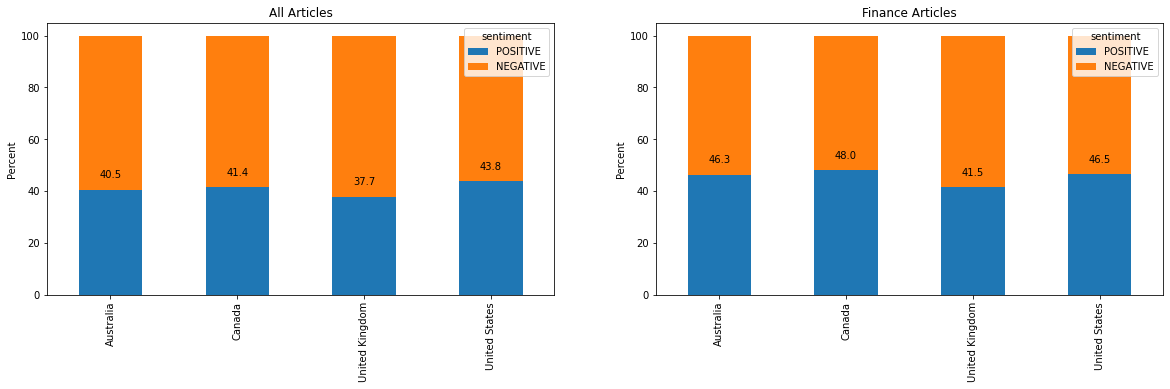

In [38]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))

# All topics
df_comp_chart = df_comp.pivot_table(index="country", columns="sentiment", values="date", aggfunc='count', fill_value=0)
df_comp_chart = df_comp_chart[['POSITIVE', 'NEGATIVE']]
df_comp_chart = df_comp_chart.div(df_comp_chart.sum(axis=1), axis=0).multiply(100)
df_comp_chart = df_comp_chart.sort_values(by="country", ascending=True)
df_comp_chart.plot.bar(stacked=True, title="All Articles", xlabel="", ylabel="Percent", ax=ax1)
for c in ax1.containers[::2]:
    ax1.bar_label(c, label_type='edge', fmt='%0.1f', padding=10)
None

# Finance
df_comp_chart = df_comp[df_comp['primary_topic'] == 'finance']
df_comp_chart = df_comp_chart.pivot_table(index="country", columns="sentiment", values="date", aggfunc='count', fill_value=0)
df_comp_chart = df_comp_chart[['POSITIVE', 'NEGATIVE']]
df_comp_chart = df_comp_chart.div(df_comp_chart.sum(axis=1), axis=0).multiply(100)
df_comp_chart = df_comp_chart.sort_values(by="country", ascending=True)
df_comp_chart.plot.bar(stacked=True, title="Finance Articles", xlabel="", ylabel="Percent", ax=ax2)
for c in ax2.containers[::2]:
    ax2.bar_label(c, label_type='edge', fmt='%0.1f', padding=10)
None

In [39]:
df_comp_chart

sentiment        POSITIVE   NEGATIVE
country                             
Australia       46.334938  53.665062
Canada          48.000297  51.999703
United Kingdom  41.519295  58.480705
United States   46.496900  53.503100

### Topics

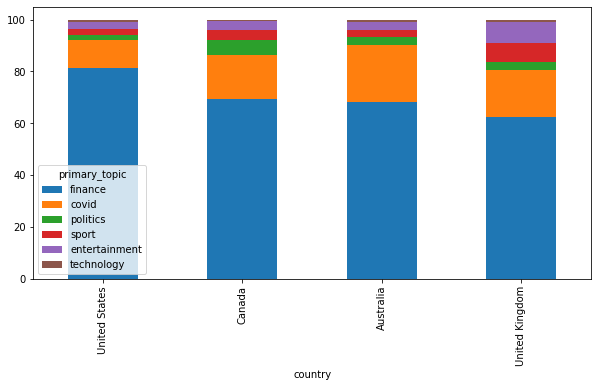

In [40]:
df_comp_chart = df_comp.pivot_table(index=['country'], columns=['primary_topic'], values='date', aggfunc='count', fill_value=0)
df_comp_chart = df_comp_chart[['finance', 'covid', 'politics', 'sport', 'entertainment', 'technology']]
df_comp_chart = df_comp_chart.div(df_comp_chart.sum(axis=1), axis=0).multiply(100)
df_comp_chart = df_comp_chart.sort_values(by="finance", ascending=False)
df_comp_chart
df_comp_chart.plot.bar(stacked=True, figsize = (10,5))
None

### Monthly

In [41]:
df_comp.head(1)

author       date      domain  \
0  Thomas Hughes 2020-01-02  marketbeat   

                                            title  \
0  Three Industrial Giants You Should Own In 2020   

                                                 url  \
0  https://www.marketbeat.com/originals/three-ind...   

                                             content topic_area  \
0  With the end of the year just around the corne...   business   

                                   content_processed distilbert  finbert  \
0  end year corner past time think positioning fo...   POSITIVE  NEUTRAL   

    roberta  sentiment_match sentiment topic_id topic_label topic_label_str  \
0  POSITIVE            False  POSITIVE      970                               

   topic_score                                        topic_words  \
0     0.437342  [caterpillar, ibe, fourthquarter, secondquarte...   

  primary_topic filtered_names_match filtered_names_titles_match  \
0                   Caterpillar Inc.                          []   

   nb_companies  nb_companies_title  blockchain  digitization  machine_learne  \
0             5                   0     0.64344      0.492892        0.579234   

      cloud       iot  store_closure  delivery  redundancy  costcutte  \
0  0.571812  0.521615       0.453935  0.221586    0.588197   0.209348   

    flight  supply_chain  shutdown  outsourcing  workfromhome  \
0  0.51657      0.274569  0.142759     0.503211      0.464359   

   diversification  blockchain_word  digitization_word  machine_learne_word  \
0         0.674917         0.765884           0.667034             0.723726   

   cloud_word  iot_word  store_closure_word  delivery_word  redundancy_word  \
0    0.718853  0.685893            0.641455       0.488895         0.729611   

   costcutte_word  flight_word  supply_chain_word  shutdown_word  \
0         0.48086     0.682581           0.523684       0.437137   

   outsourcing_word  workfromhome_word  diversification_word  vaccines_word  \
0           0.67381           0.648299              0.786551       0.692542   

   drug_discovery_word  tele_health_word  cybersecurity_word  month  \
0             0.646232          0.677501            0.625921      1   

      industry subindustry ticker_symbol        country  company_relevance  
0  Industrials   Machinery           CAT  United States                0.2

In [42]:
df_sent_month_comp = df_comp.pivot_table(index=['country','month'], columns='roberta', values='date', aggfunc='count', fill_value=0)
df_sent_month_comp

df_sent_month_comp['Total'] = df_sent_month_comp.sum(axis=1)
df_sent_month_comp['POS_%'] = round(df_sent_month_comp['POSITIVE'] / df_sent_month_comp['Total'],2)
df_sent_month_comp = df_sent_month_comp['POS_%'].unstack(level='country')

stock_mvmt_analysis = stock_indices.T.pct_change()[1:13]
stock_mvmt_analysis.index = [1,2,3,4,5,6,7,8,9,10,11,12]

df_sent_month_comp = pd.concat([df_sent_month_comp, stock_mvmt_analysis], axis=1)
df_sent_month_comp = df_sent_month_comp.reset_index()
df_sent_month_comp = df_sent_month_comp.rename(columns={'index': 'month'})
display(df_sent_month_comp)

# Cum movement
df_sent_month_comp_cum = df_sent_month_comp.copy()
df_sent_month_comp_cum[['S&P500', 'Dow30','Nasdaq', 'FTSE100', 'ASX200', 'TSX']] = (df_sent_month_comp_cum[['S&P500', 'Dow30','Nasdaq', 'FTSE100', 'ASX200', 'TSX']] + 1).cumprod() - 1

month  Australia  Canada  United Kingdom  United States    S&P500  \
0       1       0.19    0.33            0.34           0.45 -0.001628   
1       2       0.42    0.41            0.35           0.42 -0.084110   
2       3       0.48    0.47            0.40           0.46 -0.125119   
3       4       0.59    0.56            0.52           0.60  0.126844   
4       5       0.67    0.63            0.56           0.66  0.045282   
5       6       0.61    0.62            0.58           0.65  0.018388   
6       7       0.69    0.66            0.64           0.70  0.055101   
7       8       0.68    0.70            0.64           0.75  0.070065   
8       9       0.65    0.63            0.59           0.69 -0.039228   
9      10       0.68    0.57            0.52           0.64 -0.027666   
10     11       0.72    0.65            0.65           0.76  0.107546   
11     12       0.66    0.62            0.61           0.71  0.037121   

       Dow30    Nasdaq   FTSE100    ASX200       TSX  
0  -0.009896  0.019876 -0.033994  0.049835  0.014950  
1  -0.100746 -0.063772 -0.096816 -0.082084 -0.060941  
2  -0.137438 -0.101229 -0.138073 -0.211824 -0.177352  
3   0.110806  0.154472  0.040409  0.087772  0.104785  
4   0.042611  0.067531  0.029723  0.042246  0.027881  
5   0.016931  0.059948  0.015321  0.024706  0.021221  
6   0.023842  0.068249 -0.044070  0.005070  0.042152  
7   0.075742  0.095874  0.011157  0.022386  0.021349  
8  -0.022805 -0.051629 -0.016349 -0.040360 -0.023797  
9  -0.046077 -0.022916 -0.049232  0.019206 -0.033546  
10  0.118372  0.117962  0.123519  0.099568  0.103314  
11  0.032655  0.056526  0.031008  0.010632  0.014142

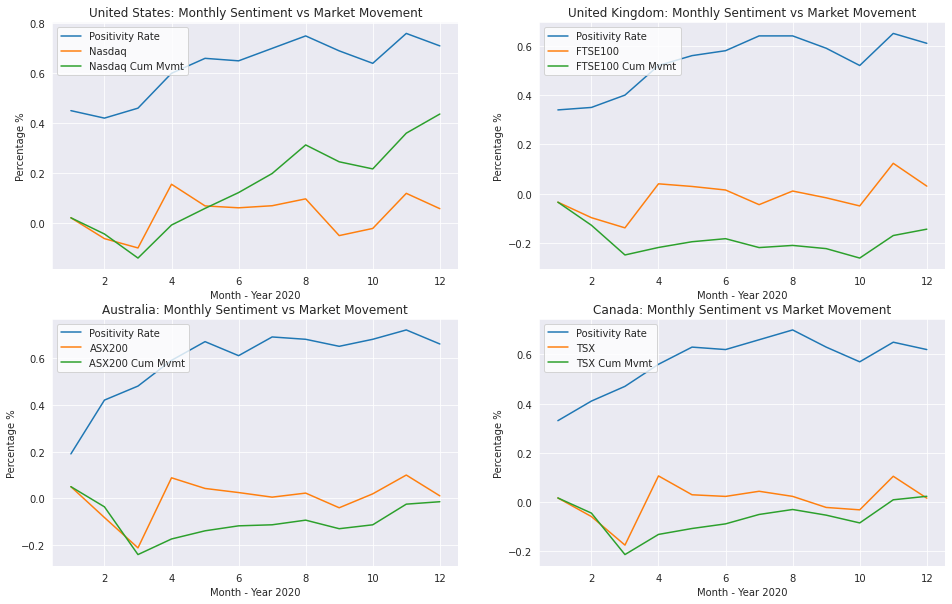

In [43]:
sns.set_style(style='darkgrid')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(16,10))
countries_index = [(ax1, 'United States', 'Nasdaq'),(ax2, 'United Kingdom', 'FTSE100'),(ax3, 'Australia', 'ASX200'),(ax4, 'Canada', 'TSX')]

for ax, country, index in countries_index:
    ax.plot('month', country, data=df_sent_month_comp, label='Positivity Rate')
    ax.plot('month', index, data=df_sent_month_comp, label=index)
    ax.plot('month', index, data=df_sent_month_comp_cum, label=f'{index} Cum Mvmt')
    ax.set_xlabel("Month - Year 2020")
    ax.set_ylabel("Percentage %")
    ax.legend(loc='upper left', facecolor='white')
    ax.set_title(f'{country}: Monthly Sentiment vs Market Movement')

In [44]:
df_sent_month_comp

month  Australia  Canada  United Kingdom  United States    S&P500  \
0       1       0.19    0.33            0.34           0.45 -0.001628   
1       2       0.42    0.41            0.35           0.42 -0.084110   
2       3       0.48    0.47            0.40           0.46 -0.125119   
3       4       0.59    0.56            0.52           0.60  0.126844   
4       5       0.67    0.63            0.56           0.66  0.045282   
5       6       0.61    0.62            0.58           0.65  0.018388   
6       7       0.69    0.66            0.64           0.70  0.055101   
7       8       0.68    0.70            0.64           0.75  0.070065   
8       9       0.65    0.63            0.59           0.69 -0.039228   
9      10       0.68    0.57            0.52           0.64 -0.027666   
10     11       0.72    0.65            0.65           0.76  0.107546   
11     12       0.66    0.62            0.61           0.71  0.037121   

       Dow30    Nasdaq   FTSE100    ASX200       TSX  
0  -0.009896  0.019876 -0.033994  0.049835  0.014950  
1  -0.100746 -0.063772 -0.096816 -0.082084 -0.060941  
2  -0.137438 -0.101229 -0.138073 -0.211824 -0.177352  
3   0.110806  0.154472  0.040409  0.087772  0.104785  
4   0.042611  0.067531  0.029723  0.042246  0.027881  
5   0.016931  0.059948  0.015321  0.024706  0.021221  
6   0.023842  0.068249 -0.044070  0.005070  0.042152  
7   0.075742  0.095874  0.011157  0.022386  0.021349  
8  -0.022805 -0.051629 -0.016349 -0.040360 -0.023797  
9  -0.046077 -0.022916 -0.049232  0.019206 -0.033546  
10  0.118372  0.117962  0.123519  0.099568  0.103314  
11  0.032655  0.056526  0.031008  0.010632  0.014142

In [45]:
print(np.corrcoef(df_sent_month_comp['Australia'], df_sent_month_comp['ASX200']).flatten()[1])
print(np.corrcoef(df_sent_month_comp['Canada'], df_sent_month_comp['TSX']).flatten()[1])
print(np.corrcoef(df_sent_month_comp['United Kingdom'], df_sent_month_comp['FTSE100']).flatten()[1])
print(np.corrcoef(df_sent_month_comp['United States'], df_sent_month_comp['Nasdaq']).flatten()[1])


0.2610114581506542
0.4298816528228194
0.6709246489497799
0.5970562034429587


# Industries

In [46]:
df_comp_month = df_comp[df_comp['company_relevance'] >= 0.2].copy()
df_comp_month['month'] = df_comp_month['date'].dt.month

exclude_marketscreener = False

if exclude_marketscreener:
    df_comp_analysis = df_comp_month[df_comp_month['domain'] != "marketscreener"].copy()
else:
    df_comp_analysis = df_comp_month.copy()
#df_comp_analysis = df_comp_analysis.pivot_table(index=['industry', 'month'], columns='sentiment', values='date', aggfunc='count')
df_comp_analysis = df_comp_analysis.pivot_table(index=['industry', 'month'], columns='roberta', values='date', aggfunc='count')
df_comp_analysis['Total'] = df_comp_analysis.sum(axis=1)
df_comp_analysis['POS_%'] = round(df_comp_analysis['POSITIVE'] / df_comp_analysis['Total'],2)

stock_log_ind_mvmt = stock_log_ind.T.pct_change()
stock_log_ind_mvmt = stock_log_ind_mvmt.dropna()
stock_log_ind_mvmt.index = [1,2,3,4,5,6,7,8,9,10,11,12]
stock_log_ind_mvmt = pd.DataFrame(stock_log_ind_mvmt.stack()).reset_index()
stock_log_ind_mvmt.columns = ['month', 'industry', 'stock_mvmt']

df_comp_analysis = df_comp_analysis.merge(stock_log_ind_mvmt, left_on=['industry', 'month'], right_on=['industry', 'month'])
display(df_comp_analysis)

# Cum movement
df_comp_analysis_cum = df_comp_analysis[['industry','month','stock_mvmt']].copy()
df_comp_analysis_cum = df_comp_analysis_cum.set_index(['industry', 'month'])
df_comp_analysis_cum = df_comp_analysis_cum.unstack('industry')
df_comp_analysis_cum = (df_comp_analysis_cum + 1).cumprod() - 1
df_comp_analysis_cum.columns = df_comp_analysis_cum.columns.droplevel()

industry  month  NEGATIVE  POSITIVE  Total  POS_%  \
0    Consumer Discreptionary      1       171       103    274   0.38   
1    Consumer Discreptionary      2       716       426   1142   0.37   
2    Consumer Discreptionary      3      2646      1692   4338   0.39   
3    Consumer Discreptionary      4      2018      2261   4279   0.53   
4    Consumer Discreptionary      5      2410      3157   5567   0.57   
..                       ...    ...       ...       ...    ...    ...   
127                Utilities      8       101       267    368   0.73   
128                Utilities      9        99       175    274   0.64   
129                Utilities     10        41        76    117   0.65   
130                Utilities     11        50       155    205   0.76   
131                Utilities     12        50       127    177   0.72   

     stock_mvmt  
0     -0.009827  
1     -0.036201  
2     -0.142847  
3      0.079802  
4      0.034457  
..          ...  
127    0.001979  
128   -0.007072  
129    0.007342  
130    0.021823  
131    0.005020  

[132 rows x 7 columns]

In [47]:
df_comp_analysis['industry'].unique()

array(['Consumer Discreptionary', 'Consumer Staples', 'Energy',
       'Financials', 'Healthcare', 'Industrials',
       'Information Technology', 'Materials', 'Real Estate',
       'Telecommunication Services', 'Utilities'], dtype=object)

<AxesSubplot:xlabel='month'>

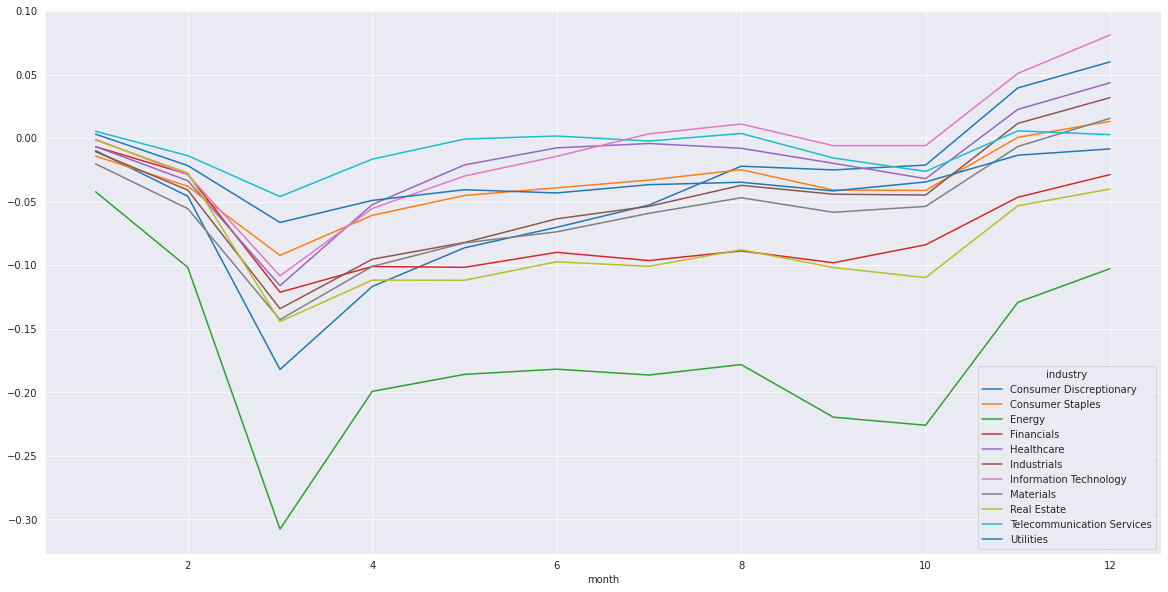

In [48]:
df_comp_analysis_cum.plot(figsize=(20,10))

<ipython-input-49-c61474b040cb>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[idx].set_xticklabels(['Jan','Feb','Apr','Jun','Aug','Oct','Dec'])
<ipython-input-49-c61474b040cb>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[idx].set_xticklabels(['Jan','Feb','Apr','Jun','Aug','Oct','Dec'])
<ipython-input-49-c61474b040cb>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[idx].set_xticklabels(['Jan','Feb','Apr','Jun','Aug','Oct','Dec'])
<ipython-input-49-c61474b040cb>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[idx].set_xticklabels(['Jan','Feb','Apr','Jun','Aug','Oct','Dec'])
<ipython-input-49-c61474b040cb>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[idx].set_xticklabels(['Jan','Feb','Apr','Jun','Aug','Oct','Dec'])
<ipython-input-49-c61474b040cb>:13: UserWarning: FixedFormatter should only be used togeth

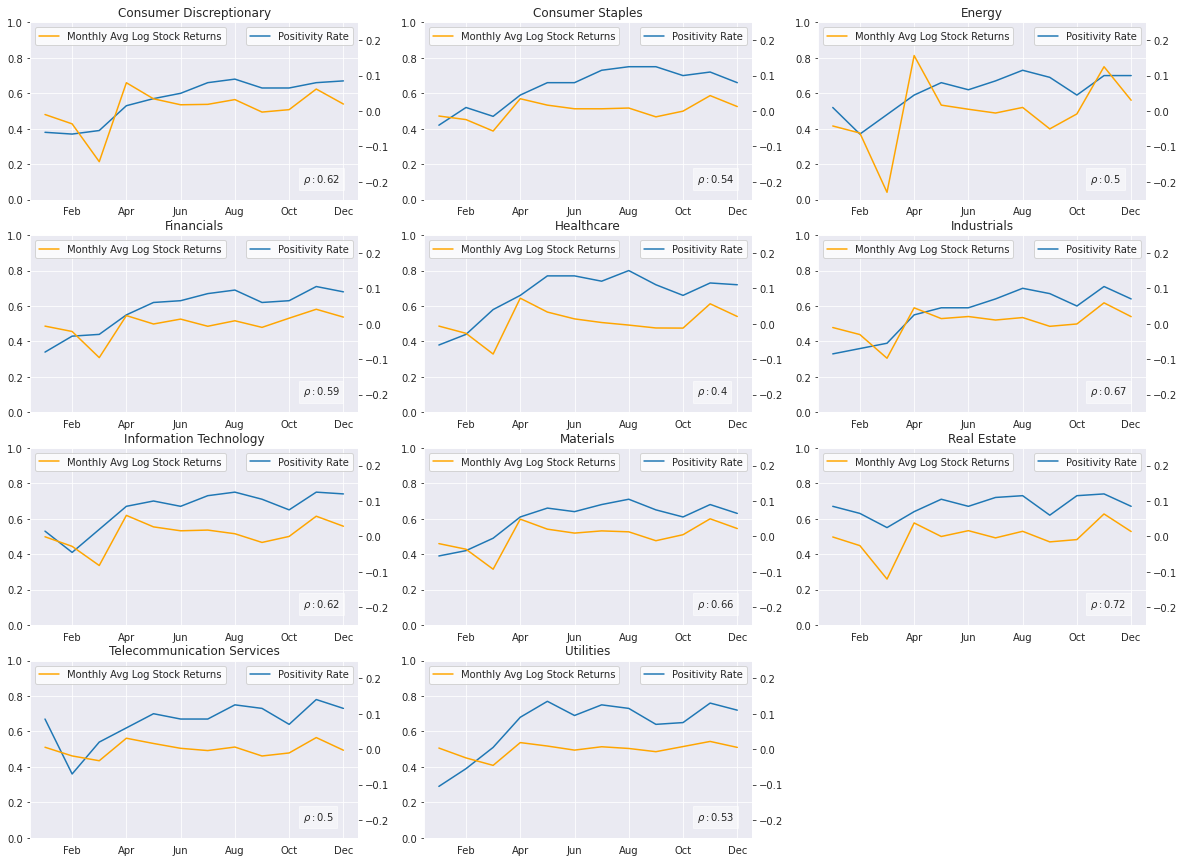

In [49]:
sns.set_style("darkgrid",)
fig, ax = plt.subplots(4,3, figsize=(20,15), sharey=False)
ax = ax.flatten()
ax[11].axis('off')

for idx, industry in enumerate(df_comp_analysis['industry'].unique()):
    ax2 = ax[idx].twinx()
    ax2.plot('month', 'stock_mvmt', data=df_comp_analysis[df_comp_analysis['industry'] == industry], label="Monthly Avg Log Stock Returns", color="orange")
    ax[idx].plot('month', 'POS_%', data=df_comp_analysis[df_comp_analysis['industry'] == industry], label="Positivity Rate")
    ax[idx].set_title(industry)
    #ax[idx].set_xlabel('Month - Year 2020')
    #ax[idx].set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
    ax[idx].set_xticklabels(['Jan','Feb','Apr','Jun','Aug','Oct','Dec'])
    ax[idx].legend(facecolor='white')
    ax[idx].set_ylim(0,1)
    ax2.set_ylim(-0.25,0.25)
    ax2.legend(loc="upper left", facecolor='white')
    ax2.grid(axis='y', visible=False)
    corr = round(np.corrcoef(df_comp_analysis[df_comp_analysis['industry'] == industry]['POS_%'], df_comp_analysis[df_comp_analysis['industry'] == industry]['stock_mvmt']).flatten()[1],2)
    ax[idx].text(10.5, 0.1, '$ \\rho: $' + str(corr), bbox=dict(facecolor='white', alpha=0.5))

### Real Estate

In [70]:
industry = 'Real Estate'
#subindustry = ''
country = 'United States'
#df_top_sent_comp = df_comp[(df_comp['industry'] == industry) & (df_comp['subindustry'] == subindustry) & (df_comp['country'] == country)]
df_top_sent_comp = df_comp[df_comp['company_relevance'] >= 0.2].copy()
df_top_sent_comp = df_top_sent_comp[(df_top_sent_comp['industry'] == industry) & (df_top_sent_comp['country'] == country)]
df_top_sent_comp = df_top_sent_comp.groupby(['filtered_names_match', 'roberta']).count()[['date']].sort_values(by='date', ascending=False)
df_top_sent_comp = df_top_sent_comp.unstack()#.reset_index()
df_top_sent_comp = df_top_sent_comp.fillna(0)
df_top_sent_comp.columns = df_top_sent_comp.columns.droplevel()
df_top_sent_comp.rename_axis(None, inplace=True, axis=1)
df_top_sent_comp['Total'] = df_top_sent_comp.sum(axis=1)
df_top_sent_comp = df_top_sent_comp.sort_values(by='Total', ascending=False)
comp_select = df_top_sent_comp.index[:5]
df_top_sent_comp['POS_%'] = round(df_top_sent_comp['POSITIVE'] / df_top_sent_comp['Total'],2)
df_top_sent_comp['ticker'] =  df_top_sent_comp.index.map(comp_ticker_dict)
df_top_sent_comp['stock_mvmt'] = df_top_sent_comp['ticker'].map(stock_final_mvmt_dict)
df_top_sent_comp = df_top_sent_comp[df_top_sent_comp['stock_mvmt'].notna()]
print(len(df_top_sent_comp))
df_top_sent_comp[df_top_sent_comp['Total'] >= 10].sort_values(by="POS_%", ascending=False)[:20]

189


NEGATIVE  POSITIVE  Total  POS_% ticker  \
filtered_names_match                                                           
Highwoods Properties, Inc.                0.0      12.0   12.0   1.00    HIW   
Kilroy Realty Corporation                 0.0      10.0   10.0   1.00    KRC   
Independence Realty Trust, Inc.           0.0      16.0   16.0   1.00    IRT   
First Industrial Realty Trust, Inc.       0.0      14.0   14.0   1.00     FR   
Equinix, Inc. (REIT)                      0.0      12.0   12.0   1.00   EQIX   
Newmark Group, Inc.                       0.0      22.0   22.0   1.00   NMRK   
Physicians Realty Trust                   1.0      16.0   17.0   0.94    DOC   
Acadia Realty Trust                       1.0      17.0   18.0   0.94    AKR   
Gladstone Land Corporation                1.0      16.0   17.0   0.94   LAND   
RE/MAX Holdings, Inc.                     1.0      11.0   12.0   0.92   RMAX   
Brixmor Property Group Inc.               1.0      11.0   12.0   0.92    BRX   
NexPoint Residential Trust, Inc.          1.0      11.0   12.0   0.92   NXRT   
CyrusOne Inc.                             1.0      12.0   13.0   0.92   CONE   
Four Corners Property Trust, Inc.         1.0      10.0   11.0   0.91   FCPT   
American Campus Communities, Inc.         1.0      10.0   11.0   0.91    ACC   
Duke Realty Corporation                   1.0      10.0   11.0   0.91    DRE   
Healthcare Trust of America, Inc.         2.0      18.0   20.0   0.90    HTA   
CorePoint Lodging Inc.                    2.0      18.0   20.0   0.90   CPLG   
Spirit Realty Capital, Inc.               2.0      18.0   20.0   0.90    SRC   
Realogy Holdings Corp.                    1.0       9.0   10.0   0.90   RLGY   

                                     stock_mvmt  
filtered_names_match                             
Highwoods Properties, Inc.                -0.15  
Kilroy Realty Corporation                 -0.29  
Independence Realty Trust, Inc.            0.01  
First Industrial Realty Trust, Inc.        0.04  
Equinix, Inc. (REIT)                       0.24  
Newmark Group, Inc.                       -0.45  
Physicians Realty Trust                   -0.01  
Acadia Realty Trust                       -0.43  
Gladstone Land Corporation                 0.17  
RE/MAX Holdings, Inc.                     -0.03  
Brixmor Property Group Inc.               -0.19  
NexPoint Residential Trust, Inc.          -0.03  
CyrusOne Inc.                              0.15  
Four Corners Property Trust, Inc.          0.11  
American Campus Communities, Inc.         -0.04  
Duke Realty Corporation                    0.18  
Healthcare Trust of America, Inc.         -0.05  
CorePoint Lodging Inc.                    -0.31  
Spirit Realty Capital, Inc.               -0.12  
Realogy Holdings Corp.                     0.36

20
16


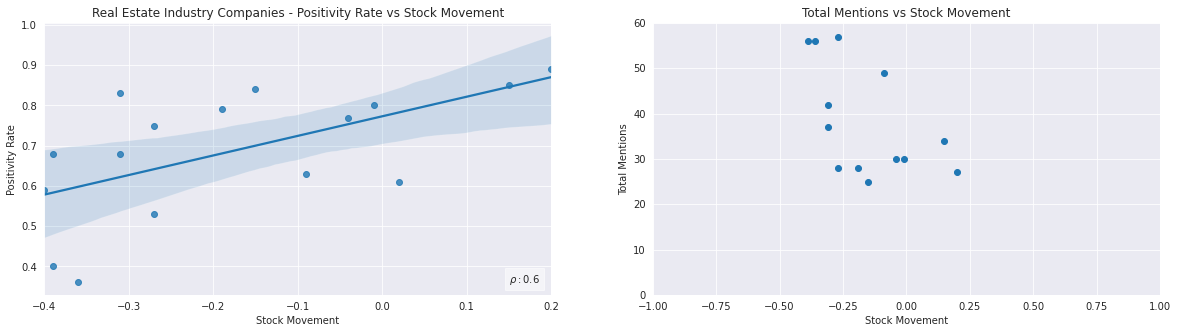

In [75]:
min_articles = 25
plot_data = df_top_sent_comp[df_top_sent_comp['Total'] >= min_articles]
print(len(plot_data))
plot_data = plot_data[plot_data['stock_mvmt'].between(plot_data['stock_mvmt'].quantile(.1), plot_data['stock_mvmt'].quantile(.90))] 
print(len(plot_data))
corr = round(np.corrcoef(plot_data['POS_%'], plot_data['stock_mvmt']).flatten()[1],2)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
#ax1.scatter(x="stock_mvmt", y="POS_%", data=plot_data)
sns.regplot(x="stock_mvmt", y="POS_%", data=plot_data, ax=ax1)
ax2.scatter(x="stock_mvmt", y="Total", data=plot_data)
#ax1.set_xlim(-1,1)
ax2.set_ylim(bottom=0, top=60)
ax2.set_xlim(-1,1)
ax1.set_xlabel("Stock Movement")
ax2.set_xlabel("Stock Movement")
ax1.set_ylabel("Positivity Rate")
ax2.set_ylabel("Total Mentions")
ax1.set_title("Real Estate Industry Companies - Positivity Rate vs Stock Movement")
ax2.set_title("Total Mentions vs Stock Movement")
ax1.text(0.15, 0.36, '$ \\rho: $' + str(corr), bbox=dict(facecolor='white', alpha=0.5))
plt.show()

In [66]:
df_comp_analysis_multi = pd.DataFrame()
df_comp_analysis_stocks_worst = pd.DataFrame()
df_comp_analysis_stocks_best = pd.DataFrame()

worst_performers = plot_data.sort_values('stock_mvmt').head(3)
best_performers = plot_data.sort_values('stock_mvmt').tail(3)

for company in worst_performers.index:
    df_comp_analysis = df_comp_month[df_comp_month['filtered_names_match'] == company]
    df_comp_analysis = df_comp_analysis.pivot_table(index='month', columns='roberta', values='date', aggfunc='count', fill_value=0)
    df_comp_analysis['Total'] = df_comp_analysis.sum(axis=1)
    df_comp_analysis['POS_%'] = round(df_comp_analysis['POSITIVE'] / df_comp_analysis['Total'],2)
    
    ticker = comp_ticker_dict[company]
    stock_mvmt_analysis = stock_final.loc[ticker].pct_change()[1:13]
    stock_mvmt_analysis.index = [1,2,3,4,5,6,7,8,9,10,11,12]

    df_comp_analysis['stock_mvmt'] = stock_mvmt_analysis
    df_comp_analysis = df_comp_analysis.reset_index()
    df_comp_analysis['company'] = company
    df_comp_analysis_multi = df_comp_analysis_multi.append(df_comp_analysis)
    
    stock_temp = pd.DataFrame(stock_mvmt_analysis).reset_index()
    stock_temp.columns = ['month','stock_mvmt']
    stock_temp['company'] = company
    df_comp_analysis_stocks_worst = df_comp_analysis_stocks_worst.append(stock_temp)
    
for company in best_performers.index:
    df_comp_analysis = df_comp_month[df_comp_month['filtered_names_match'] == company]
    df_comp_analysis = df_comp_analysis.pivot_table(index='month', columns='roberta', values='date', aggfunc='count', fill_value=0)
    df_comp_analysis['Total'] = df_comp_analysis.sum(axis=1)
    df_comp_analysis['POS_%'] = round(df_comp_analysis['POSITIVE'] / df_comp_analysis['Total'],2)
    
    ticker = comp_ticker_dict[company]
    stock_mvmt_analysis = stock_final.loc[ticker].pct_change()[1:13]
    stock_mvmt_analysis.index = [1,2,3,4,5,6,7,8,9,10,11,12]

    df_comp_analysis['stock_mvmt'] = stock_mvmt_analysis
    df_comp_analysis = df_comp_analysis.reset_index()
    df_comp_analysis['company'] = company
    df_comp_analysis_multi = df_comp_analysis_multi.append(df_comp_analysis)
    
    stock_temp = pd.DataFrame(stock_mvmt_analysis).reset_index()
    stock_temp.columns = ['month','stock_mvmt']
    stock_temp['company'] = company
    df_comp_analysis_stocks_best = df_comp_analysis_stocks_best.append(stock_temp)

<ipython-input-175-f0008bc2717c>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(['Jan','Feb','Apr','Jun','Aug','Oct','Dec'])


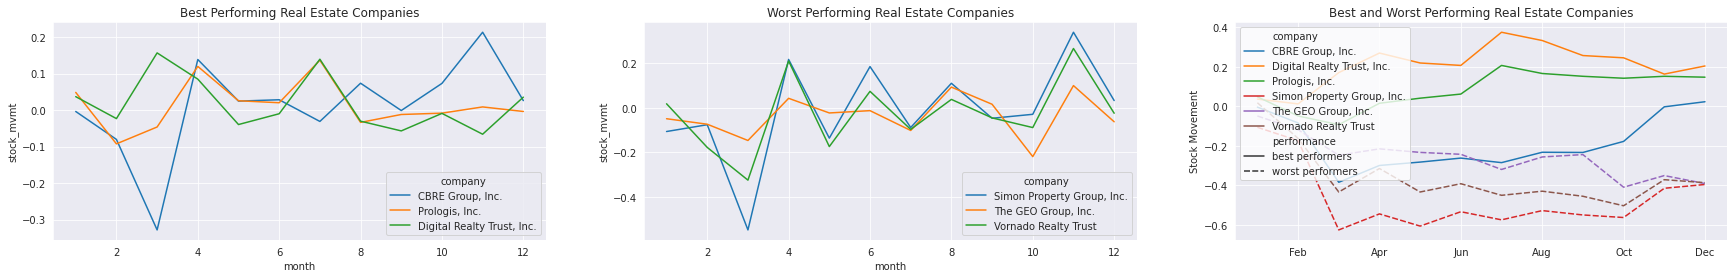

In [175]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(30,4))

# Cum movement
plot_data_best = ((df_comp_analysis_stocks_best.set_index(['month','company']).unstack('company') + 1).cumprod() - 1).stack().reset_index().sort_values(['company', 'month'])
plot_data_best['performance'] = 'best performers'
plot_data_worst = ((df_comp_analysis_stocks_worst.set_index(['month','company']).unstack('company') + 1).cumprod() - 1).stack().reset_index().sort_values(['company', 'month'])
plot_data_worst['performance'] = 'worst performers'
plot_data = plot_data_best.append(plot_data_worst)

sns.lineplot(ax=ax1, x='month', y='stock_mvmt', data=df_comp_analysis_stocks_best, hue='company')
sns.lineplot(ax=ax2, x='month', y='stock_mvmt', data=df_comp_analysis_stocks_worst, hue='company')
sns.lineplot(ax=ax3, x='month', y='stock_mvmt', data=plot_data, hue='company', style='performance')
#sns.lineplot(ax=ax3, x='month', y='stock_mvmt', data=plot_data_worst, hue='company', linestyle='--')
ax3.set_xticklabels(['Jan','Feb','Apr','Jun','Aug','Oct','Dec'])
ax1.set_title('Best Performing Real Estate Companies')
ax2.set_title('Worst Performing Real Estate Companies')
ax3.set_title('Best and Worst Performing Real Estate Companies')
ax3.set_ylabel('Stock Movement')
ax3.set_xlabel(None)
ax3.legend(loc='upper left', facecolor='white')


None

<ipython-input-171-586d6d1ee17e>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(['Jan','Feb','Apr','Jun','Aug','Oct','Dec'])


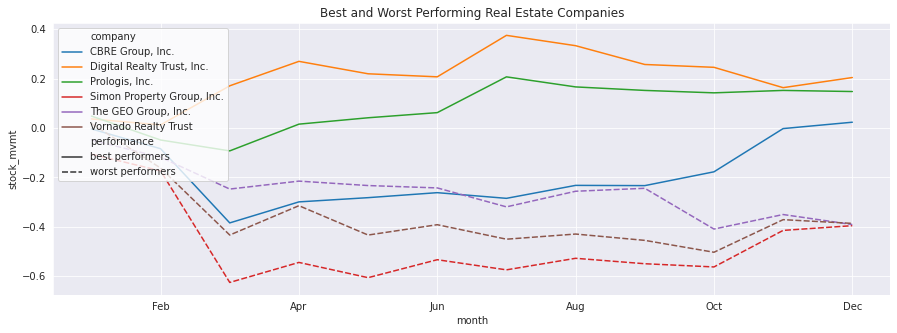

In [171]:
fig, (ax3) = plt.subplots(1,1, figsize=(15,5))

# Cum movement
plot_data_best = ((df_comp_analysis_stocks_best.set_index(['month','company']).unstack('company') + 1).cumprod() - 1).stack().reset_index().sort_values(['company', 'month'])
plot_data_best['performance'] = 'best performers'
plot_data_worst = ((df_comp_analysis_stocks_worst.set_index(['month','company']).unstack('company') + 1).cumprod() - 1).stack().reset_index().sort_values(['company', 'month'])
plot_data_worst['performance'] = 'worst performers'
plot_data = plot_data_best.append(plot_data_worst)

sns.lineplot(ax=ax3, x='month', y='stock_mvmt', data=plot_data, hue='company', style='performance')
#sns.lineplot(ax=ax3, x='month', y='stock_mvmt', data=plot_data_worst, hue='company', linestyle='--')
ax3.set_xticklabels(['Jan','Feb','Apr','Jun','Aug','Oct','Dec'])
ax3.set_title('Best and Worst Performing Real Estate Companies')
ax3.legend(loc='upper left', facecolor='white')


None

In [89]:
# Deep dive topics
industry = 'Real Estate'
country = 'United States'
df_top_sent_comp = df_comp[(df_comp['industry'] == industry) & (df_comp['country'] == country) & df_comp['filtered_names_match'].isin(best_performers.index)]
df_top_sent_comp = df_top_sent_comp[df_top_sent_comp['topic_score'] > 0.5]
df_top_sent_comp = df_top_sent_comp.explode('topic_label').groupby(['filtered_names_match', 'topic_label', 'sentiment']).count()[['date']].sort_values(by='date', ascending=False)
df_top_sent_comp = df_top_sent_comp.unstack()#.reset_index()
df_top_sent_comp = df_top_sent_comp.fillna(0)
df_top_sent_comp.columns = df_top_sent_comp.columns.droplevel()
df_top_sent_comp.rename_axis(None, inplace=True, axis=1)
df_top_sent_comp['Total'] = df_top_sent_comp.sum(axis=1)
df_top_sent_comp['POS_%'] = round(df_top_sent_comp['POSITIVE'] / df_top_sent_comp['Total'],2)
#df_top_sent_comp = df_top_sent_comp.sort_values(by='Total', ascending=False)
df_top_sent_comp[df_top_sent_comp['Total'] > 2].sort_values(['filtered_names_match','Total'], ascending=False)

NEGATIVE  POSITIVE  Total  \
filtered_names_match       topic_label                                        
Prologis, Inc.             finance                     8.0      14.0   22.0   
                           result_announcements        3.0      10.0   13.0   
                           real_estate_companies       4.0       7.0   11.0   
                                                       4.0       3.0    7.0   
                           property_companies          1.0       3.0    4.0   
Digital Realty Trust, Inc. finance                    12.0      10.0   22.0   
                                                       4.0       6.0   10.0   
                           general_updats              1.0       5.0    6.0   
                           real_estate_companies       1.0       5.0    6.0   
                           cloud                       2.0       1.0    3.0   
                           general_updates             1.0       2.0    3.0   
                           technavio_updates           1.0       2.0    3.0   
CBRE Group, Inc.           finance                    22.0      13.0   35.0   
                                                      23.0       7.0   30.0   
                           covid                       8.0       3.0   11.0   
                           result_announcements        6.0       2.0    8.0   
                           other                       5.0       1.0    6.0   
                           real_estate_companies       3.0       3.0    6.0   
                           hedge_funds                 5.0       0.0    5.0   
                           black_friday                2.0       2.0    4.0   
                           company_specific            1.0       3.0    4.0   
                           retail_sales                2.0       2.0    4.0   
                           new_york                    3.0       0.0    3.0   
                           rental_properties           3.0       0.0    3.0   
                           uk                          2.0       1.0    3.0   

                                                  POS_%  
filtered_names_match       topic_label                   
Prologis, Inc.             finance                 0.64  
                           result_announcements    0.77  
                           real_estate_companies   0.64  
                                                   0.43  
                           property_companies      0.75  
Digital Realty Trust, Inc. finance                 0.45  
                                                   0.60  
                           general_updats          0.83  
                           real_estate_companies   0.83  
                           cloud                   0.33  
                           general_updates         0.67  
                           technavio_updates       0.67  
CBRE Group, Inc.           finance                 0.37  
                                                   0.23  
                           covid                   0.27  
                           result_announcements    0.25  
                           other                   0.17  
                           real_estate_companies   0.50  
                           hedge_funds             0.00  
                           black_friday            0.50  
                           company_specific        0.75  
                           retail_sales            0.50  
                           new_york                0.00  
                           rental_properties       0.00  
                           uk                      0.33

In [173]:
# Deep dive topics
industry = 'Real Estate'
country = 'United States'
df_top_sent_comp = df_comp[(df_comp['industry'] == industry) & (df_comp['country'] == country) & df_comp['filtered_names_match'].isin(worst_performers.index)]
df_top_sent_comp = df_top_sent_comp[df_top_sent_comp['topic_score'] > 0.5]
df_top_sent_comp = df_top_sent_comp.explode('topic_label').groupby(['filtered_names_match', 'topic_label', 'sentiment']).count()[['date']].sort_values(by='date', ascending=False)
df_top_sent_comp = df_top_sent_comp.unstack()#.reset_index()
df_top_sent_comp = df_top_sent_comp.fillna(0)
df_top_sent_comp.columns = df_top_sent_comp.columns.droplevel()
df_top_sent_comp.rename_axis(None, inplace=True, axis=1)
df_top_sent_comp['Total'] = df_top_sent_comp.sum(axis=1)
df_top_sent_comp['POS_%'] = round(df_top_sent_comp['POSITIVE'] / df_top_sent_comp['Total'],2)
df_top_sent_comp[df_top_sent_comp['Total'] > 2].sort_values(['filtered_names_match','Total'], ascending=False)

NEGATIVE  POSITIVE  \
filtered_names_match       topic_label                                    
Vornado Realty Trust       finance                       18.0      16.0   
                           result_announcements           4.0      10.0   
                                                          4.0       5.0   
                           general_stock_updates          5.0       3.0   
                           property_companies             0.0       8.0   
                           real_estate_companies          5.0       3.0   
                           hedge_funds                    3.0       0.0   
The GEO Group, Inc.        other                         55.0      29.0   
                           lawsuits                      55.0      28.0   
                           finance                       11.0      12.0   
                           result_announcements           1.0       8.0   
                                                          4.0       4.0   
                           detention                      8.0       0.0   
                           politics                       8.0       0.0   
                           refugees                       8.0       0.0   
                           resource_companies             0.0       7.0   
                           hedge_funds                    3.0       1.0   
                           credit_ratings                 3.0       0.0   
                           general_updates                3.0       0.0   
Simon Property Group, Inc. finance                      173.0     109.0   
                           retailers                     91.0      41.0   
                           bankruptcy                    80.0      38.0   
                                                         78.0      22.0   
                           general_stock_updates         16.0      20.0   
                           store_closures                18.0       9.0   
                           job_losses                    14.0       8.0   
                           real_estate_companies         13.0       7.0   
                           covid                         12.0       2.0   
                           general_updats                 9.0       5.0   
                           clothing_retailers             6.0       4.0   
                           us_stock_updates               5.0       5.0   
                           company_specific               5.0       4.0   
                           us_shares                      3.0       6.0   
                           covid_stimulus                 4.0       4.0   
                           luxury_fashion_retailers       4.0       4.0   
                           black_friday                   4.0       3.0   
                           retail_sales                   4.0       3.0   
                           result_announcements           4.0       2.0   
                           lvmh                           1.0       4.0   
                           share_offering                 5.0       0.0   
                           takeover                       1.0       4.0   
                           tiffanys                       1.0       4.0   
                           hedge_funds                    4.0       0.0   
                           jim_cramer_cnbc_updates        2.0       2.0   
                           us                             1.0       3.0   
                           banks                          3.0       0.0   
                           case_numbers                   3.0       0.0   
                           financial_updates              3.0       0.0   

                                                     Total  POS_%  
filtered_names_match       topic_label                             
Vornado Realty Trust       finance                    34.0   0.47  
                           result_announcements       14.0   0.71  
                              

### Industrials

In [199]:
industry = 'Industrials'
#subindustry = 'Machinery'
country = 'United States'
#df_top_sent_comp = df_comp[(df_comp['industry'] == industry) & (df_comp['subindustry'] == subindustry) & (df_comp['country'] == country)]
df_top_sent_comp = df_comp[df_comp['company_relevance'] >= 0.2].copy()
df_top_sent_comp = df_top_sent_comp[(df_top_sent_comp['industry'] == industry) & (df_top_sent_comp['country'] == country)]
df_top_sent_comp = df_top_sent_comp.groupby(['filtered_names_match', 'roberta']).count()[['date']].sort_values(by='date', ascending=False)
df_top_sent_comp = df_top_sent_comp.unstack()#.reset_index()
df_top_sent_comp = df_top_sent_comp.fillna(0)
df_top_sent_comp.columns = df_top_sent_comp.columns.droplevel()
df_top_sent_comp.rename_axis(None, inplace=True, axis=1)
df_top_sent_comp['Total'] = df_top_sent_comp.sum(axis=1)
df_top_sent_comp = df_top_sent_comp.sort_values(by='Total', ascending=False)
comp_select = df_top_sent_comp.index[:5]
df_top_sent_comp['POS_%'] = round(df_top_sent_comp['POSITIVE'] / df_top_sent_comp['Total'],2)
df_top_sent_comp['ticker'] =  df_top_sent_comp.index.map(comp_ticker_dict)
df_top_sent_comp['stock_mvmt'] = df_top_sent_comp['ticker'].map(stock_final_mvmt_dict)
df_top_sent_comp = df_top_sent_comp[df_top_sent_comp['stock_mvmt'].notna()]
print(len(df_top_sent_comp))
df_top_sent_comp[df_top_sent_comp['Total'] >= 10].sort_values(by="POS_%", ascending=False)[:20]

430


NEGATIVE  POSITIVE  Total  POS_%  \
filtered_names_match                                                        
ESCO Technologies Inc.                        0.0      11.0   11.0   1.00   
Blue Bird Corporation                         0.0      18.0   18.0   1.00   
Energous Corporation                          0.0      12.0   12.0   1.00   
Universal Forest Products, Inc.               0.0      13.0   13.0   1.00   
Franklin Covey Co.                            0.0      13.0   13.0   1.00   
Capstone Turbine Corporation                  0.0      32.0   32.0   1.00   
Allison Transmission Holdings, Inc.           0.0      14.0   14.0   1.00   
Air Transport Services Group, Inc.            0.0      15.0   15.0   1.00   
Masco Corporation                             0.0      16.0   16.0   1.00   
Icahn Enterprises L.P.                        0.0      11.0   11.0   1.00   
Donaldson Company, Inc.                       0.0      17.0   17.0   1.00   
SG Blocks, Inc.                               0.0      12.0   12.0   1.00   
KAR Auction Services, Inc.                    0.0      18.0   18.0   1.00   
MSA Safety Incorporated                       0.0      22.0   22.0   1.00   
TriNet Group, Inc.                            0.0      10.0   10.0   1.00   
Roadrunner Transportation Systems, Inc.       0.0      10.0   10.0   1.00   
Upwork Inc.                                   0.0      10.0   10.0   1.00   
Commercial Vehicle Group, Inc.                0.0      26.0   26.0   1.00   
Rockwell Automation, Inc.                     4.0      69.0   73.0   0.95   
Dover Corporation                             1.0      21.0   22.0   0.95   

                                        ticker  stock_mvmt  
filtered_names_match                                        
ESCO Technologies Inc.                     ESE        0.12  
Blue Bird Corporation                     BLBD       -0.20  
Energous Corporation                      WATT        0.02  
Universal Forest Products, Inc.           UFPI        0.18  
Franklin Covey Co.                          FC       -0.31  
Capstone Turbine Corporation              CGRN        2.50  
Allison Transmission Holdings, Inc.       ALSN       -0.09  
Air Transport Services Group, Inc.        ATSG        0.34  
Masco Corporation                          MAS        0.16  
Icahn Enterprises L.P.                     IEP       -0.04  
Donaldson Company, Inc.                    DCI       -0.01  
SG Blocks, Inc.                           SGBX        0.94  
KAR Auction Services, Inc.                 KAR       -0.13  
MSA Safety Incorporated                    MSA        0.20  
TriNet Group, Inc.                        TNET        0.42  
Roadrunner Transportation Systems, Inc.   RRTS       -0.78  
Upwork Inc.                               UPWK        2.24  
Commercial Vehicle Group, Inc.            CVGI        0.36  
Rockwell Automation, Inc.                  ROK        0.26  
Dover Corporation                          DOV        0.12

90
72


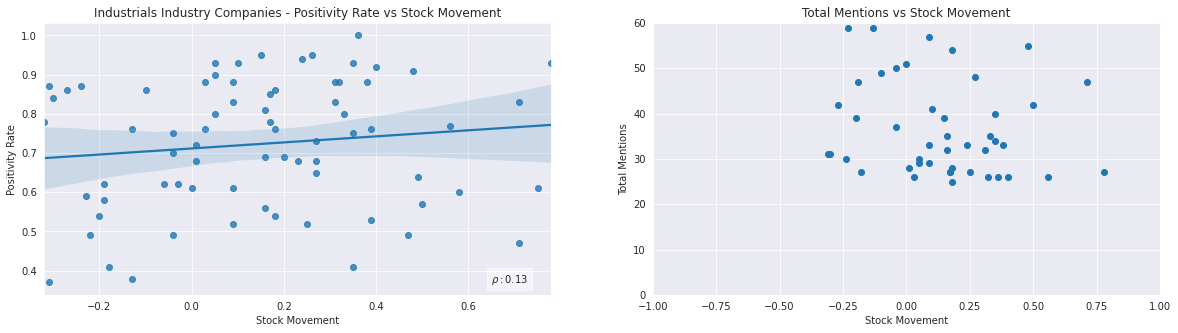

In [200]:
min_articles = 25
plot_data = df_top_sent_comp[df_top_sent_comp['Total'] >= min_articles]
print(len(plot_data))
plot_data = plot_data[plot_data['stock_mvmt'].between(plot_data['stock_mvmt'].quantile(.1), plot_data['stock_mvmt'].quantile(.90))] 
print(len(plot_data))
corr = round(np.corrcoef(plot_data['POS_%'], plot_data['stock_mvmt']).flatten()[1],2)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
#ax1.scatter(x="stock_mvmt", y="POS_%", data=plot_data)
sns.regplot(x="stock_mvmt", y="POS_%", data=plot_data, ax=ax1)
ax2.scatter(x="stock_mvmt", y="Total", data=plot_data)
#ax1.set_xlim(-1,1)
ax2.set_ylim(bottom=0, top=60)
ax2.set_xlim(-1,1)
ax1.set_xlabel("Stock Movement")
ax2.set_xlabel("Stock Movement")
ax1.set_ylabel("Positivity Rate")
ax2.set_ylabel("Total Mentions")
ax1.set_title("Industrials Industry Companies - Positivity Rate vs Stock Movement")
ax2.set_title("Total Mentions vs Stock Movement")
ax1.text(0.65, 0.37, '$ \\rho: $' + str(corr), bbox=dict(facecolor='white', alpha=0.5))
plt.show()

### Materials

In [201]:
industry = 'Materials'
#subindustry = 'Machinery'
country = 'United States'
#df_top_sent_comp = df_comp[(df_comp['industry'] == industry) & (df_comp['subindustry'] == subindustry) & (df_comp['country'] == country)]
df_top_sent_comp = df_comp[df_comp['company_relevance'] >= 0.2].copy()
df_top_sent_comp = df_top_sent_comp[(df_top_sent_comp['industry'] == industry) & (df_top_sent_comp['country'] == country)]
df_top_sent_comp = df_top_sent_comp.groupby(['filtered_names_match', 'roberta']).count()[['date']].sort_values(by='date', ascending=False)
df_top_sent_comp = df_top_sent_comp.unstack()#.reset_index()
df_top_sent_comp = df_top_sent_comp.fillna(0)
df_top_sent_comp.columns = df_top_sent_comp.columns.droplevel()
df_top_sent_comp.rename_axis(None, inplace=True, axis=1)
df_top_sent_comp['Total'] = df_top_sent_comp.sum(axis=1)
df_top_sent_comp = df_top_sent_comp.sort_values(by='Total', ascending=False)
comp_select = df_top_sent_comp.index[:5]
df_top_sent_comp['POS_%'] = round(df_top_sent_comp['POSITIVE'] / df_top_sent_comp['Total'],2)
df_top_sent_comp['ticker'] =  df_top_sent_comp.index.map(comp_ticker_dict)
df_top_sent_comp['stock_mvmt'] = df_top_sent_comp['ticker'].map(stock_final_mvmt_dict)
df_top_sent_comp = df_top_sent_comp[df_top_sent_comp['stock_mvmt'].notna()]
print(len(df_top_sent_comp))
df_top_sent_comp[df_top_sent_comp['Total'] >= 10].sort_values(by="POS_%", ascending=False)[:20]

137


NEGATIVE  POSITIVE  Total  POS_% ticker  \
filtered_names_match                                                           
The Chemours Company                      0.0      11.0   11.0   1.00     CC   
Clearwater Paper Corporation              0.0      14.0   14.0   1.00    CLW   
Stepan Company                            0.0      21.0   21.0   1.00    SCL   
W. R. Grace & Co.                         0.0      18.0   18.0   1.00    GRA   
The Scotts Miracle-Gro Company            0.0      12.0   12.0   1.00    SMG   
Cabot Corporation                         0.0      12.0   12.0   1.00    CBT   
Hecla Mining Company                      1.0      24.0   25.0   0.96     HL   
Air Products and Chemicals, Inc.          2.0      41.0   43.0   0.95    APD   
Eastman Chemical Company                  2.0      31.0   33.0   0.94    EMN   
Allegheny Technologies Incorporated       1.0      16.0   17.0   0.94    ATI   
Commercial Metals Company                 2.0      33.0   35.0   0.94    CMC   
Huntsman Corporation                      2.0      26.0   28.0   0.93    HUN   
Avery Dennison Corporation                2.0      26.0   28.0   0.93    AVY   
Argonaut Gold Inc.                        1.0      13.0   14.0   0.93     AR   
Synalloy Corporation                      1.0      14.0   15.0   0.93   SYNL   
Texas Mineral Resources Corp.            14.0     183.0  197.0   0.93   TMRC   
Martin Marietta Materials, Inc.           1.0      12.0   13.0   0.92    MLM   
AgroFresh Solutions, Inc.                 1.0      12.0   13.0   0.92   AGFS   
CF Industries Holdings, Inc.              1.0      10.0   11.0   0.91     CF   
AdvanSix Inc.                             1.0      10.0   11.0   0.91   ASIX   

                                     stock_mvmt  
filtered_names_match                             
The Chemours Company                       0.46  
Clearwater Paper Corporation               0.77  
Stepan Company                             0.18  
W. R. Grace & Co.                         -0.20  
The Scotts Miracle-Gro Company             0.95  
Cabot Corporation                         -0.02  
Hecla Mining Company                       0.92  
Air Products and Chemicals, Inc.           0.19  
Eastman Chemical Company                   0.32  
Allegheny Technologies Incorporated       -0.19  
Commercial Metals Company                 -0.05  
Huntsman Corporation                       0.08  
Avery Dennison Corporation                 0.21  
Argonaut Gold Inc.                         0.91  
Synalloy Corporation                      -0.40  
Texas Mineral Resources Corp.              0.44  
Martin Marietta Materials, Inc.            0.03  
AgroFresh Solutions, Inc.                 -0.12  
CF Industries Holdings, Inc.              -0.16  
AdvanSix Inc.                              0.00

35
27


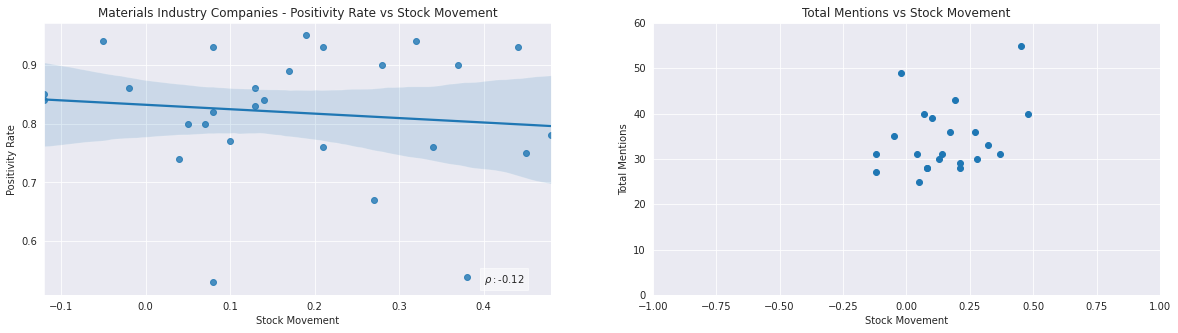

In [202]:
min_articles = 25
plot_data = df_top_sent_comp[df_top_sent_comp['Total'] >= min_articles]
print(len(plot_data))
plot_data = plot_data[plot_data['stock_mvmt'].between(plot_data['stock_mvmt'].quantile(.1), plot_data['stock_mvmt'].quantile(.90))] 
print(len(plot_data))
corr = round(np.corrcoef(plot_data['POS_%'], plot_data['stock_mvmt']).flatten()[1],2)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
#ax1.scatter(x="stock_mvmt", y="POS_%", data=plot_data)
sns.regplot(x="stock_mvmt", y="POS_%", data=plot_data, ax=ax1)
ax2.scatter(x="stock_mvmt", y="Total", data=plot_data)
#ax1.set_xlim(-1,1)
ax2.set_ylim(bottom=0, top=60)
ax2.set_xlim(-1,1)
ax1.set_xlabel("Stock Movement")
ax2.set_xlabel("Stock Movement")
ax1.set_ylabel("Positivity Rate")
ax2.set_ylabel("Total Mentions")
ax1.set_title("Materials Industry Companies - Positivity Rate vs Stock Movement")
ax2.set_title("Total Mentions vs Stock Movement")
ax1.text(0.4, 0.53, '$ \\rho: $' + str(corr), bbox=dict(facecolor='white', alpha=0.5))
plt.show()

#### Airlines

In [210]:
industry = 'Industrials'
subindustry = 'Airlines'
country = 'United States'
df_top_sent_comp = df_comp[df_comp['company_relevance'] >= 0.2].copy()
df_top_sent_comp = df_top_sent_comp[(df_top_sent_comp['industry'] == industry) & (df_top_sent_comp['subindustry'] == subindustry) & (df_top_sent_comp['country'] == country)]
#df_top_sent_comp = df_top_sent_comp[(df_top_sent_comp['industry'] == industry) & (df_top_sent_comp['country'] == country)]
df_top_sent_comp = df_top_sent_comp.groupby(['filtered_names_match', 'roberta']).count()[['date']].sort_values(by='date', ascending=False)
df_top_sent_comp = df_top_sent_comp.unstack()#.reset_index()
df_top_sent_comp = df_top_sent_comp.fillna(0)
df_top_sent_comp.columns = df_top_sent_comp.columns.droplevel()
df_top_sent_comp.rename_axis(None, inplace=True, axis=1)
df_top_sent_comp['Total'] = df_top_sent_comp.sum(axis=1)
df_top_sent_comp = df_top_sent_comp.sort_values(by='Total', ascending=False)
comp_select = df_top_sent_comp.index[:5]
df_top_sent_comp['POS_%'] = round(df_top_sent_comp['POSITIVE'] / df_top_sent_comp['Total'],2)
df_top_sent_comp['ticker'] =  df_top_sent_comp.index.map(comp_ticker_dict)
df_top_sent_comp['stock_mvmt'] = df_top_sent_comp['ticker'].map(stock_final_mvmt_dict)
df_top_sent_comp = df_top_sent_comp[df_top_sent_comp['stock_mvmt'].notna()]
print(len(df_top_sent_comp))
df_top_sent_comp[df_top_sent_comp['Total'] >= 10].sort_values(by="POS_%", ascending=False)[:20]

11


NEGATIVE  POSITIVE   Total  POS_% ticker  \
filtered_names_match                                                       
SkyWest, Inc.                        6.0      13.0    19.0   0.68   SKYW   
Hawaiian Holdings, Inc.              7.0      13.0    20.0   0.65     HA   
Allegiant Travel Company            13.0      20.0    33.0   0.61   ALGT   
Alaska Air Group, Inc.              24.0      35.0    59.0   0.59    ALK   
JetBlue Airways Corporation         91.0      88.0   179.0   0.49   JBLU   
Spirit Airlines, Inc.               38.0      33.0    71.0   0.46   SAVE   
American Airlines Group Inc.       899.0     658.0  1557.0   0.42    AAL   
United Airlines Holdings, Inc.     920.0     572.0  1492.0   0.38    UAL   
Southwest Airlines Co.             352.0     216.0   568.0   0.38    LUV   
Delta Air Lines, Inc.              458.0     271.0   729.0   0.37    DAL   

                                stock_mvmt  
filtered_names_match                        
SkyWest, Inc.                        -0.37  
Hawaiian Holdings, Inc.              -0.39  
Allegiant Travel Company              0.09  
Alaska Air Group, Inc.               -0.23  
JetBlue Airways Corporation          -0.22  
Spirit Airlines, Inc.                -0.39  
American Airlines Group Inc.         -0.45  
United Airlines Holdings, Inc.       -0.51  
Southwest Airlines Co.               -0.13  
Delta Air Lines, Inc.                -0.31

8
6


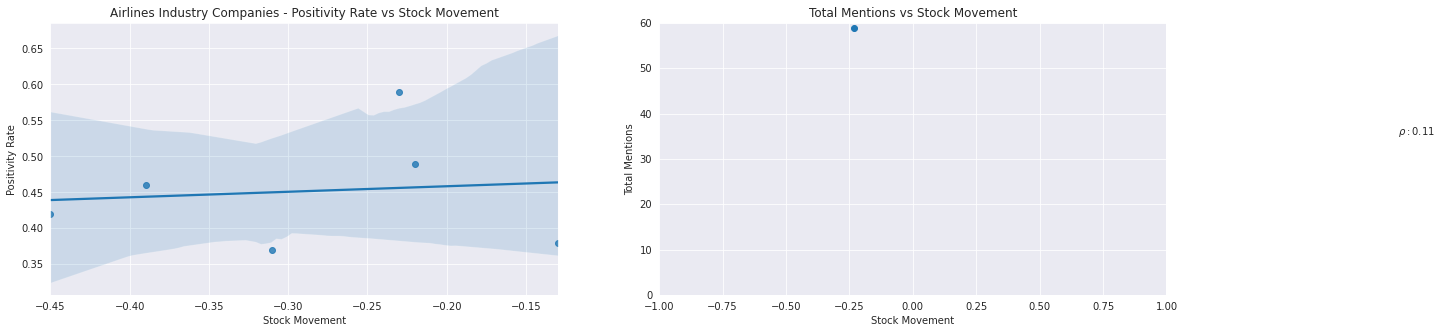

In [212]:
min_articles = 25
plot_data = df_top_sent_comp[df_top_sent_comp['Total'] >= min_articles]
print(len(plot_data))
plot_data = plot_data[plot_data['stock_mvmt'].between(plot_data['stock_mvmt'].quantile(.1), plot_data['stock_mvmt'].quantile(.90))] 
print(len(plot_data))
corr = round(np.corrcoef(plot_data['POS_%'], plot_data['stock_mvmt']).flatten()[1],2)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
#ax1.scatter(x="stock_mvmt", y="POS_%", data=plot_data)
sns.regplot(x="stock_mvmt", y="POS_%", data=plot_data, ax=ax1)
ax2.scatter(x="stock_mvmt", y="Total", data=plot_data)
#ax1.set_xlim(-1,1)
ax2.set_ylim(bottom=0, top=60)
ax2.set_xlim(-1,1)
ax1.set_xlabel("Stock Movement")
ax2.set_xlabel("Stock Movement")
ax1.set_ylabel("Positivity Rate")
ax2.set_ylabel("Total Mentions")
ax1.set_title("Airlines Industry Companies - Positivity Rate vs Stock Movement")
ax2.set_title("Total Mentions vs Stock Movement")
ax1.text(0.4, 0.53, '$ \\rho: $' + str(corr), bbox=dict(facecolor='white', alpha=0.5))
plt.show()

In [213]:
industry = 'Industrials'
subindustry = 'Airlines'
country = 'United States'
df_top_sent_comp = df_comp[(df_comp['industry'] == industry) & (df_comp['subindustry'] == subindustry) & (df_comp['country'] == country) & df_comp['filtered_names_match'].isin(comp_select)]
df_top_sent_comp = df_top_sent_comp[df_top_sent_comp['topic_score'] > 0.5]
df_top_sent_comp = df_top_sent_comp.explode('topic_label').groupby(['filtered_names_match', 'topic_label', 'sentiment']).count()[['date']].sort_values(by='date', ascending=False)
df_top_sent_comp = df_top_sent_comp.unstack()#.reset_index()
df_top_sent_comp.columns = df_top_sent_comp.columns.droplevel()
df_top_sent_comp.rename_axis(None, inplace=True, axis=1)
df_top_sent_comp['Total'] = df_top_sent_comp.sum(axis=1)
#df_top_sent_comp = df_top_sent_comp.sort_values(by='Total', ascending=False)
df_top_sent_comp[df_top_sent_comp['Total'] >= 10][:30]

NEGATIVE  POSITIVE   Total
filtered_names_match         topic_label                                      
American Airlines Group Inc.                           208.0     114.0   322.0
                             airlines                  657.0     178.0   835.0
                             boeing                     65.0      30.0    95.0
                             case_numbers               16.0       5.0    21.0
                             cashay_updates              6.0       8.0    14.0
                             china                       9.0       2.0    11.0
                             company_specific           13.0       4.0    17.0
                             cost_cutting               64.0       9.0    73.0
                             covid                     214.0      50.0   264.0
                             covid_stimulus             11.0       2.0    13.0
                             finance                  1045.0     402.0  1447.0
                             flight_cuts                64.0       9.0    73.0
                             flights_suspended          52.0       6.0    58.0
                             ge_aviationboeing          10.0       3.0    13.0
                             general_stock_updates     109.0     104.0   213.0
                             general_updates             6.0       6.0    12.0
                             hotels                      5.0       6.0    11.0
                             nytimes_updates            35.0       2.0    37.0
                             other                      43.0       5.0    48.0
                             redundancies               26.0       5.0    31.0
                             robinhood_app               8.0       6.0    14.0
                             safety_measures            88.0      12.0   100.0
                             unemployment               31.0       5.0    36.0
                             us                         56.0      11.0    67.0
                             us_shares                  53.0      35.0    88.0
                             us_stock_updates           40.0      25.0    65.0
                             us_stocks_down             15.0       NaN    15.0
                             warren_buffett             31.0       7.0    38.0
Delta Air Lines, Inc.                                  110.0      60.0   170.0
                             airlines                  401.0      84.0   485.0

### Consumer Staples - Food Products

In [214]:
industry = 'Consumer Staples'
subindustry = 'Food Products'
country = 'United States'
df_top_sent_comp = df_comp[(df_comp['industry'] == industry) & (df_comp['subindustry'] == subindustry) & (df_comp['country'] == country)]
#df_top_sent_comp = df_top_sent_comp.groupby(['filtered_names_match', 'sentiment']).count()[['date']].sort_values(by='date', ascending=False)
df_top_sent_comp = df_top_sent_comp.groupby(['filtered_names_match', 'roberta']).count()[['date']].sort_values(by='date', ascending=False)
df_top_sent_comp = df_top_sent_comp.unstack()#.reset_index()
df_top_sent_comp = df_top_sent_comp.fillna(0)
df_top_sent_comp.columns = df_top_sent_comp.columns.droplevel()
df_top_sent_comp.rename_axis(None, inplace=True, axis=1)
df_top_sent_comp['Total'] = df_top_sent_comp.sum(axis=1)
df_top_sent_comp = df_top_sent_comp.sort_values(by='Total', ascending=False)
comp_select = df_top_sent_comp.index[:5]
df_top_sent_comp['POS_%'] = round(df_top_sent_comp['POSITIVE'] / df_top_sent_comp['Total'],2)
df_top_sent_comp['ticker'] =  df_top_sent_comp.index.map(comp_ticker_dict)
df_top_sent_comp['stock_mvmt'] = df_top_sent_comp['ticker'].map(stock_final_mvmt_dict)
df_top_sent_comp = df_top_sent_comp[df_top_sent_comp['stock_mvmt'].notna()]
df_top_sent_comp[df_top_sent_comp['Total'] >= 10].sort_values(by="POS_%", ascending=False)[:20]

NEGATIVE  POSITIVE  Total  POS_% ticker  \
filtered_names_match                                                      
The Simply Good Foods Company        0.0      10.0   10.0   1.00   SMPL   
Ingredion Incorporated               1.0      25.0   26.0   0.96   INGR   
Landec Corporation                   1.0      10.0   11.0   0.91   LNDC   
Lancaster Colony Corporation         1.0       9.0   10.0   0.90   LANC   
Flowers Foods, Inc.                  2.0      16.0   18.0   0.89    FLO   
B&G Foods, Inc.                      5.0      39.0   44.0   0.89    BGS   
TreeHouse Foods, Inc.                2.0      15.0   17.0   0.88    THS   
Conagra Brands, Inc.                 6.0      31.0   37.0   0.84    CAG   
Hormel Foods Corporation             9.0      45.0   54.0   0.83    HRL   
Cal-Maine Foods, Inc.                4.0      18.0   22.0   0.82   CALM   
The Hain Celestial Group, Inc.       7.0      33.0   40.0   0.82   HAIN   
Archer-Daniels-Midland Company      18.0      75.0   93.0   0.81    ADM   
Darling Ingredients Inc.             2.0       8.0   10.0   0.80    DAR   
Calavo Growers, Inc.                 2.0       8.0   10.0   0.80   CVGW   
The J. M. Smucker Company            4.0      12.0   16.0   0.75    SJM   
Kellogg Company                     33.0      95.0  128.0   0.74      K   
The Kraft Heinz Company             51.0     135.0  186.0   0.73    KHC   
Mondelez International, Inc.        33.0      80.0  113.0   0.71   MDLZ   
Campbell Soup Company               24.0      60.0   84.0   0.71    CPB   
General Mills, Inc.                 64.0     147.0  211.0   0.70    GIS   

                                stock_mvmt  
filtered_names_match                        
The Simply Good Foods Company         0.10  
Ingredion Incorporated               -0.13  
Landec Corporation                   -0.04  
Lancaster Colony Corporation          0.17  
Flowers Foods, Inc.                   0.08  
B&G Foods, Inc.                       0.70  
TreeHouse Foods, Inc.                -0.12  
Conagra Brands, Inc.                  0.09  
Hormel Foods Corporation              0.05  
Cal-Maine Foods, Inc.                -0.12  
The Hain Celestial Group, Inc.        0.55  
Archer-Daniels-Midland Company        0.12  
Darling Ingredients Inc.              1.05  
Calavo Growers, Inc.                 -0.22  
The J. M. Smucker Company             0.15  
Kellogg Company                      -0.07  
The Kraft Heinz Company               0.14  
Mondelez International, Inc.          0.09  
Campbell Soup Company                 0.01  
General Mills, Inc.                   0.14

18
14


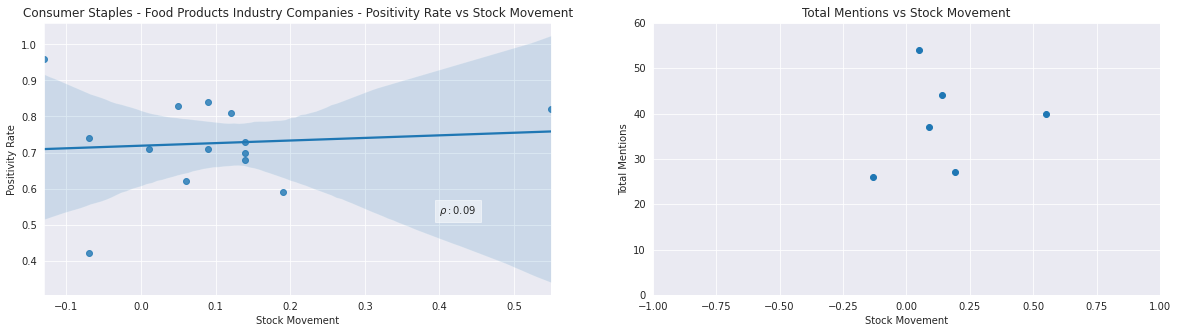

In [215]:
min_articles = 25
plot_data = df_top_sent_comp[df_top_sent_comp['Total'] >= min_articles]
print(len(plot_data))
plot_data = plot_data[plot_data['stock_mvmt'].between(plot_data['stock_mvmt'].quantile(.1), plot_data['stock_mvmt'].quantile(.90))] 
print(len(plot_data))
corr = round(np.corrcoef(plot_data['POS_%'], plot_data['stock_mvmt']).flatten()[1],2)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
#ax1.scatter(x="stock_mvmt", y="POS_%", data=plot_data)
sns.regplot(x="stock_mvmt", y="POS_%", data=plot_data, ax=ax1)
ax2.scatter(x="stock_mvmt", y="Total", data=plot_data)
#ax1.set_xlim(-1,1)
ax2.set_ylim(bottom=0, top=60)
ax2.set_xlim(-1,1)
ax1.set_xlabel("Stock Movement")
ax2.set_xlabel("Stock Movement")
ax1.set_ylabel("Positivity Rate")
ax2.set_ylabel("Total Mentions")
ax1.set_title("Consumer Staples - Food Products Industry Companies - Positivity Rate vs Stock Movement")
ax2.set_title("Total Mentions vs Stock Movement")
ax1.text(0.4, 0.53, '$ \\rho: $' + str(corr), bbox=dict(facecolor='white', alpha=0.5))
plt.show()

### Consumer Staples - Food Products - Australia

In [216]:
industry = 'Consumer Staples'
#subindustry = 'Food Products'
country = 'Australia'
df_top_sent_comp = df_comp[(df_comp['industry'] == industry) & (df_comp['country'] == country)]
#df_top_sent_comp = df_top_sent_comp.groupby(['filtered_names_match', 'sentiment']).count()[['date']].sort_values(by='date', ascending=False)
df_top_sent_comp = df_top_sent_comp.groupby(['filtered_names_match', 'roberta']).count()[['date']].sort_values(by='date', ascending=False)
df_top_sent_comp = df_top_sent_comp.unstack()#.reset_index()
df_top_sent_comp = df_top_sent_comp.fillna(0)
df_top_sent_comp.columns = df_top_sent_comp.columns.droplevel()
df_top_sent_comp.rename_axis(None, inplace=True, axis=1)
df_top_sent_comp['Total'] = df_top_sent_comp.sum(axis=1)
df_top_sent_comp = df_top_sent_comp.sort_values(by='Total', ascending=False)
comp_select = df_top_sent_comp.index[:5]
df_top_sent_comp['POS_%'] = round(df_top_sent_comp['POSITIVE'] / df_top_sent_comp['Total'],2)
df_top_sent_comp['ticker'] =  df_top_sent_comp.index.map(comp_ticker_dict)
df_top_sent_comp['stock_mvmt'] = df_top_sent_comp['ticker'].map(stock_final_mvmt_au_dict)
df_top_sent_comp = df_top_sent_comp[df_top_sent_comp['stock_mvmt'].notna()]
df_top_sent_comp#[df_top_sent_comp['Total'] >= 10].sort_values(by="POS_%", ascending=False)[:20]

NEGATIVE  POSITIVE  Total  POS_%  \
filtered_names_match                                                        
Woolworths Group Limited                      8.0      11.0   19.0   0.58   
Elders Limited                                3.0      11.0   14.0   0.79   
Coles Group Limited                           6.0       7.0   13.0   0.54   
Costa Group Holdings Limited                  5.0       4.0    9.0   0.44   
Inghams Group Limited                         0.0       2.0    2.0   1.00   
Australian Agricultural Company Limited       2.0       0.0    2.0   0.00   
Freedom Foods Group Limited                   1.0       1.0    2.0   0.50   
GrainCorp Limited                             0.0       1.0    1.0   1.00   
Clean Seas Seafood Limited                    0.0       1.0    1.0   1.00   
Ridley Corporation Limited                    0.0       1.0    1.0   1.00   
Bega Cheese Limited                           0.0       1.0    1.0   1.00   

                                        ticker  stock_mvmt  
filtered_names_match                                        
Woolworths Group Limited                   WOW        0.11  
Elders Limited                             ELD        0.56  
Coles Group Limited                        COL        0.27  
Costa Group Holdings Limited               CGC        0.68  
Inghams Group Limited                      ING       -0.03  
Australian Agricultural Company Limited    AAC        0.00  
Freedom Foods Group Limited                FNP       -0.41  
GrainCorp Limited                          GNC       -0.44  
Clean Seas Seafood Limited                 CSS        0.06  
Ridley Corporation Limited                 RIC       -0.11  
Bega Cheese Limited                        BGA        0.21

11
9


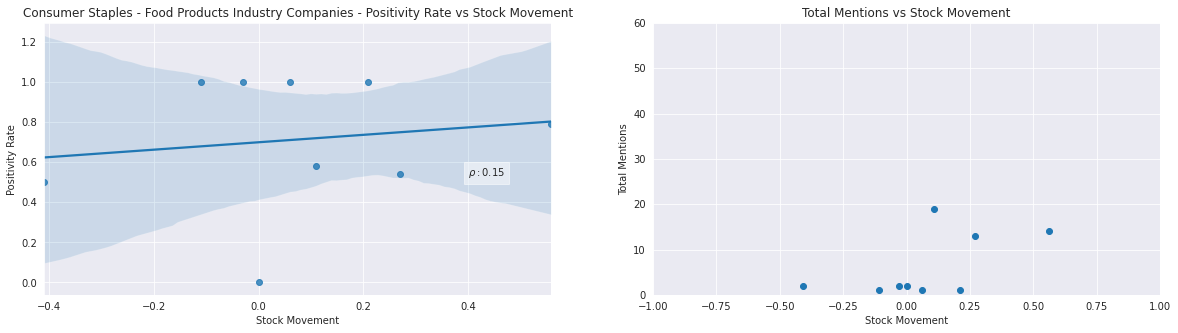

In [220]:
min_articles = 1
plot_data = df_top_sent_comp[df_top_sent_comp['Total'] >= min_articles]
print(len(plot_data))
plot_data = plot_data[plot_data['stock_mvmt'].between(plot_data['stock_mvmt'].quantile(.1), plot_data['stock_mvmt'].quantile(.90))] 
print(len(plot_data))
corr = round(np.corrcoef(plot_data['POS_%'], plot_data['stock_mvmt']).flatten()[1],2)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
#ax1.scatter(x="stock_mvmt", y="POS_%", data=plot_data)
sns.regplot(x="stock_mvmt", y="POS_%", data=plot_data, ax=ax1)
ax2.scatter(x="stock_mvmt", y="Total", data=plot_data)
#ax1.set_xlim(-1,1)
ax2.set_ylim(bottom=0, top=60)
ax2.set_xlim(-1,1)
ax1.set_xlabel("Stock Movement")
ax2.set_xlabel("Stock Movement")
ax1.set_ylabel("Positivity Rate")
ax2.set_ylabel("Total Mentions")
ax1.set_title("Consumer Staples - Food Products Industry Companies - Positivity Rate vs Stock Movement")
ax2.set_title("Total Mentions vs Stock Movement")
ax1.text(0.4, 0.53, '$ \\rho: $' + str(corr), bbox=dict(facecolor='white', alpha=0.5))
plt.show()

# Companies

## Positivity Rate & Topics

Investigate topics associated with selected companies

In [221]:
#companies_list[(companies_list['country'] == 'United States') & (companies_list['subindustry'] == 'Airlines')]

1078


NEGATIVE  POSITIVE  Total  POS_%
topic_label                                            
airlines                    461       244    705   0.35
safety_measures              75        18     93   0.19
general_stock_updates        37        52     89   0.58
boeing                       51        36     87   0.41
cost_cutting                 49        19     68   0.28

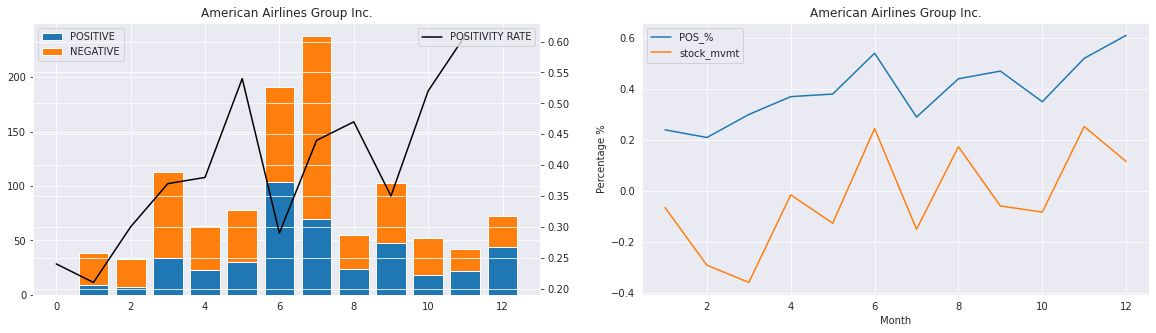

In [223]:
selection = 'American Airlines Group Inc.'
df_selection = df_comp[(df_comp['filtered_names_match'] == selection) & (df_comp['company_relevance'] >= 0.2) & (df_comp['primary_topic'] == 'finance')]
print(len(df_selection))

df_comp_analysis = df_selection.pivot_table(index='month', columns='roberta', values='date', aggfunc='count', fill_value=0)
df_comp_analysis['Total'] = df_comp_analysis.sum(axis=1)
df_comp_analysis['POS_%'] = round(df_comp_analysis['POSITIVE'] / df_comp_analysis['Total'],2)

ticker = comp_ticker_dict[selection]
stock_mvmt_analysis = stock_final.loc[ticker].pct_change()[1:13]
stock_mvmt_analysis.index = [1,2,3,4,5,6,7,8,9,10,11,12]

df_comp_analysis['stock_mvmt'] = stock_mvmt_analysis
df_comp_analysis = df_comp_analysis.reset_index()
#display(df_comp_analysis)

fig,(ax1, ax2) = plt.subplots(1,2, figsize=(20,5))

ax1.bar('month', 'POSITIVE', label='POSITIVE', data=df_comp_analysis)
ax1.bar('month', 'NEGATIVE', bottom='POSITIVE', label='NEGATIVE', data=df_comp_analysis)
ax1.legend(loc='upper left', labels=['POSITIVE', 'NEGATIVE'])
ax1_2 = ax1.twinx()
ax1_2.plot('POS_%', label='POSITIVITY RATE', color='black', data=df_comp_analysis)
ax1_2.legend(loc='upper right')
ax1.set_title(selection)

ax2.plot('month', 'POS_%', data=df_comp_analysis)
ax2.plot('month', 'stock_mvmt', data=df_comp_analysis)
ax2.set_xlabel("Month")
ax2.set_ylabel("Percentage %")
ax2.legend()
ax2.set_title(selection)
None

primary_topics = set(df_comp['primary_topic'].explode())
secondary_topics = df_selection.explode('topic_label', ignore_index=True)
secondary_topics = secondary_topics[~secondary_topics['topic_label'].isin(primary_topics)]
secondary_topics = secondary_topics.pivot_table(index='topic_label', columns='roberta', values='date', aggfunc='count', fill_value=0)
secondary_topics['Total'] = secondary_topics.sum(axis=1)
secondary_topics['POS_%'] = round(secondary_topics['POSITIVE'] / secondary_topics['Total'],2)
secondary_topics.columns = secondary_topics.columns.values
display(secondary_topics.sort_values('Total', ascending=False).head(5))

473


NEGATIVE  POSITIVE  Total  POS_%
topic_label                                      
airlines              230       111    341   0.33
safety_measures        44        14     58   0.24
boeing                 31        16     47   0.34
cost_cutting           29         8     37   0.22
flight_cuts            29         8     37   0.22

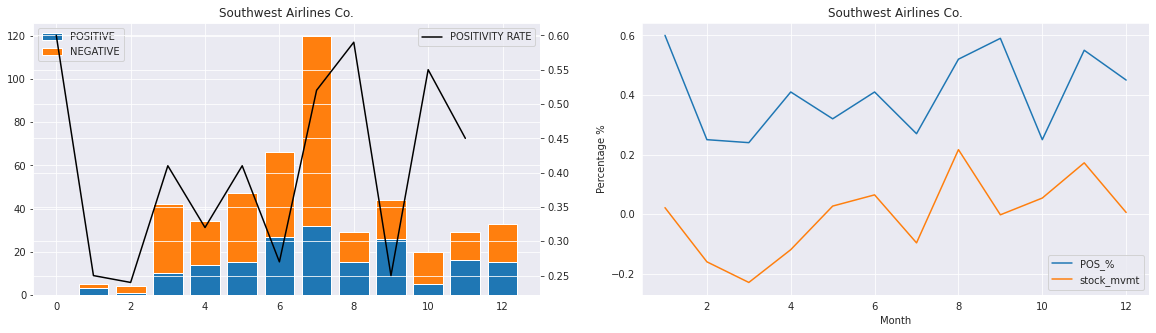

In [224]:
selection = 'Southwest Airlines Co.'
df_selection = df_comp[(df_comp['filtered_names_match'] == selection) & (df_comp['company_relevance'] >= 0.2) & (df_comp['primary_topic'] == 'finance')]
print(len(df_selection))

df_comp_analysis = df_selection.pivot_table(index='month', columns='roberta', values='date', aggfunc='count', fill_value=0)
df_comp_analysis['Total'] = df_comp_analysis.sum(axis=1)
df_comp_analysis['POS_%'] = round(df_comp_analysis['POSITIVE'] / df_comp_analysis['Total'],2)

ticker = comp_ticker_dict[selection]
stock_mvmt_analysis = stock_final.loc[ticker].pct_change()[1:13]
stock_mvmt_analysis.index = [1,2,3,4,5,6,7,8,9,10,11,12]

df_comp_analysis['stock_mvmt'] = stock_mvmt_analysis
df_comp_analysis = df_comp_analysis.reset_index()
#display(df_comp_analysis)

fig,(ax1, ax2) = plt.subplots(1,2, figsize=(20,5))

ax1.bar('month', 'POSITIVE', label='POSITIVE', data=df_comp_analysis)
ax1.bar('month', 'NEGATIVE', bottom='POSITIVE', label='NEGATIVE', data=df_comp_analysis)
ax1.legend(loc='upper left', labels=['POSITIVE', 'NEGATIVE'])
ax1_2 = ax1.twinx()
ax1_2.plot('POS_%', label='POSITIVITY RATE', color='black', data=df_comp_analysis)
ax1_2.legend(loc='upper right')
ax1.set_title(selection)

ax2.plot('month', 'POS_%', data=df_comp_analysis)
ax2.plot('month', 'stock_mvmt', data=df_comp_analysis)
ax2.set_xlabel("Month")
ax2.set_ylabel("Percentage %")
ax2.legend()
ax2.set_title(selection)
None

primary_topics = set(df_comp['primary_topic'].explode())
secondary_topics = df_selection.explode('topic_label', ignore_index=True)
secondary_topics = secondary_topics[~secondary_topics['topic_label'].isin(primary_topics)]
secondary_topics = secondary_topics.pivot_table(index='topic_label', columns='roberta', values='date', aggfunc='count', fill_value=0)
secondary_topics['Total'] = secondary_topics.sum(axis=1)
secondary_topics['POS_%'] = round(secondary_topics['POSITIVE'] / secondary_topics['Total'],2)
secondary_topics.columns = secondary_topics.columns.values
display(secondary_topics.sort_values('Total', ascending=False).head(5))

277


NEGATIVE  POSITIVE  Total  POS_%
topic_label                                            
nvidia                       11        78     89   0.88
amd                          11        78     89   0.88
microprocessor               11        78     89   0.88
general_stock_updates        10        43     53   0.81
us_shares                     6        24     30   0.80

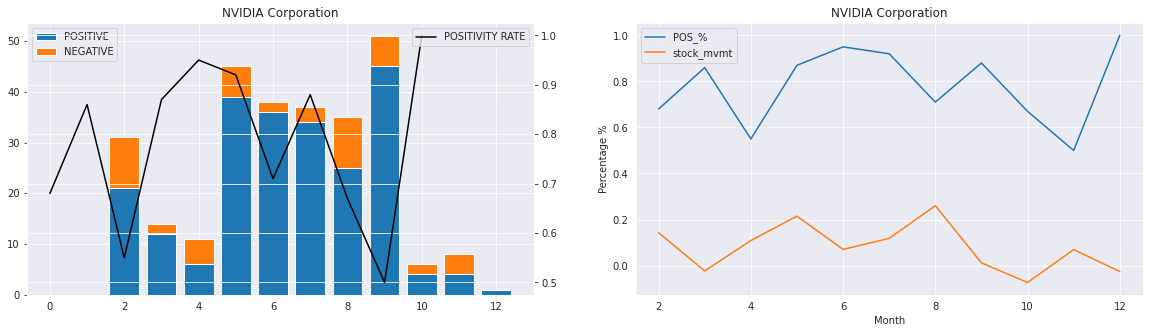

In [235]:
selection = 'NVIDIA Corporation'
df_selection = df_comp[(df_comp['filtered_names_match'] == selection) & (df_comp['company_relevance'] >= 0.2) & (df_comp['primary_topic'] == 'finance')]
print(len(df_selection))

df_comp_analysis = df_selection.pivot_table(index='month', columns='roberta', values='date', aggfunc='count', fill_value=0)
df_comp_analysis['Total'] = df_comp_analysis.sum(axis=1)
df_comp_analysis['POS_%'] = round(df_comp_analysis['POSITIVE'] / df_comp_analysis['Total'],2)

ticker = comp_ticker_dict[selection]
stock_mvmt_analysis = stock_final.loc[ticker].pct_change()[1:13]
stock_mvmt_analysis.index = [1,2,3,4,5,6,7,8,9,10,11,12]

df_comp_analysis['stock_mvmt'] = stock_mvmt_analysis
df_comp_analysis = df_comp_analysis.reset_index()
#display(df_comp_analysis)

fig,(ax1, ax2) = plt.subplots(1,2, figsize=(20,5))

ax1.bar('month', 'POSITIVE', label='POSITIVE', data=df_comp_analysis)
ax1.bar('month', 'NEGATIVE', bottom='POSITIVE', label='NEGATIVE', data=df_comp_analysis)
ax1.legend(loc='upper left', labels=['POSITIVE', 'NEGATIVE'])
ax1_2 = ax1.twinx()
ax1_2.plot('POS_%', label='POSITIVITY RATE', color='black', data=df_comp_analysis)
ax1_2.legend(loc='upper right')
ax1.set_title(selection)

ax2.plot('month', 'POS_%', data=df_comp_analysis)
ax2.plot('month', 'stock_mvmt', data=df_comp_analysis)
ax2.set_xlabel("Month")
ax2.set_ylabel("Percentage %")
ax2.legend()
ax2.set_title(selection)
None

primary_topics = set(df_comp['primary_topic'].explode())
secondary_topics = df_selection.explode('topic_label', ignore_index=True)
secondary_topics = secondary_topics[~secondary_topics['topic_label'].isin(primary_topics)]
secondary_topics = secondary_topics.pivot_table(index='topic_label', columns='roberta', values='date', aggfunc='count', fill_value=0)
secondary_topics['Total'] = secondary_topics.sum(axis=1)
secondary_topics['POS_%'] = round(secondary_topics['POSITIVE'] / secondary_topics['Total'],2)
secondary_topics.columns = secondary_topics.columns.values
display(secondary_topics.sort_values('Total', ascending=False).head(5))

284


NEGATIVE  POSITIVE  Total  POS_%
topic_label                                        
general_updates          13        82     95   0.86
technavio_updates         8        62     70   0.89
tech_companies           18        29     47   0.62
cloud_services           16        23     39   0.59
remote_working           16        23     39   0.59

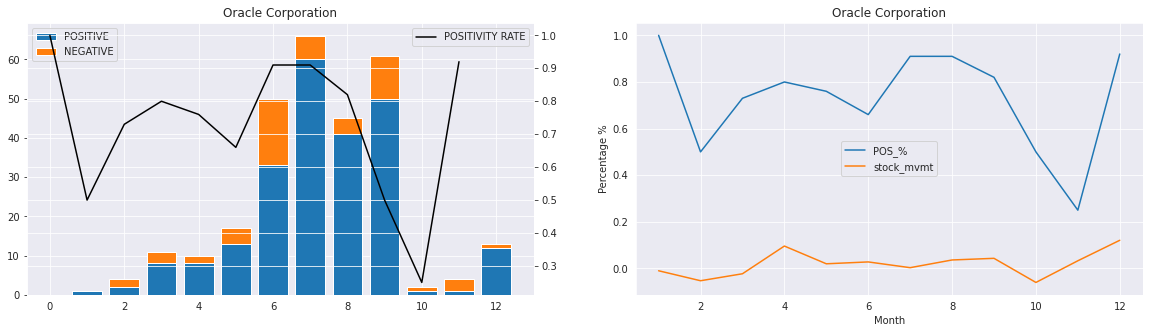

In [236]:
selection = 'Oracle Corporation'
df_selection = df_comp[(df_comp['filtered_names_match'] == selection) & (df_comp['company_relevance'] >= 0.2) & (df_comp['primary_topic'] == 'finance')]
print(len(df_selection))

df_comp_analysis = df_selection.pivot_table(index='month', columns='roberta', values='date', aggfunc='count', fill_value=0)
df_comp_analysis['Total'] = df_comp_analysis.sum(axis=1)
df_comp_analysis['POS_%'] = round(df_comp_analysis['POSITIVE'] / df_comp_analysis['Total'],2)

ticker = comp_ticker_dict[selection]
stock_mvmt_analysis = stock_final.loc[ticker].pct_change()[1:13]
stock_mvmt_analysis.index = [1,2,3,4,5,6,7,8,9,10,11,12]

df_comp_analysis['stock_mvmt'] = stock_mvmt_analysis
df_comp_analysis = df_comp_analysis.reset_index()
#display(df_comp_analysis)

fig,(ax1, ax2) = plt.subplots(1,2, figsize=(20,5))

ax1.bar('month', 'POSITIVE', label='POSITIVE', data=df_comp_analysis)
ax1.bar('month', 'NEGATIVE', bottom='POSITIVE', label='NEGATIVE', data=df_comp_analysis)
ax1.legend(loc='upper left', labels=['POSITIVE', 'NEGATIVE'])
ax1_2 = ax1.twinx()
ax1_2.plot('POS_%', label='POSITIVITY RATE', color='black', data=df_comp_analysis)
ax1_2.legend(loc='upper right')
ax1.set_title(selection)

ax2.plot('month', 'POS_%', data=df_comp_analysis)
ax2.plot('month', 'stock_mvmt', data=df_comp_analysis)
ax2.set_xlabel("Month")
ax2.set_ylabel("Percentage %")
ax2.legend()
ax2.set_title(selection)
None

primary_topics = set(df_comp['primary_topic'].explode())
secondary_topics = df_selection.explode('topic_label', ignore_index=True)
secondary_topics = secondary_topics[~secondary_topics['topic_label'].isin(primary_topics)]
secondary_topics = secondary_topics.pivot_table(index='topic_label', columns='roberta', values='date', aggfunc='count', fill_value=0)
secondary_topics['Total'] = secondary_topics.sum(axis=1)
secondary_topics['POS_%'] = round(secondary_topics['POSITIVE'] / secondary_topics['Total'],2)
secondary_topics.columns = secondary_topics.columns.values
display(secondary_topics.sort_values('Total', ascending=False).head(5))

## Specific Topic Words Mentioned in an Article

In [264]:
keyword = 'supply_chain'
df_kw = df_comp[df_comp['topic_words'].apply(lambda x: keyword in x)]
df_kw = df_kw[df_kw['company_relevance'] >= 0.2]
df_kw_financials = df_kw.pivot_table(index='filtered_names_match', columns='roberta', values='date', aggfunc='count', fill_value=0)
df_kw_financials['Total'] = df_kw_financials.sum(axis=1)
df_kw_financials['POS_%'] = round(df_kw_financials['POSITIVE'] / df_kw_financials['Total'],2)

df_kw_financials = df_kw_financials.reset_index()
df_kw_financials['ticker'] = df_kw_financials['filtered_names_match'].map(comp_ticker_dict)
df_kw_financials['stock_mvmt'] = df_kw_financials['ticker'].map(stock_final_mvmt_dict)
df_kw_financials = df_kw_financials[df_kw_financials['stock_mvmt'].notna()]
df_kw_financials = df_kw_financials[df_kw_financials['Total'] > 5]
df_kw_financials[:10]

roberta             filtered_names_match  NEGATIVE  POSITIVE  Total  POS_%  \
0                   3D Resources Limited         0         6      6   1.00   
1                             3M Company         5         3      8   0.38   
36                            Apple Inc.       115        56    171   0.33   
53                      Ball Corporation         4        26     30   0.87   
54           Bank of America Corporation         7         2      9   0.22   
141                   Ford Motor Company         1         5      6   0.83   
152             General Electric Company         7         3     10   0.30   
153               General Motors Company        16        12     28   0.43   
173      Healthcare Services Group, Inc.         0        22     22   1.00   
179         Honeywell International Inc.         6         9     15   0.60   

roberta ticker  stock_mvmt  
0          DDD        0.20  
1          MMM        0.03  
36        AAPL        0.82  
53         BLL        0.45  
54         BAC       -0.12  
141          F       -0.04  
152         GE       -0.03  
153         GM        0.16  
173       HCSG        0.20  
179        HON        0.23

28
22


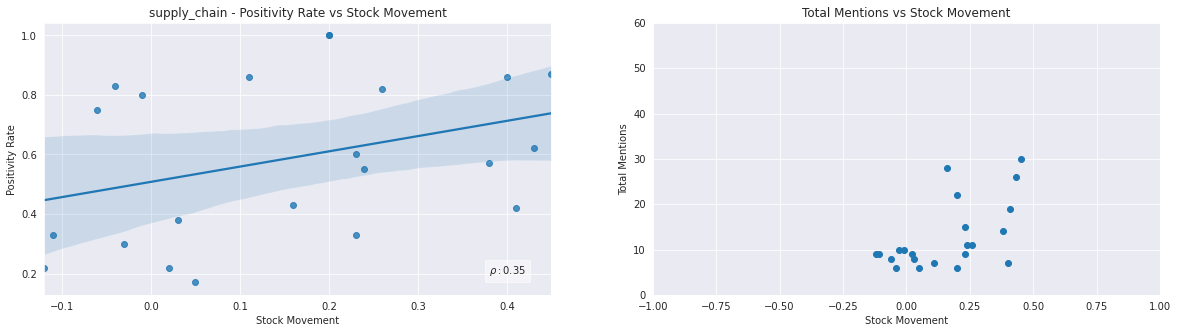

In [263]:
min_articles = 0
plot_data = df_kw_financials[df_kw_financials['Total'] >= min_articles]
print(len(plot_data))
plot_data = plot_data[plot_data['stock_mvmt'].between(plot_data['stock_mvmt'].quantile(.1), plot_data['stock_mvmt'].quantile(.90))] 
print(len(plot_data))
corr = round(np.corrcoef(plot_data['POS_%'], plot_data['stock_mvmt']).flatten()[1],2)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
#ax1.scatter(x="stock_mvmt", y="POS_%", data=plot_data)
sns.regplot(x="stock_mvmt", y="POS_%", data=plot_data, ax=ax1)
ax2.scatter(x="stock_mvmt", y="Total", data=plot_data)
#ax1.set_xlim(-1,1)
ax2.set_ylim(bottom=0, top=60)
ax2.set_xlim(-1,1)
ax1.set_xlabel("Stock Movement")
ax2.set_xlabel("Stock Movement")
ax1.set_ylabel("Positivity Rate")
ax2.set_ylabel("Total Mentions")
ax1.set_title(f'{keyword} - Positivity Rate vs Stock Movement')
ax2.set_title("Total Mentions vs Stock Movement")
ax1.text(0.38, 0.2, '$ \\rho: $' + str(corr), bbox=dict(facecolor='white', alpha=0.5))
plt.show()

sentiment             filtered_names_match  NEGATIVE  POSITIVE  Total  POS_%  \
0                     3D Resources Limited         4        14     18   0.78   
15           AMN Healthcare Services, Inc.         4         5      9   0.56   
27                     Abbott Laboratories         9         4     13   0.31   
30         Acadia Healthcare Company, Inc.         1         6      7   0.86   
36                              Adobe Inc.         6         1      7   0.14   
38                      Aflac Incorporated         3         5      8   0.62   
48                  Align Technology, Inc.         3         6      9   0.67   
55                        Amazon.com, Inc.         4         4      8   0.50   
71           AmerisourceBergen Corporation         1         5      6   0.83   
73                            Anthem, Inc.         2         7      9   0.78   

sentiment ticker  stock_mvmt  
0            DDD        0.20  
15           AMN        0.10  
27           ABT        0.28  
30          ACHC        0.51  
36          ADBE        0.52  
38           AFL       -0.14  
48          ALGN        0.92  
55          AMZN        0.76  
71           ABC        0.17  
73          ANTM        0.08

72
56


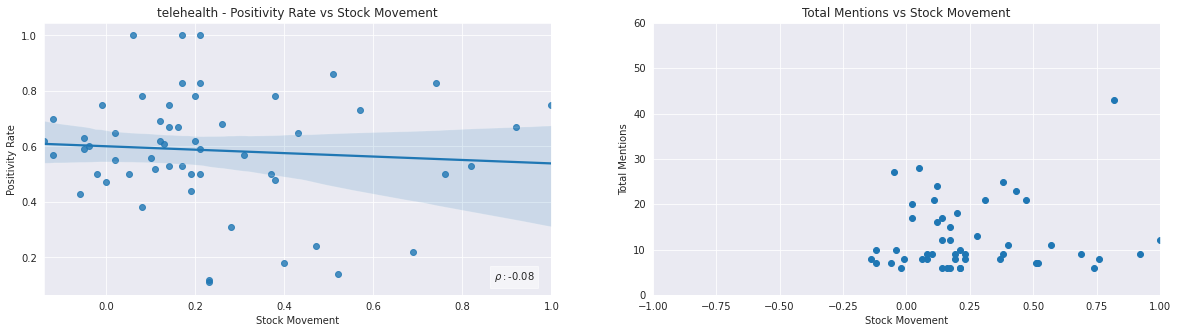

In [327]:
keyword = 'telehealth'
df_kw = df_comp[df_comp['topic_words'].apply(lambda x: keyword in x)]
df_kw = df_kw[df_kw['company_relevance'] >= 0.2]
df_kw_financials = df_kw.pivot_table(index='filtered_names_match', columns='sentiment', values='date', aggfunc='count', fill_value=0)
df_kw_financials['Total'] = df_kw_financials.sum(axis=1)
df_kw_financials['POS_%'] = round(df_kw_financials['POSITIVE'] / df_kw_financials['Total'],2)

df_kw_financials = df_kw_financials.reset_index()
df_kw_financials['ticker'] = df_kw_financials['filtered_names_match'].map(comp_ticker_dict)
df_kw_financials['stock_mvmt'] = df_kw_financials['ticker'].map(stock_final_mvmt_dict)
df_kw_financials = df_kw_financials[df_kw_financials['stock_mvmt'].notna()]
df_kw_financials = df_kw_financials[df_kw_financials['Total'] > 5]
display(df_kw_financials[:10])

min_articles = 0
plot_data = df_kw_financials[df_kw_financials['Total'] >= min_articles]
print(len(plot_data))
plot_data = plot_data[plot_data['stock_mvmt'].between(plot_data['stock_mvmt'].quantile(.1), plot_data['stock_mvmt'].quantile(.90))] 
print(len(plot_data))
corr = round(np.corrcoef(plot_data['POS_%'], plot_data['stock_mvmt']).flatten()[1],2)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
#ax1.scatter(x="stock_mvmt", y="POS_%", data=plot_data)
sns.regplot(x="stock_mvmt", y="POS_%", data=plot_data, ax=ax1)
ax2.scatter(x="stock_mvmt", y="Total", data=plot_data)
#ax1.set_xlim(-1,1)
ax2.set_ylim(bottom=0, top=60)
ax2.set_xlim(-1,1)
ax1.set_xlabel("Stock Movement")
ax2.set_xlabel("Stock Movement")
ax1.set_ylabel("Positivity Rate")
ax2.set_ylabel("Total Mentions")
ax1.set_title(f'{keyword} - Positivity Rate vs Stock Movement')
ax2.set_title("Total Mentions vs Stock Movement")
ax1.text(0.87, 0.12, '$ \\rho: $' + str(corr), bbox=dict(facecolor='white', alpha=0.5))
plt.show()

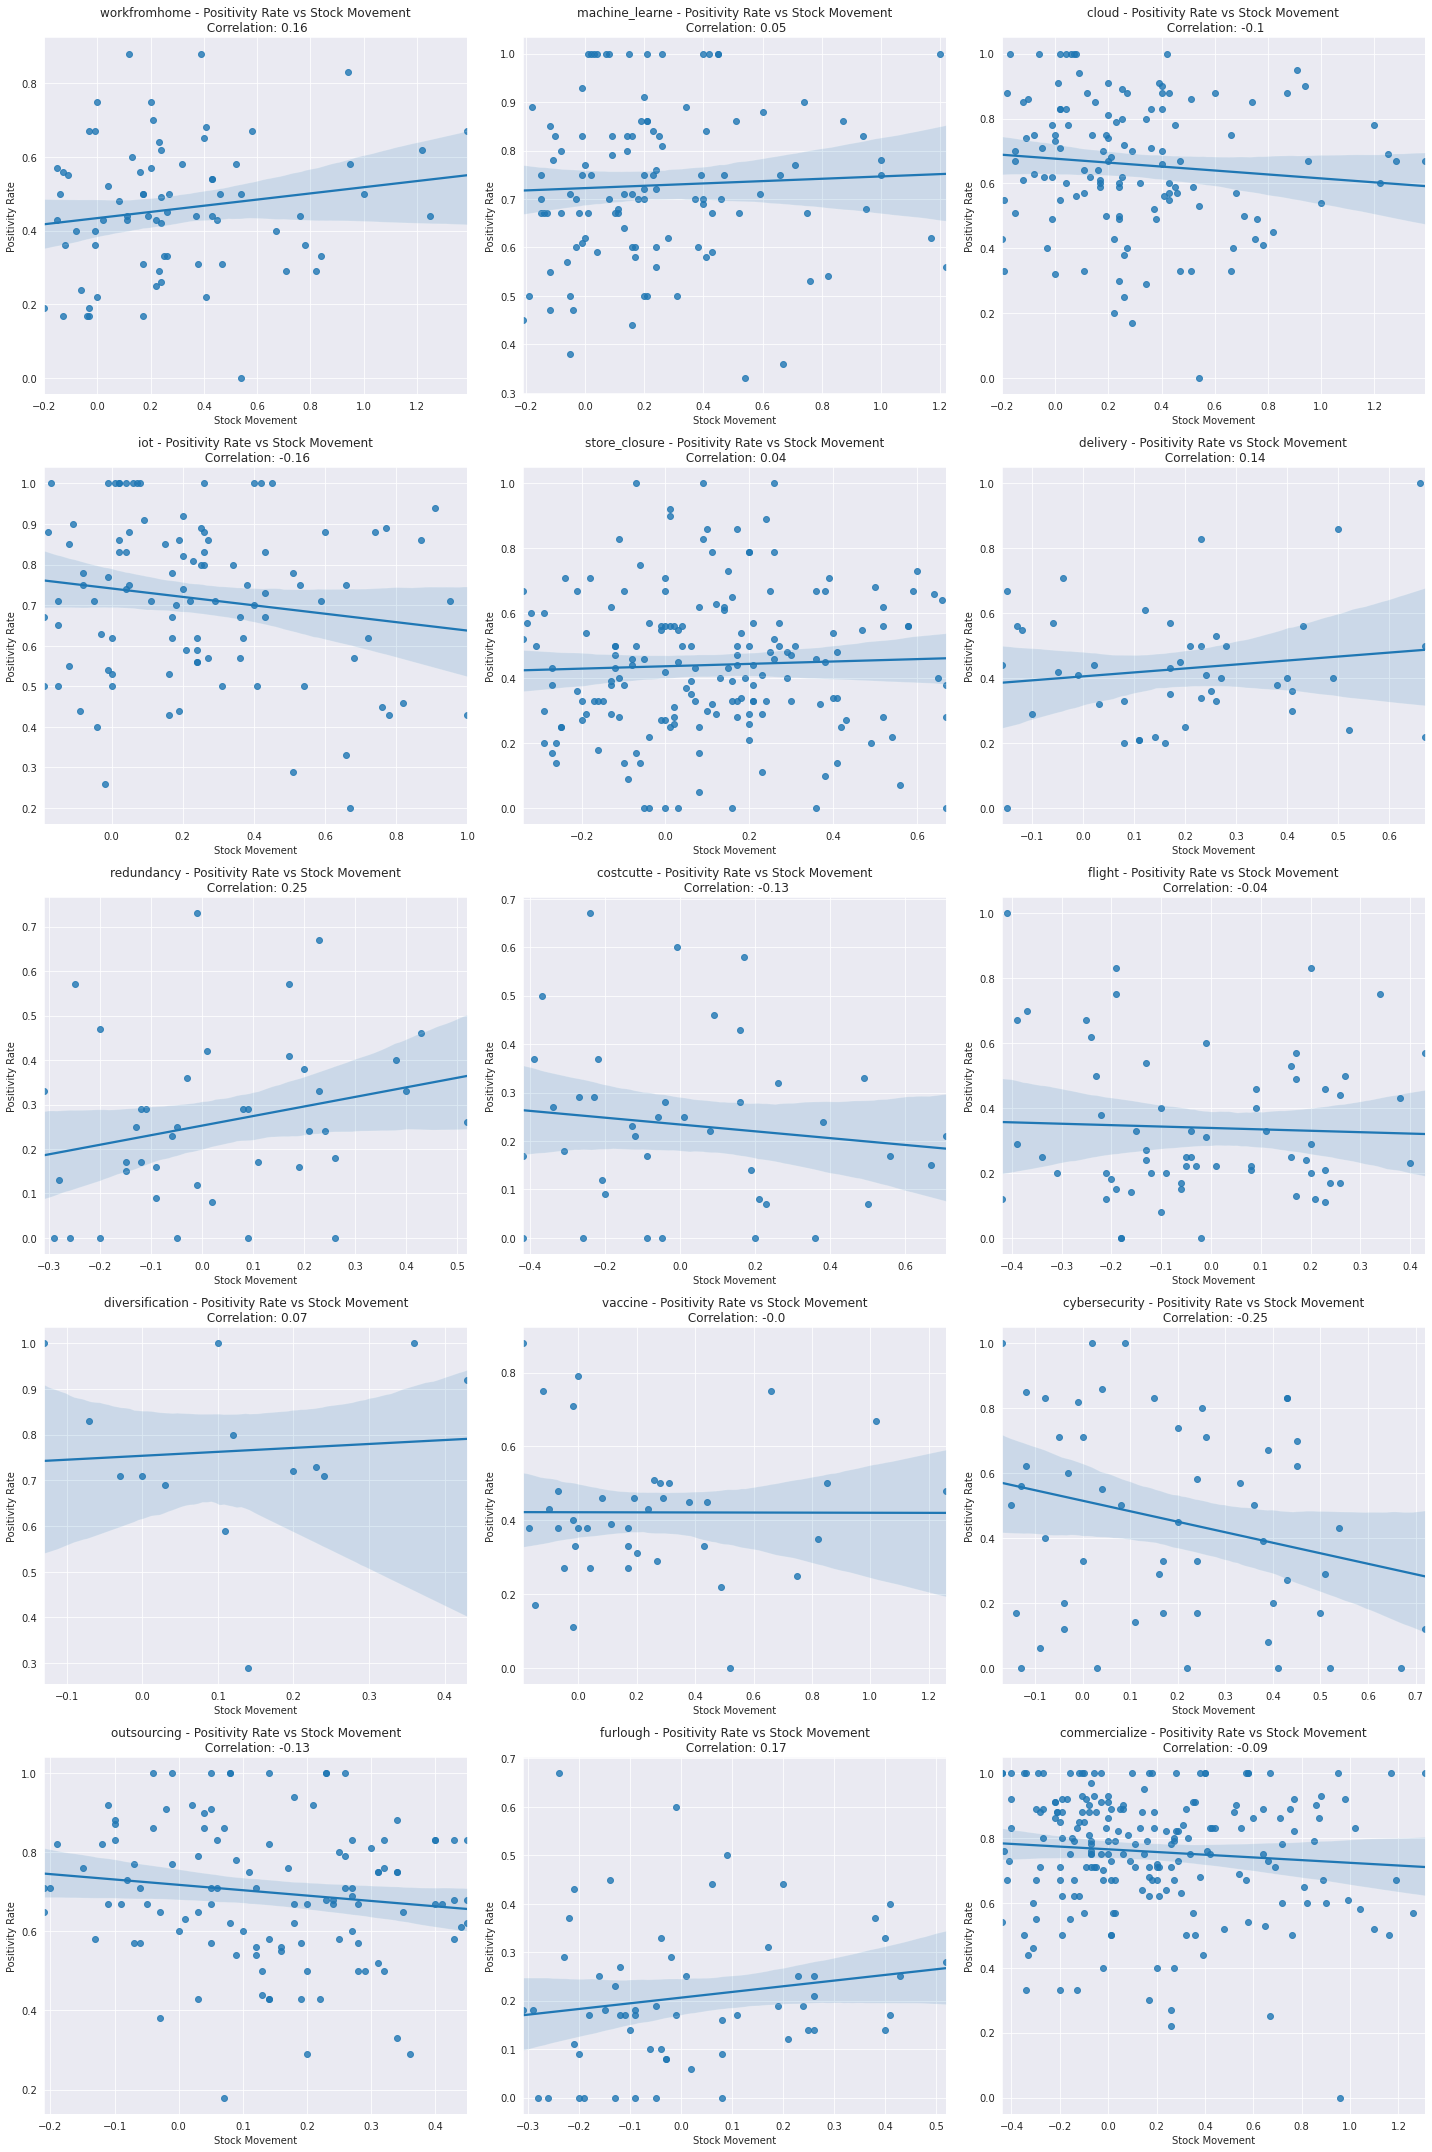

In [350]:
keywords = ['workfromhome', 'machine_learne', 'cloud', 'iot', 'store_closure', 'delivery', 'redundancy', 'costcutte', 'flight',
            'diversification', 'vaccine', 'cybersecurity', 'outsourcing', 'furlough', 'commercialize']

sns.set_style("darkgrid",)
fig, ax = plt.subplots(5,3, figsize=(20,30), sharey=False)
ax = ax.flatten()
#ax[11].axis('off')

for idx, keyword in enumerate(keywords):
    df_kw = df_comp[df_comp['topic_words'].apply(lambda x: keyword in x)]
    df_kw = df_kw[df_kw['company_relevance'] >= 0.2]
    df_kw_financials = df_kw.pivot_table(index='filtered_names_match', columns='sentiment', values='date', aggfunc='count', fill_value=0)
    df_kw_financials['Total'] = df_kw_financials.sum(axis=1)
    df_kw_financials['POS_%'] = round(df_kw_financials['POSITIVE'] / df_kw_financials['Total'],2)

    df_kw_financials = df_kw_financials.reset_index()
    df_kw_financials['ticker'] = df_kw_financials['filtered_names_match'].map(comp_ticker_dict)
    df_kw_financials['stock_mvmt'] = df_kw_financials['ticker'].map(stock_final_mvmt_dict)
    df_kw_financials = df_kw_financials[df_kw_financials['stock_mvmt'].notna()]
    df_kw_financials = df_kw_financials[df_kw_financials['Total'] > 5]
    #display(df_kw_financials[:10].sort_values('POS_%'))

    min_articles = 0
    plot_data = df_kw_financials[df_kw_financials['Total'] >= min_articles]
    #print(len(plot_data))
    plot_data = plot_data[plot_data['stock_mvmt'].between(plot_data['stock_mvmt'].quantile(.1), plot_data['stock_mvmt'].quantile(.90))] 
    #print(len(plot_data))
    corr = round(np.corrcoef(plot_data['POS_%'], plot_data['stock_mvmt']).flatten()[1],2)
    #print(corr)

    sns.regplot(x="stock_mvmt", y="POS_%", data=plot_data, ax=ax[idx])
    ax[idx].set_xlabel("Stock Movement")
    ax[idx].set_ylabel("Positivity Rate")
    ax[idx].set_title(f'{keyword} - Positivity Rate vs Stock Movement\n Correlation: {corr}')
    #ax[idx].text(1, 0.3, '$ \\rho: $' + str(corr), bbox=dict(facecolor='white', alpha=0.5))
plt.tight_layout()
plt.savefig('topic_words_cor.png')

## Topics - Manual Defined

### Average Document

In [282]:
df_topics_manual.columns

Index(['author', 'date', 'domain', 'title', 'url', 'content', 'topic_area',
       'content_processed', 'content_lemma', 'doc_embedding', 'blockchain',
       'digitization', 'machine_learne', 'cloud', 'iot', 'store_closure',
       'delivery', 'redundancy', 'costcutte', 'flight', 'supply_chain',
       'shutdown', 'outsourcing', 'workfromhome', 'diversification',
       'blockchain_word', 'digitization_word', 'machine_learne_word',
       'cloud_word', 'iot_word', 'store_closure_word', 'delivery_word',
       'redundancy_word', 'costcutte_word', 'flight_word', 'supply_chain_word',
       'shutdown_word', 'outsourcing_word', 'workfromhome_word',
       'diversification_word', 'vaccines_word', 'drug_discovery_word',
       'tele_health_word', 'cybersecurity_word'],
      dtype='object')

sentiment                           NEGATIVE  POSITIVE  Total  POS_% ticker  \
filtered_names_match                                                          
Microsoft Corporation                      6        46     52   0.88   MSFT   
Nasdaq, Inc.                               9        37     46   0.80   NDAQ   
Information Services Group, Inc.           9        23     32   0.72    III   
Healthcare Services Group, Inc.            5        26     31   0.84   HCSG   
3D Resources Limited                       1        13     14   0.93    DDD   
Oracle Corporation                         1        13     14   0.93   ORCL   
Hewlett Packard Enterprise Company         4         9     13   0.69    HPE   
VMware, Inc.                               2        11     13   0.85    VMW   
SMART Global Holdings, Inc.                3         9     12   0.75    SGH   
Service Corporation International          2        10     12   0.83    SCI   
Cisco Systems, Inc.                        0        10     10   1.00   CSCO   
Honeywell International Inc.               2         8     10   0.80    HON   

sentiment                           stock_mvmt  
filtered_names_match                            
Microsoft Corporation                     0.43  
Nasdaq, Inc.                              0.26  
Information Services Group, Inc.          0.40  
Healthcare Services Group, Inc.           0.20  
3D Resources Limited                      0.20  
Oracle Corporation                        0.24  
Hewlett Packard Enterprise Company       -0.22  
VMware, Inc.                             -0.08  
SMART Global Holdings, Inc.              -0.01  
Service Corporation International         0.09  
Cisco Systems, Inc.                      -0.03  
Honeywell International Inc.              0.23

12
8
-0.12


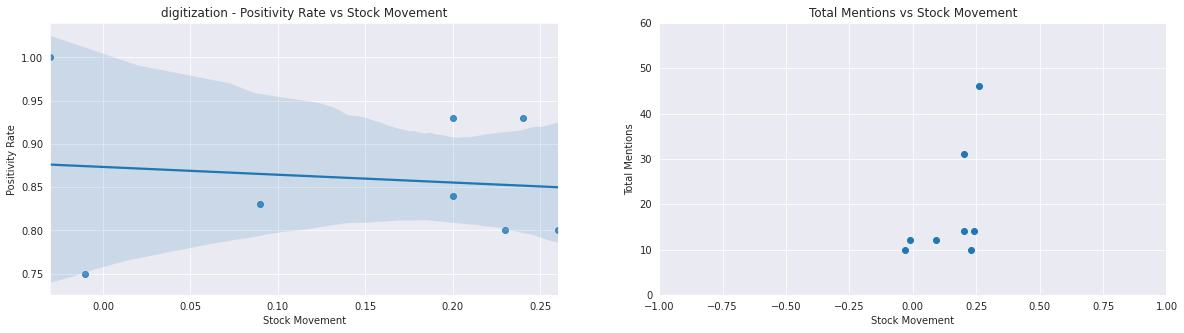

In [294]:
topic = 'digitization'
df_top_sent = df_comp[df_comp['company_relevance'] >= 0.2]
df_top_sent = df_top_sent.sort_values(by=topic)[:1000]
df_top_sent = df_top_sent[df_top_sent['filtered_names_match'].notna()]
df_top_sent = df_top_sent.pivot_table(index=['filtered_names_match'], columns=['sentiment'], values='date', aggfunc='count', fill_value=0)
df_top_sent['Total'] = df_top_sent.sum(axis=1)
df_top_sent = df_top_sent.sort_values(by='Total', ascending=False)
df_top_sent['POS_%'] = round(df_top_sent['POSITIVE'] / df_top_sent['Total'],2)
df_top_sent['ticker'] =  df_top_sent.index.map(comp_ticker_dict)
df_top_sent['stock_mvmt'] = df_top_sent['ticker'].map(stock_final_mvmt_dict)
df_top_sent = df_top_sent[df_top_sent['stock_mvmt'].notna()]
df_top_sent = df_top_sent[df_top_sent['Total'] >= 10]
display(df_top_sent)

min_articles = 0
plot_data = df_top_sent[df_top_sent['Total'] >= min_articles]
print(len(plot_data))
plot_data = plot_data[plot_data['stock_mvmt'].between(plot_data['stock_mvmt'].quantile(.1), plot_data['stock_mvmt'].quantile(.90))] 
print(len(plot_data))
corr = round(np.corrcoef(plot_data['POS_%'], plot_data['stock_mvmt']).flatten()[1],2)
print(corr)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
#ax1.scatter(x="stock_mvmt", y="POS_%", data=plot_data)
sns.regplot(x="stock_mvmt", y="POS_%", data=plot_data, ax=ax1)
ax2.scatter(x="stock_mvmt", y="Total", data=plot_data)
#ax1.set_xlim(-1,1)
ax2.set_ylim(bottom=0, top=60)
ax2.set_xlim(-1,1)
ax1.set_xlabel("Stock Movement")
ax2.set_xlabel("Stock Movement")
ax1.set_ylabel("Positivity Rate")
ax2.set_ylabel("Total Mentions")
ax1.set_title(f'{topic} - Positivity Rate vs Stock Movement')
ax2.set_title("Total Mentions vs Stock Movement")
#ax1.text(1, 0.3, '$ \\rho: $' + str(corr), bbox=dict(facecolor='white', alpha=0.5))
plt.show()

sentiment                                    NEGATIVE  POSITIVE  Total  POS_%  \
filtered_names_match                                                            
Microsoft Corporation                              10        48     58   0.83   
Nasdaq, Inc.                                       10        37     47   0.79   
Healthcare Services Group, Inc.                     7        25     32   0.78   
Oracle Corporation                                  5        22     27   0.81   
SMART Global Holdings, Inc.                         3        15     18   0.83   
International Business Machines Corporation         6        12     18   0.67   
Honeywell International Inc.                        4        11     15   0.73   
3D Resources Limited                                1        11     12   0.92   
Cisco Systems, Inc.                                 0        12     12   1.00   
Hewlett Packard Enterprise Company                  2         9     11   0.82   
Intel Corporation                                   3         8     11   0.73   
Service Corporation International                   1         9     10   0.90   

sentiment                                   ticker  stock_mvmt  
filtered_names_match                                            
Microsoft Corporation                         MSFT        0.43  
Nasdaq, Inc.                                  NDAQ        0.26  
Healthcare Services Group, Inc.               HCSG        0.20  
Oracle Corporation                            ORCL        0.24  
SMART Global Holdings, Inc.                    SGH       -0.01  
International Business Machines Corporation    IBM       -0.01  
Honeywell International Inc.                   HON        0.23  
3D Resources Limited                           DDD        0.20  
Cisco Systems, Inc.                           CSCO       -0.03  
Hewlett Packard Enterprise Company             HPE       -0.22  
Intel Corporation                             INTC       -0.15  
Service Corporation International              SCI        0.09

12
8
-0.19


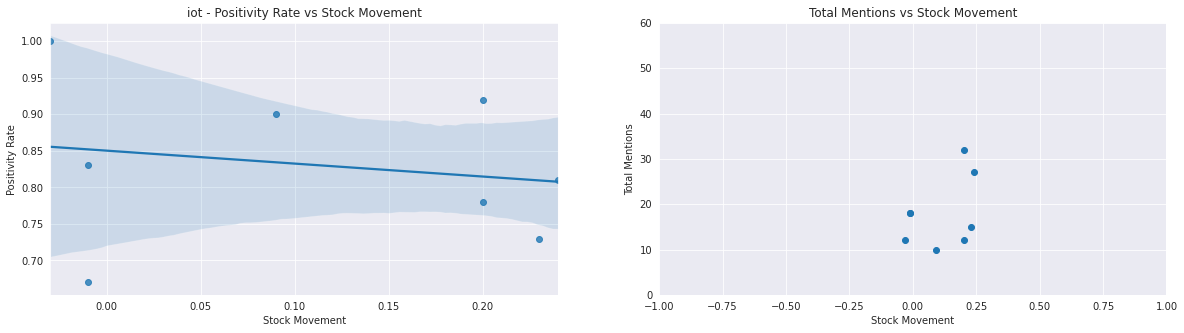

In [298]:
topic = 'iot'
df_top_sent = df_comp[df_comp['company_relevance'] >= 0.2]
df_top_sent = df_top_sent.sort_values(by=topic)[:1000]
df_top_sent = df_top_sent[df_top_sent['filtered_names_match'].notna()]
df_top_sent = df_top_sent.pivot_table(index=['filtered_names_match'], columns=['sentiment'], values='date', aggfunc='count', fill_value=0)
df_top_sent['Total'] = df_top_sent.sum(axis=1)
df_top_sent = df_top_sent.sort_values(by='Total', ascending=False)
df_top_sent['POS_%'] = round(df_top_sent['POSITIVE'] / df_top_sent['Total'],2)
df_top_sent['ticker'] =  df_top_sent.index.map(comp_ticker_dict)
df_top_sent['stock_mvmt'] = df_top_sent['ticker'].map(stock_final_mvmt_dict)
df_top_sent = df_top_sent[df_top_sent['stock_mvmt'].notna()]
df_top_sent = df_top_sent[df_top_sent['Total'] >= 10]
display(df_top_sent)

min_articles = 0
plot_data = df_top_sent[df_top_sent['Total'] >= min_articles]
print(len(plot_data))
plot_data = plot_data[plot_data['stock_mvmt'].between(plot_data['stock_mvmt'].quantile(.1), plot_data['stock_mvmt'].quantile(.90))] 
print(len(plot_data))
corr = round(np.corrcoef(plot_data['POS_%'], plot_data['stock_mvmt']).flatten()[1],2)
print(corr)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
#ax1.scatter(x="stock_mvmt", y="POS_%", data=plot_data)
sns.regplot(x="stock_mvmt", y="POS_%", data=plot_data, ax=ax1)
ax2.scatter(x="stock_mvmt", y="Total", data=plot_data)
#ax1.set_xlim(-1,1)
ax2.set_ylim(bottom=0, top=60)
ax2.set_xlim(-1,1)
ax1.set_xlabel("Stock Movement")
ax2.set_xlabel("Stock Movement")
ax1.set_ylabel("Positivity Rate")
ax2.set_ylabel("Total Mentions")
ax1.set_title(f'{topic} - Positivity Rate vs Stock Movement')
ax2.set_title("Total Mentions vs Stock Movement")
#ax1.text(1, 0.3, '$ \\rho: $' + str(corr), bbox=dict(facecolor='white', alpha=0.5))
plt.show()

sentiment                        NEGATIVE  POSITIVE  Total  POS_% ticker  \
filtered_names_match                                                       
Apple Inc.                             35        30     65   0.46   AAPL   
Visa Inc.                              31        32     63   0.51      V   
Nasdaq, Inc.                           22        26     48   0.54   NDAQ   
PayPal Holdings, Inc.                  28        18     46   0.39   PYPL   
The Goldman Sachs Group, Inc.          27        16     43   0.37     GS   
Mastercard Incorporated                18        16     34   0.47     MA   
Microsoft Corporation                  21         9     30   0.30   MSFT   
Bank of America Corporation            13         8     21   0.38    BAC   
BlackRock, Inc.                         4        13     17   0.76    BLK   
JPMorgan Chase & Co.                   11         5     16   0.31    JPM   
Amazon.com, Inc.                        6         6     12   0.50   AMZN   
MicroStrategy Incorporated              5         7     12   0.58   MSTR   
Tesla, Inc.                             5         6     11   0.55   TSLA   
CME Group Inc.                          5         5     10   0.50    CME   
Zoom Video Communications, Inc.         5         5     10   0.50     ZM   

sentiment                        stock_mvmt  
filtered_names_match                         
Apple Inc.                             0.82  
Visa Inc.                              0.17  
Nasdaq, Inc.                           0.26  
PayPal Holdings, Inc.                  1.17  
The Goldman Sachs Group, Inc.          0.17  
Mastercard Incorporated                0.20  
Microsoft Corporation                  0.43  
Bank of America Corporation           -0.12  
BlackRock, Inc.                        0.47  
JPMorgan Chase & Co.                  -0.06  
Amazon.com, Inc.                       0.76  
MicroStrategy Incorporated             1.72  
Tesla, Inc.                            7.43  
CME Group Inc.                        -0.07  
Zoom Video Communications, Inc.        3.96

15
11
0.26


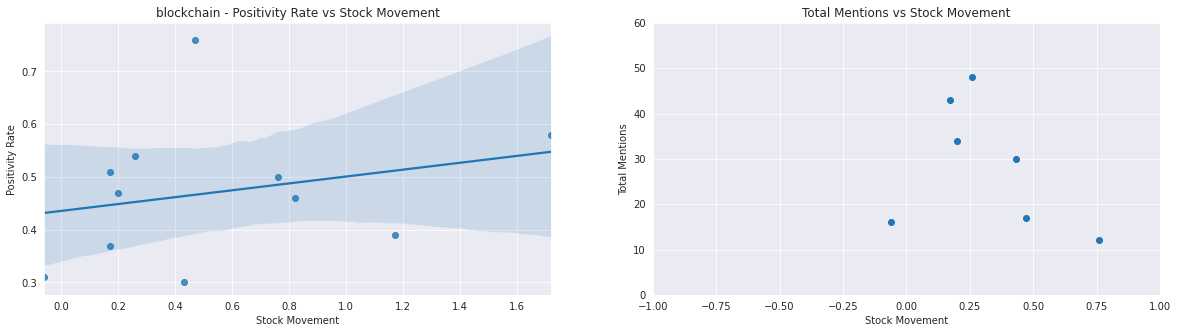

In [299]:
topic = 'blockchain'
df_top_sent = df_comp[df_comp['company_relevance'] >= 0.2]
df_top_sent = df_top_sent.sort_values(by=topic)[:1000]
df_top_sent = df_top_sent[df_top_sent['filtered_names_match'].notna()]
df_top_sent = df_top_sent.pivot_table(index=['filtered_names_match'], columns=['sentiment'], values='date', aggfunc='count', fill_value=0)
df_top_sent['Total'] = df_top_sent.sum(axis=1)
df_top_sent = df_top_sent.sort_values(by='Total', ascending=False)
df_top_sent['POS_%'] = round(df_top_sent['POSITIVE'] / df_top_sent['Total'],2)
df_top_sent['ticker'] =  df_top_sent.index.map(comp_ticker_dict)
df_top_sent['stock_mvmt'] = df_top_sent['ticker'].map(stock_final_mvmt_dict)
df_top_sent = df_top_sent[df_top_sent['stock_mvmt'].notna()]
df_top_sent = df_top_sent[df_top_sent['Total'] >= 10]
display(df_top_sent)

min_articles = 0
plot_data = df_top_sent[df_top_sent['Total'] >= min_articles]
print(len(plot_data))
plot_data = plot_data[plot_data['stock_mvmt'].between(plot_data['stock_mvmt'].quantile(.1), plot_data['stock_mvmt'].quantile(.90))] 
print(len(plot_data))
corr = round(np.corrcoef(plot_data['POS_%'], plot_data['stock_mvmt']).flatten()[1],2)
print(corr)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
#ax1.scatter(x="stock_mvmt", y="POS_%", data=plot_data)
sns.regplot(x="stock_mvmt", y="POS_%", data=plot_data, ax=ax1)
ax2.scatter(x="stock_mvmt", y="Total", data=plot_data)
#ax1.set_xlim(-1,1)
ax2.set_ylim(bottom=0, top=60)
ax2.set_xlim(-1,1)
ax1.set_xlabel("Stock Movement")
ax2.set_xlabel("Stock Movement")
ax1.set_ylabel("Positivity Rate")
ax2.set_ylabel("Total Mentions")
ax1.set_title(f'{topic} - Positivity Rate vs Stock Movement')
ax2.set_title("Total Mentions vs Stock Movement")
#ax1.text(1, 0.3, '$ \\rho: $' + str(corr), bbox=dict(facecolor='white', alpha=0.5))
plt.show()

sentiment                     NEGATIVE  POSITIVE  Total  POS_% ticker  \
filtered_names_match                                                    
Apple Inc.                          83        38    121   0.31   AAPL   
General Motors Company              19        14     33   0.42     GM   
Honeywell International Inc.         9        18     27   0.67    HON   
Intel Corporation                   15         9     24   0.38   INTC   
Tesla, Inc.                          8        11     19   0.58   TSLA   
The Boeing Company                  10         7     17   0.41     BA   
Ford Motor Company                  11         5     16   0.31      F   
Caterpillar Inc.                     9         6     15   0.40    CAT   
Microsoft Corporation                4         8     12   0.67   MSFT   
Morgan Stanley                       8         3     11   0.27     MS   
Johnson & Johnson                    5         6     11   0.55    JNJ   
General Electric Company             3         8     11   0.73     GE   

sentiment                     stock_mvmt  
filtered_names_match                      
Apple Inc.                          0.82  
General Motors Company              0.16  
Honeywell International Inc.        0.23  
Intel Corporation                  -0.15  
Tesla, Inc.                         7.43  
The Boeing Company                 -0.34  
Ford Motor Company                 -0.04  
Caterpillar Inc.                    0.27  
Microsoft Corporation               0.43  
Morgan Stanley                      0.38  
Johnson & Johnson                   0.11  
General Electric Company           -0.03

12
8
-0.06


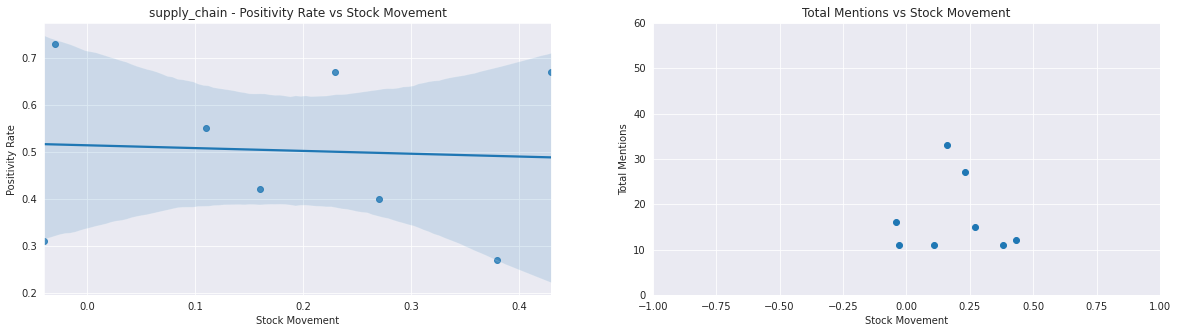

In [300]:
topic = 'supply_chain'
df_top_sent = df_comp[df_comp['company_relevance'] >= 0.2]
df_top_sent = df_top_sent.sort_values(by=topic)[:1000]
df_top_sent = df_top_sent[df_top_sent['filtered_names_match'].notna()]
df_top_sent = df_top_sent.pivot_table(index=['filtered_names_match'], columns=['sentiment'], values='date', aggfunc='count', fill_value=0)
df_top_sent['Total'] = df_top_sent.sum(axis=1)
df_top_sent = df_top_sent.sort_values(by='Total', ascending=False)
df_top_sent['POS_%'] = round(df_top_sent['POSITIVE'] / df_top_sent['Total'],2)
df_top_sent['ticker'] =  df_top_sent.index.map(comp_ticker_dict)
df_top_sent['stock_mvmt'] = df_top_sent['ticker'].map(stock_final_mvmt_dict)
df_top_sent = df_top_sent[df_top_sent['stock_mvmt'].notna()]
df_top_sent = df_top_sent[df_top_sent['Total'] >= 10]
display(df_top_sent)

min_articles = 0
plot_data = df_top_sent[df_top_sent['Total'] >= min_articles]
print(len(plot_data))
plot_data = plot_data[plot_data['stock_mvmt'].between(plot_data['stock_mvmt'].quantile(.1), plot_data['stock_mvmt'].quantile(.90))] 
print(len(plot_data))
corr = round(np.corrcoef(plot_data['POS_%'], plot_data['stock_mvmt']).flatten()[1],2)
print(corr)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
#ax1.scatter(x="stock_mvmt", y="POS_%", data=plot_data)
sns.regplot(x="stock_mvmt", y="POS_%", data=plot_data, ax=ax1)
ax2.scatter(x="stock_mvmt", y="Total", data=plot_data)
#ax1.set_xlim(-1,1)
ax2.set_ylim(bottom=0, top=60)
ax2.set_xlim(-1,1)
ax1.set_xlabel("Stock Movement")
ax2.set_xlabel("Stock Movement")
ax1.set_ylabel("Positivity Rate")
ax2.set_ylabel("Total Mentions")
ax1.set_title(f'{topic} - Positivity Rate vs Stock Movement')
ax2.set_title("Total Mentions vs Stock Movement")
#ax1.text(1, 0.3, '$ \\rho: $' + str(corr), bbox=dict(facecolor='white', alpha=0.5))
plt.show()

sentiment                           NEGATIVE  POSITIVE  Total  POS_% ticker  \
filtered_names_match                                                          
Microsoft Corporation                     53        55    108   0.51   MSFT   
Nasdaq, Inc.                              15        30     45   0.67   NDAQ   
Apple Inc.                                13        13     26   0.50   AAPL   
Zoom Video Communications, Inc.            6        17     23   0.74     ZM   
Vonage Holdings Corp.                      3        20     23   0.87     VG   
VMware, Inc.                               7        16     23   0.70    VMW   
Healthcare Services Group, Inc.            4        16     20   0.80   HCSG   
Gartner, Inc.                              8        12     20   0.60     IT   
RingCentral, Inc.                          4        13     17   0.76    RNG   
Intel Corporation                          5         9     14   0.64   INTC   
Service Corporation International          4         9     13   0.69    SCI   
Oracle Corporation                         4         9     13   0.69   ORCL   
Hewlett Packard Enterprise Company         3         8     11   0.73    HPE   
Amazon.com, Inc.                           5         5     10   0.50   AMZN   

sentiment                           stock_mvmt  
filtered_names_match                            
Microsoft Corporation                     0.43  
Nasdaq, Inc.                              0.26  
Apple Inc.                                0.82  
Zoom Video Communications, Inc.           3.96  
Vonage Holdings Corp.                     0.74  
VMware, Inc.                             -0.08  
Healthcare Services Group, Inc.           0.20  
Gartner, Inc.                             0.04  
RingCentral, Inc.                         1.25  
Intel Corporation                        -0.15  
Service Corporation International         0.09  
Oracle Corporation                        0.24  
Hewlett Packard Enterprise Company       -0.22  
Amazon.com, Inc.                          0.76

14
10
-0.28


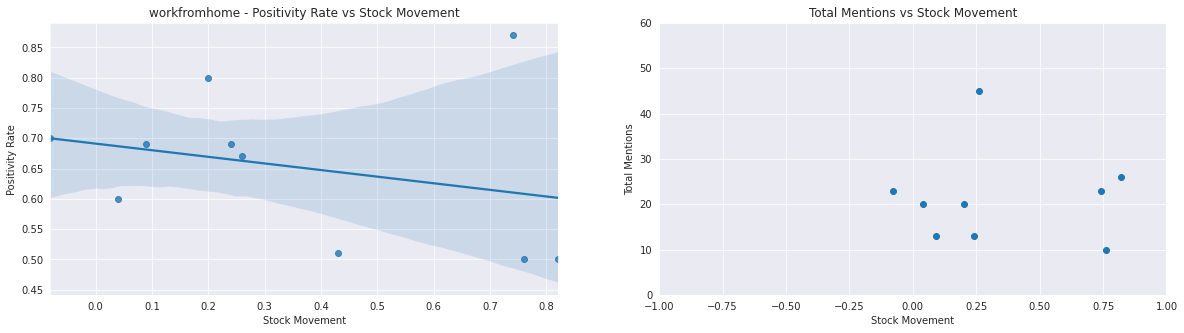

In [301]:
topic = 'workfromhome'
df_top_sent = df_comp[df_comp['company_relevance'] >= 0.2]
df_top_sent = df_top_sent.sort_values(by=topic)[:1000]
df_top_sent = df_top_sent[df_top_sent['filtered_names_match'].notna()]
df_top_sent = df_top_sent.pivot_table(index=['filtered_names_match'], columns=['sentiment'], values='date', aggfunc='count', fill_value=0)
df_top_sent['Total'] = df_top_sent.sum(axis=1)
df_top_sent = df_top_sent.sort_values(by='Total', ascending=False)
df_top_sent['POS_%'] = round(df_top_sent['POSITIVE'] / df_top_sent['Total'],2)
df_top_sent['ticker'] =  df_top_sent.index.map(comp_ticker_dict)
df_top_sent['stock_mvmt'] = df_top_sent['ticker'].map(stock_final_mvmt_dict)
df_top_sent = df_top_sent[df_top_sent['stock_mvmt'].notna()]
df_top_sent = df_top_sent[df_top_sent['Total'] >= 10]
display(df_top_sent)

min_articles = 0
plot_data = df_top_sent[df_top_sent['Total'] >= min_articles]
print(len(plot_data))
plot_data = plot_data[plot_data['stock_mvmt'].between(plot_data['stock_mvmt'].quantile(.1), plot_data['stock_mvmt'].quantile(.90))] 
print(len(plot_data))
corr = round(np.corrcoef(plot_data['POS_%'], plot_data['stock_mvmt']).flatten()[1],2)
print(corr)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
#ax1.scatter(x="stock_mvmt", y="POS_%", data=plot_data)
sns.regplot(x="stock_mvmt", y="POS_%", data=plot_data, ax=ax1)
ax2.scatter(x="stock_mvmt", y="Total", data=plot_data)
#ax1.set_xlim(-1,1)
ax2.set_ylim(bottom=0, top=60)
ax2.set_xlim(-1,1)
ax1.set_xlabel("Stock Movement")
ax2.set_xlabel("Stock Movement")
ax1.set_ylabel("Positivity Rate")
ax2.set_ylabel("Total Mentions")
ax1.set_title(f'{topic} - Positivity Rate vs Stock Movement')
ax2.set_title("Total Mentions vs Stock Movement")
#ax1.text(1, 0.3, '$ \\rho: $' + str(corr), bbox=dict(facecolor='white', alpha=0.5))
plt.show()

sentiment                                    NEGATIVE  POSITIVE  Total  POS_%  \
filtered_names_match                                                            
Microsoft Corporation                              13        45     58   0.78   
Oracle Corporation                                  7        33     40   0.82   
International Business Machines Corporation        10        29     39   0.74   
Healthcare Services Group, Inc.                     8        22     30   0.73   
Nasdaq, Inc.                                       10        17     27   0.63   
Honeywell International Inc.                        6        17     23   0.74   
General Electric Company                            5        13     18   0.72   
Cisco Systems, Inc.                                 4        13     17   0.76   
Dell Technologies Inc.                              5         7     12   0.58   
Hewlett Packard Enterprise Company                  4         8     12   0.67   
Rockwell Automation, Inc.                           3         8     11   0.73   
Apple Inc.                                          2         8     10   0.80   
Emerson Electric Co.                                1         9     10   0.90   

sentiment                                   ticker  stock_mvmt  
filtered_names_match                                            
Microsoft Corporation                         MSFT        0.43  
Oracle Corporation                            ORCL        0.24  
International Business Machines Corporation    IBM       -0.01  
Healthcare Services Group, Inc.               HCSG        0.20  
Nasdaq, Inc.                                  NDAQ        0.26  
Honeywell International Inc.                   HON        0.23  
General Electric Company                        GE       -0.03  
Cisco Systems, Inc.                           CSCO       -0.03  
Dell Technologies Inc.                        DELL        0.43  
Hewlett Packard Enterprise Company             HPE       -0.22  
Rockwell Automation, Inc.                      ROK        0.26  
Apple Inc.                                    AAPL        0.82  
Emerson Electric Co.                           EMR        0.09

13
11
-0.35


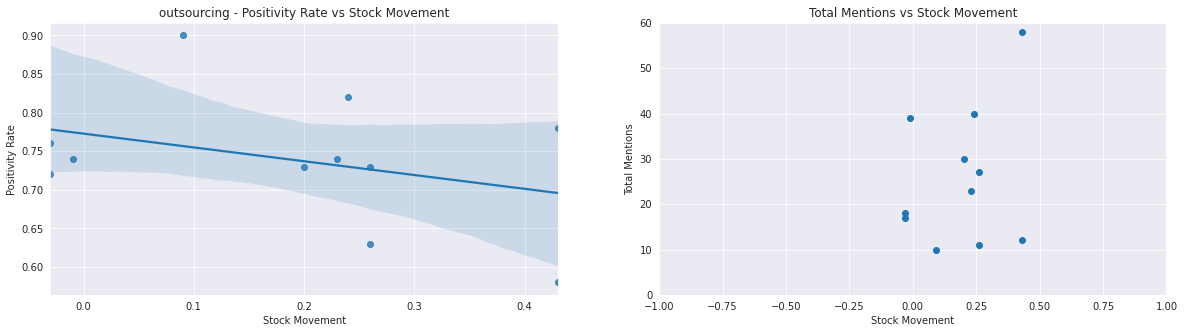

In [302]:
topic = 'outsourcing'
df_top_sent = df_comp[df_comp['company_relevance'] >= 0.2]
df_top_sent = df_top_sent.sort_values(by=topic)[:1000]
df_top_sent = df_top_sent[df_top_sent['filtered_names_match'].notna()]
df_top_sent = df_top_sent.pivot_table(index=['filtered_names_match'], columns=['sentiment'], values='date', aggfunc='count', fill_value=0)
df_top_sent['Total'] = df_top_sent.sum(axis=1)
df_top_sent = df_top_sent.sort_values(by='Total', ascending=False)
df_top_sent['POS_%'] = round(df_top_sent['POSITIVE'] / df_top_sent['Total'],2)
df_top_sent['ticker'] =  df_top_sent.index.map(comp_ticker_dict)
df_top_sent['stock_mvmt'] = df_top_sent['ticker'].map(stock_final_mvmt_dict)
df_top_sent = df_top_sent[df_top_sent['stock_mvmt'].notna()]
df_top_sent = df_top_sent[df_top_sent['Total'] >= 10]
display(df_top_sent)

min_articles = 0
plot_data = df_top_sent[df_top_sent['Total'] >= min_articles]
print(len(plot_data))
plot_data = plot_data[plot_data['stock_mvmt'].between(plot_data['stock_mvmt'].quantile(.1), plot_data['stock_mvmt'].quantile(.90))] 
print(len(plot_data))
corr = round(np.corrcoef(plot_data['POS_%'], plot_data['stock_mvmt']).flatten()[1],2)
print(corr)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
#ax1.scatter(x="stock_mvmt", y="POS_%", data=plot_data)
sns.regplot(x="stock_mvmt", y="POS_%", data=plot_data, ax=ax1)
ax2.scatter(x="stock_mvmt", y="Total", data=plot_data)
#ax1.set_xlim(-1,1)
ax2.set_ylim(bottom=0, top=60)
ax2.set_xlim(-1,1)
ax1.set_xlabel("Stock Movement")
ax2.set_xlabel("Stock Movement")
ax1.set_ylabel("Positivity Rate")
ax2.set_ylabel("Total Mentions")
ax1.set_title(f'{topic} - Positivity Rate vs Stock Movement')
ax2.set_title("Total Mentions vs Stock Movement")
#ax1.text(1, 0.3, '$ \\rho: $' + str(corr), bbox=dict(facecolor='white', alpha=0.5))
plt.show()

### Average Word Document

In [104]:
df_topics_manual.columns

Index(['author', 'date', 'domain', 'title', 'url', 'content', 'topic_area',
       'content_processed', 'content_lemma', 'doc_embedding', 'blockchain',
       'digitization', 'machine_learne', 'cloud', 'iot', 'store_closure',
       'delivery', 'redundancy', 'costcutte', 'flight', 'supply_chain',
       'shutdown', 'outsourcing', 'workfromhome', 'diversification',
       'blockchain_word', 'digitization_word', 'machine_learne_word',
       'cloud_word', 'iot_word', 'store_closure_word', 'delivery_word',
       'redundancy_word', 'costcutte_word', 'flight_word', 'supply_chain_word',
       'shutdown_word', 'outsourcing_word', 'workfromhome_word',
       'diversification_word', 'vaccines_word', 'drug_discovery_word',
       'tele_health_word', 'cybersecurity_word'],
      dtype='object')

sentiment                           NEGATIVE  POSITIVE  Total  POS_% ticker  \
filtered_names_match                                                          
Nasdaq, Inc.                              11        40     51   0.78   NDAQ   
Microsoft Corporation                      5        35     40   0.88   MSFT   
Information Services Group, Inc.           8        25     33   0.76    III   
Healthcare Services Group, Inc.            6        23     29   0.79   HCSG   
Hewlett Packard Enterprise Company         3        12     15   0.80    HPE   
VMware, Inc.                               1        11     12   0.92    VMW   
3D Resources Limited                       1        11     12   0.92    DDD   
Service Corporation International          1        10     11   0.91    SCI   
ACI Worldwide, Inc.                        1        10     11   0.91   ACIW   

sentiment                           stock_mvmt  
filtered_names_match                            
Nasdaq, Inc.                              0.26  
Microsoft Corporation                     0.43  
Information Services Group, Inc.          0.40  
Healthcare Services Group, Inc.           0.20  
Hewlett Packard Enterprise Company       -0.22  
VMware, Inc.                             -0.08  
3D Resources Limited                      0.20  
Service Corporation International         0.09  
ACI Worldwide, Inc.                       0.01

9
7
-0.8


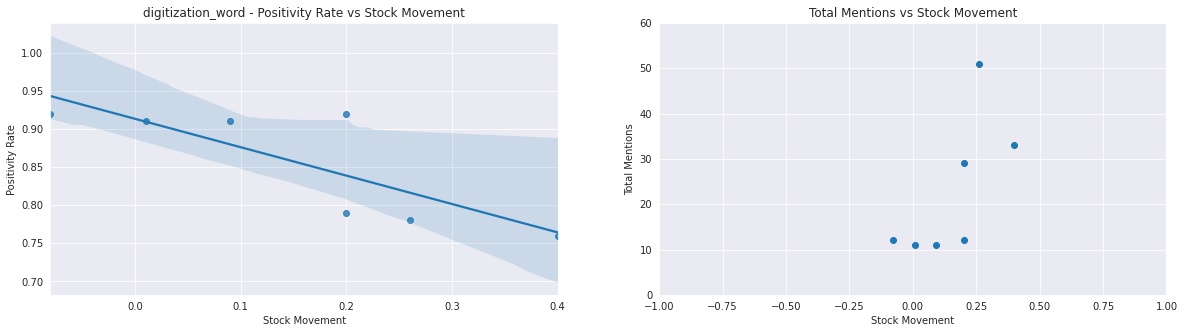

In [303]:
topic = 'digitization_word'
df_top_sent = df_comp[df_comp['company_relevance'] >= 0.2]
df_top_sent = df_top_sent.sort_values(by=topic)[:1000]
df_top_sent = df_top_sent[df_top_sent['filtered_names_match'].notna()]
df_top_sent = df_top_sent.pivot_table(index=['filtered_names_match'], columns=['sentiment'], values='date', aggfunc='count', fill_value=0)
df_top_sent['Total'] = df_top_sent.sum(axis=1)
df_top_sent = df_top_sent.sort_values(by='Total', ascending=False)
df_top_sent['POS_%'] = round(df_top_sent['POSITIVE'] / df_top_sent['Total'],2)
df_top_sent['ticker'] =  df_top_sent.index.map(comp_ticker_dict)
df_top_sent['stock_mvmt'] = df_top_sent['ticker'].map(stock_final_mvmt_dict)
df_top_sent = df_top_sent[df_top_sent['stock_mvmt'].notna()]
df_top_sent = df_top_sent[df_top_sent['Total'] >= 10]
display(df_top_sent)

min_articles = 0
plot_data = df_top_sent[df_top_sent['Total'] >= min_articles]
print(len(plot_data))
plot_data = plot_data[plot_data['stock_mvmt'].between(plot_data['stock_mvmt'].quantile(.1), plot_data['stock_mvmt'].quantile(.90))] 
print(len(plot_data))
corr = round(np.corrcoef(plot_data['POS_%'], plot_data['stock_mvmt']).flatten()[1],2)
print(corr)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
#ax1.scatter(x="stock_mvmt", y="POS_%", data=plot_data)
sns.regplot(x="stock_mvmt", y="POS_%", data=plot_data, ax=ax1)
ax2.scatter(x="stock_mvmt", y="Total", data=plot_data)
#ax1.set_xlim(-1,1)
ax2.set_ylim(bottom=0, top=60)
ax2.set_xlim(-1,1)
ax1.set_xlabel("Stock Movement")
ax2.set_xlabel("Stock Movement")
ax1.set_ylabel("Positivity Rate")
ax2.set_ylabel("Total Mentions")
ax1.set_title(f'{topic} - Positivity Rate vs Stock Movement')
ax2.set_title("Total Mentions vs Stock Movement")
#ax1.text(1, 0.3, '$ \\rho: $' + str(corr), bbox=dict(facecolor='white', alpha=0.5))
plt.show()

17
-0.63
14
-0.41
18
-0.18
16
-0.52
26
0.3
18
-0.35
7
0.67
12
0.12
7
-0.11
15
0.23
16
-0.28
16
-0.42
18
-0.27
9
-0.36
19
-0.36
17
-0.17
17
-0.2
16
-0.38


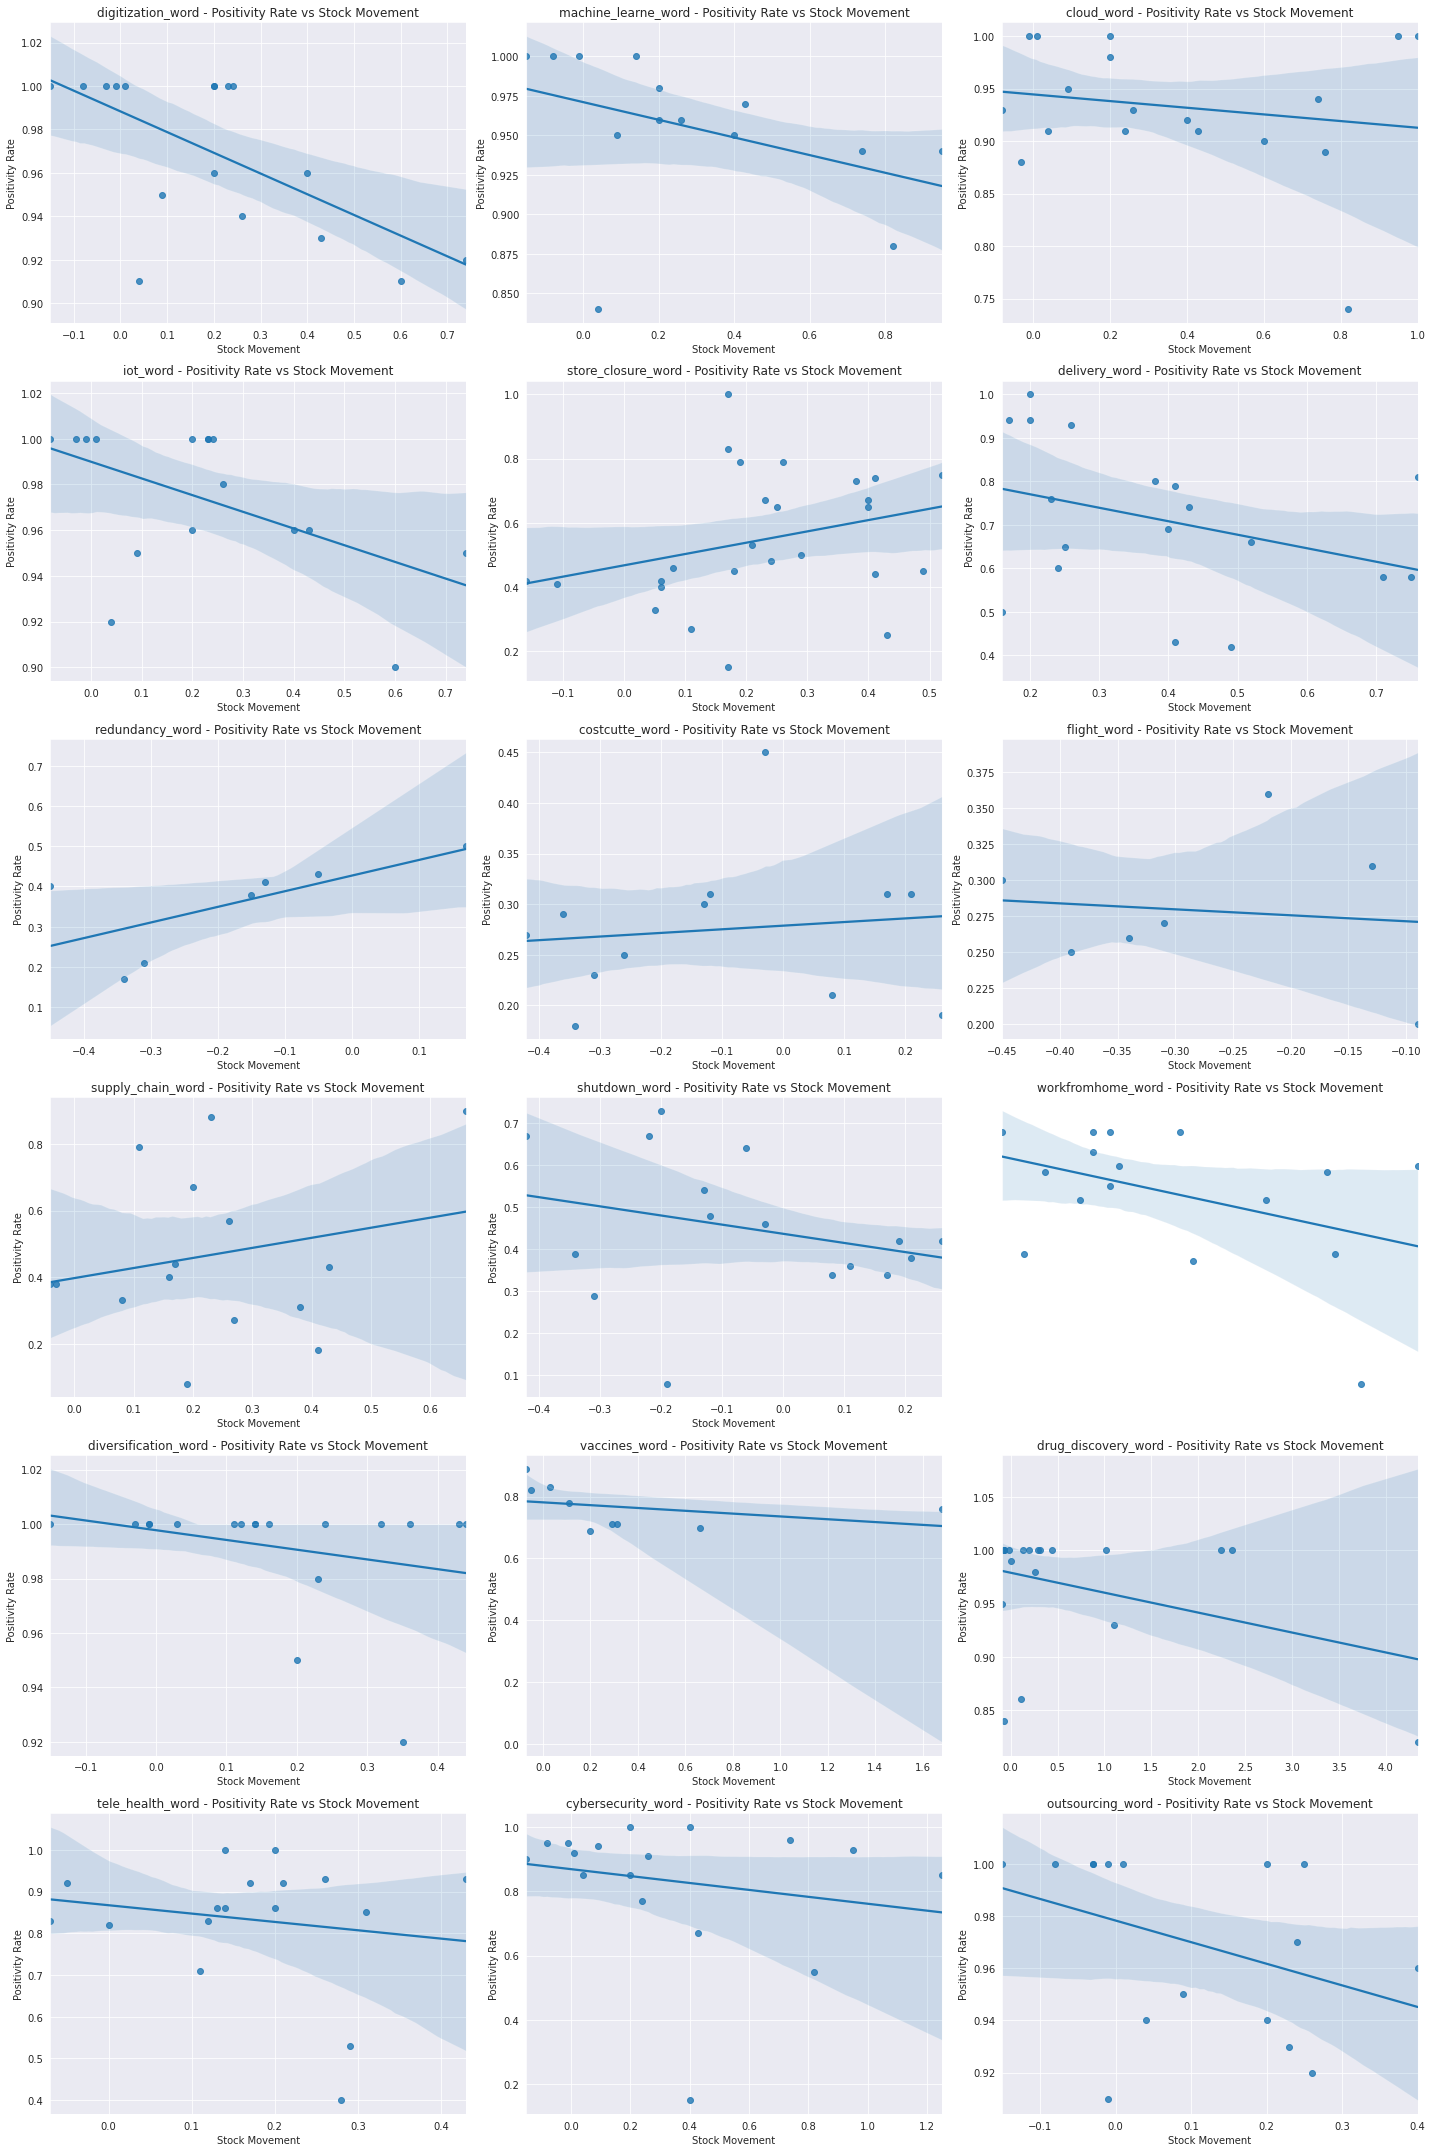

In [321]:
topics = ['digitization_word', 'machine_learne_word', 'cloud_word', 'iot_word', 'store_closure_word', 'delivery_word', 'redundancy_word', 'costcutte_word', 'flight_word',
          'supply_chain_word', 'shutdown_word', 'workfromhome_word', 'diversification_word', 'vaccines_word', 'drug_discovery_word', 'tele_health_word', 'cybersecurity_word', 'outsourcing_word', ]

sns.set_style("darkgrid",)
fig, ax = plt.subplots(6,3, figsize=(20,30), sharey=False)
ax = ax.flatten()
ax[11].axis('off')

for idx, topic in enumerate(topics):
    df_top_sent = df_comp[df_comp['company_relevance'] >= 0.2]
    df_top_sent = df_top_sent.sort_values(by=topic)[:2000]
    df_top_sent = df_top_sent[df_top_sent['filtered_names_match'].notna()]
    df_top_sent = df_top_sent.pivot_table(index=['filtered_names_match'], columns=['roberta'], values='date', aggfunc='count', fill_value=0)
    df_top_sent['Total'] = df_top_sent.sum(axis=1)
    df_top_sent = df_top_sent.sort_values(by='Total', ascending=False)
    df_top_sent['POS_%'] = round(df_top_sent['POSITIVE'] / df_top_sent['Total'],2)
    df_top_sent['ticker'] =  df_top_sent.index.map(comp_ticker_dict)
    df_top_sent['stock_mvmt'] = df_top_sent['ticker'].map(stock_final_mvmt_dict)
    df_top_sent = df_top_sent[df_top_sent['stock_mvmt'].notna()]
    df_top_sent = df_top_sent[df_top_sent['Total'] >= 10]
    #display(df_top_sent)

    min_articles = 0
    plot_data = df_top_sent[df_top_sent['Total'] >= min_articles]
    #print(len(plot_data))
    plot_data = plot_data[plot_data['stock_mvmt'].between(plot_data['stock_mvmt'].quantile(.1), plot_data['stock_mvmt'].quantile(.90))] 
    print(len(plot_data))
    corr = round(np.corrcoef(plot_data['POS_%'], plot_data['stock_mvmt']).flatten()[1],2)
    print(corr)

    sns.regplot(x="stock_mvmt", y="POS_%", data=plot_data, ax=ax[idx])
    ax[idx].set_xlabel("Stock Movement")
    ax[idx].set_ylabel("Positivity Rate")
    ax[idx].set_title(f'{topic} - Positivity Rate vs Stock Movement')
    #ax[idx].text(1, 0.3, '$ \\rho: $' + str(corr), bbox=dict(facecolor='white', alpha=0.5))
plt.tight_layout()

# Sentiment vs Total Market Movement

In [197]:
df_sent_month = df_combined.pivot_table(index='month', columns='roberta', values='date', aggfunc='count', fill_value=0)
df_sent_month['Total'] = df_sent_month.sum(axis=1)
df_sent_month['POS_%'] = round(df_sent_month['POSITIVE'] / df_sent_month['Total'],2)

stock_mvmt_analysis = stock_indices.T.pct_change()[1:13]
stock_mvmt_analysis.index = [1,2,3,4,5,6,7,8,9,10,11,12]

df_sent_month = pd.concat([df_sent_month, stock_mvmt_analysis], axis=1)
df_sent_month = df_sent_month.reset_index()
df_sent_month = df_sent_month.rename(columns={'index': 'month'})
df_sent_month

month  NEGATIVE  POSITIVE  Total  POS_%    S&P500     Dow30    Nasdaq  \
0       1      1314       614   1928   0.32 -0.001628 -0.009896  0.019876   
1       2      4982      2900   7882   0.37 -0.084110 -0.100746 -0.063772   
2       3     22012     16602  38614   0.43 -0.125119 -0.137438 -0.101229   
3       4     21065     22736  43801   0.52  0.126844  0.110806  0.154472   
4       5     19118     24795  43913   0.56  0.045282  0.042611  0.067531   
5       6     18046     24439  42485   0.58  0.018388  0.016931  0.059948   
6       7     29640     41572  71212   0.58  0.055101  0.023842  0.068249   
7       8     14652     21639  36291   0.60  0.070065  0.075742  0.095874   
8       9     14872     20818  35690   0.58 -0.039228 -0.022805 -0.051629   
9      10      5268      6597  11865   0.56 -0.027666 -0.046077 -0.022916   
10     11      5763      9190  14953   0.61  0.107546  0.118372  0.117962   
11     12      6331     10149  16480   0.62  0.037121  0.032655  0.056526   

     FTSE100    ASX200       TSX  
0  -0.033994  0.049835  0.014950  
1  -0.096816 -0.082084 -0.060941  
2  -0.138073 -0.211824 -0.177352  
3   0.040409  0.087772  0.104785  
4   0.029723  0.042246  0.027881  
5   0.015321  0.024706  0.021221  
6  -0.044070  0.005070  0.042152  
7   0.011157  0.022386  0.021349  
8  -0.016349 -0.040360 -0.023797  
9  -0.049232  0.019206 -0.033546  
10  0.123519  0.099568  0.103314  
11  0.031008  0.010632  0.014142

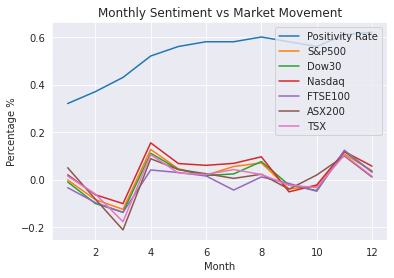

In [198]:
plt.plot('month', 'POS_%', data=df_sent_month, label='Positivity Rate')
plt.plot('month', 'S&P500', data=df_sent_month, label='S&P500')
plt.plot('month', 'Dow30', data=df_sent_month, label='Dow30')
plt.plot('month', 'Nasdaq', data=df_sent_month, label='Nasdaq')
plt.plot('month', 'FTSE100', data=df_sent_month, label='FTSE100')
plt.plot('month', 'ASX200', data=df_sent_month, label='ASX200')
plt.plot('month', 'TSX', data=df_sent_month, label='TSX')

plt.xlabel("Month")
plt.ylabel("Percentage %")
plt.legend()
plt.title('Monthly Sentiment vs Market Movement')
plt.show()

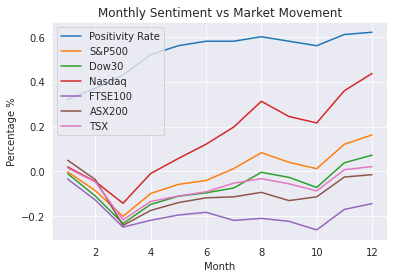

In [199]:
# Cum movement
plt.plot('month', 'POS_%', data=df_sent_month, label='Positivity Rate')
plt.plot('S&P500', data=index_mvmt_analysis_cum, label='S&P500')
plt.plot('Dow30', data=index_mvmt_analysis_cum, label='Dow30')
plt.plot('Nasdaq', data=index_mvmt_analysis_cum, label='Nasdaq')
plt.plot('FTSE100', data=index_mvmt_analysis_cum, label='FTSE100')
plt.plot('ASX200', data=index_mvmt_analysis_cum, label='ASX200')
plt.plot('TSX', data=index_mvmt_analysis_cum, label='TSX')

plt.xlabel("Month")
plt.ylabel("Percentage %")
plt.legend()
plt.title('Monthly Sentiment vs Market Movement')
plt.show()

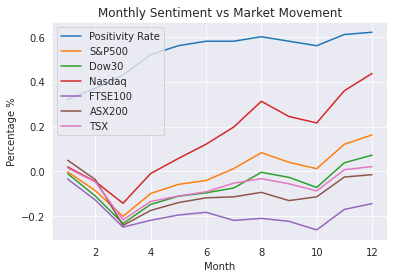

In [200]:
# Cum movement
df_sent_cum = df_sent_month.copy()
df_sent_cum[['S&P500', 'Dow30','Nasdaq', 'FTSE100', 'ASX200', 'TSX']] = (df_sent_cum[['S&P500', 'Dow30','Nasdaq', 'FTSE100', 'ASX200', 'TSX']] + 1).cumprod() - 1

plt.plot('month', 'POS_%', data=df_sent_cum, label='Positivity Rate')
plt.plot('month', 'S&P500', data=df_sent_cum, label='S&P500')
plt.plot('month', 'Dow30', data=df_sent_cum, label='Dow30')
plt.plot('month', 'Nasdaq', data=df_sent_cum, label='Nasdaq')
plt.plot('month', 'FTSE100', data=df_sent_cum, label='FTSE100')
plt.plot('month', 'ASX200', data=df_sent_cum, label='ASX200')
plt.plot('month', 'TSX', data=df_sent_cum, label='TSX')

plt.xlabel("Month")
plt.ylabel("Percentage %")
plt.legend()
plt.title('Monthly Sentiment vs Market Movement')
plt.show()

In [201]:
df_sent_cum

month  NEGATIVE  POSITIVE  Total  POS_%    S&P500     Dow30    Nasdaq  \
0       1      1314       614   1928   0.32 -0.001628 -0.009896  0.019876   
1       2      4982      2900   7882   0.37 -0.085602 -0.109644 -0.045163   
2       3     22012     16602  38614   0.43 -0.200011 -0.232013 -0.141821   
3       4     21065     22736  43801   0.52 -0.098537 -0.146915 -0.009256   
4       5     19118     24795  43913   0.56 -0.057717 -0.110564  0.057650   
5       6     18046     24439  42485   0.58 -0.040390 -0.095505  0.121054   
6       7     29640     41572  71212   0.58  0.012486 -0.073940  0.197565   
7       8     14652     21639  36291   0.60  0.083426 -0.003798  0.312380   
8       9     14872     20818  35690   0.58  0.040925 -0.026517  0.244624   
9      10      5268      6597  11865   0.56  0.012127 -0.071372  0.216101   
10     11      5763      9190  14953   0.61  0.120977  0.038552  0.359555   
11     12      6331     10149  16480   0.62  0.162589  0.072465  0.436404   

     FTSE100    ASX200       TSX  
0  -0.033994  0.049835  0.014950  
1  -0.127519 -0.036340 -0.046902  
2  -0.247985 -0.240466 -0.215936  
3  -0.217596 -0.173801 -0.133778  
4  -0.194341 -0.138897 -0.109626  
5  -0.181998 -0.117622 -0.090732  
6  -0.218047 -0.113149 -0.052405  
7  -0.209323 -0.093296 -0.032174  
8  -0.222250 -0.129890 -0.055206  
9  -0.260540 -0.113179 -0.086899  
10 -0.169203 -0.024880  0.007437  
11 -0.143442 -0.014512  0.021684

In [207]:
print(np.corrcoef(df_sent_cum['POS_%'], df_sent_cum['Nasdaq']).flatten()[1])
print(np.corrcoef(df_sent_cum['POS_%'], df_sent_cum['Nasdaq']).flatten()[1])
print(np.corrcoef(df_sent_cum['POS_%'], df_sent_cum['Nasdaq']).flatten()[1])
print(np.corrcoef(df_sent_cum['POS_%'], df_sent_cum['Nasdaq']).flatten()[1])

0.7679226251963461

In [118]:
company_analysis = 'American Airlines Group Inc.'
df_comp_analysis = df_comp_month[df_comp_month['filtered_names_match'] == company_analysis]
#df_comp_analysis = df_comp_analysis.pivot_table(index='month', columns='sentiment', values='date', aggfunc='count')
df_comp_analysis = df_comp_analysis.pivot_table(index='month', columns='roberta', values='date', aggfunc='count', fill_value=0)
df_comp_analysis['Total'] = df_comp_analysis.sum(axis=1)
df_comp_analysis['POS_%'] = round(df_comp_analysis['POSITIVE'] / df_comp_analysis['Total'],2)

ticker = comp_ticker_dict[company_analysis]
stock_mvmt_analysis = stock_final.loc[ticker].pct_change()[1:13]
stock_mvmt_analysis.index = [1,2,3,4,5,6,7,8,9,10,11,12]

df_comp_analysis['stock_mvmt'] = stock_mvmt_analysis
df_comp_analysis = df_comp_analysis.reset_index()
df_comp_analysis

roberta  month  NEGATIVE  POSITIVE  Total  POS_%  stock_mvmt
0            1        42        14     56   0.25   -0.290239
1            2        47         8     55   0.15   -0.357740
2            3       139        49    188   0.26   -0.014766
3            4        55        36     91   0.40   -0.125729
4            5        70        62    132   0.47    0.244762
5            6       125       153    278   0.55   -0.149197
6            7       196        97    293   0.33    0.173561
7            8        47        40     87   0.46   -0.058238
8            9        73        64    137   0.47   -0.082181
9           10        38        31     69   0.45    0.252660
10          11        29        40     69   0.58    0.116065
11          12        38        64    102   0.63    0.088776

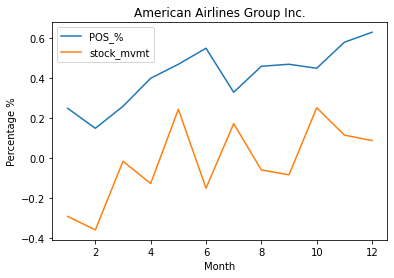

In [119]:
plt.plot('month', 'POS_%', data=df_comp_analysis)
plt.plot('month', 'stock_mvmt', data=df_comp_analysis)
plt.xlabel("Month")
plt.ylabel("Percentage %")
plt.legend()
plt.title(company_analysis)
plt.show()

# Companies with best and worst positivity rates

In [550]:
df_comp.head(1)

author       date      domain  \
0  Thomas Hughes 2020-01-02  marketbeat   

                                            title  \
0  Three Industrial Giants You Should Own In 2020   

                                                 url  \
0  https://www.marketbeat.com/originals/three-ind...   

                                             content topic_area  \
0  With the end of the year just around the corne...   business   

                                   content_processed distilbert  finbert  \
0  end year corner past time think positioning fo...   POSITIVE  NEUTRAL   

    roberta  sentiment_match sentiment topic_id topic_label topic_label_str  \
0  POSITIVE            False  POSITIVE      970                               

   topic_score                                        topic_words  \
0     0.437342  [caterpillar, ibe, fourthquarter, secondquarte...   

  primary_topic filtered_names_match filtered_names_titles_match  \
0                   Caterpillar Inc.                          []   

   nb_companies  nb_companies_title  blockchain  digitization  machine_learne  \
0             5                   0     0.64344      0.492892        0.579234   

      cloud       iot  store_closure  delivery  redundancy  costcutte  \
0  0.571812  0.521615       0.453935  0.221586    0.588197   0.209348   

    flight  supply_chain  shutdown  outsourcing  workfromhome  \
0  0.51657      0.274569  0.142759     0.503211      0.464359   

   diversification  blockchain_word  digitization_word  machine_learne_word  \
0         0.674917         0.765884           0.667034             0.723726   

   cloud_word  iot_word  store_closure_word  delivery_word  redundancy_word  \
0    0.718853  0.685893            0.641455       0.488895         0.729611   

   costcutte_word  flight_word  supply_chain_word  shutdown_word  \
0         0.48086     0.682581           0.523684       0.437137   

   outsourcing_word  workfromhome_word  diversification_word  vaccines_word  \
0           0.67381           0.648299              0.786551       0.692542   

   drug_discovery_word  tele_health_word  cybersecurity_word  month  \
0             0.646232          0.677501            0.625921      1   

      industry subindustry ticker_symbol        country  company_relevance  
0  Industrials   Machinery           CAT  United States                0.2

In [551]:
df_comp_pos_rate = df_comp[df_comp['company_relevance'] >= 0.2].copy()

df_comp_pos_rate = df_comp_pos_rate.pivot_table(index='filtered_names_match', columns='roberta', values='date', aggfunc='count', fill_value=0)
df_comp_pos_rate['Total'] = df_comp_pos_rate.sum(axis=1)
df_comp_pos_rate['POS_%'] = round(df_comp_pos_rate['POSITIVE'] / df_comp_pos_rate['Total'],2)

# Exclude companies with less than 10 mentions
df_comp_pos_rate = df_comp_pos_rate[df_comp_pos_rate['Total'] >= 25]
df_comp_pos_rate = df_comp_pos_rate.sort_values("POS_%", ascending=False)

tickers = [comp_ticker_dict[comp] for comp in list(df_comp_pos_rate.index)]
countries = [comp_country_dict[comp] for comp in list(df_comp_pos_rate.index)]
df_comp_pos_rate = df_comp_pos_rate.reset_index()
df_comp_pos_rate['ticker'] = tickers
df_comp_pos_rate['country'] = countries
df_comp_pos_rate

roberta             filtered_names_match  NEGATIVE  POSITIVE  Total  POS_%  \
0                       Quarterhill Inc.         0        25     25   1.00   
1                   Avaya Holdings Corp.         0        29     29   1.00   
2           Karyopharm Therapeutics Inc.         0        35     35   1.00   
3            Akoustis Technologies, Inc.         0        26     26   1.00   
4           Genetic Technologies Limited         0        28     28   1.00   
...                                  ...       ...       ...    ...    ...   
1441           Ascena Retail Group, Inc.        67        18     85   0.21   
1442          Westminster Resources Ltd.        28         7     35   0.20   
1443                         Lookers plc        24         6     30   0.20   
1444                     Flybe Group PLC       102        24    126   0.19   
1445     Diamond Offshore Drilling, Inc.        30         6     36   0.17   

roberta ticker         country  
0         QTRH          Canada  
1         AVYA   United States  
2         KPTI   United States  
3         AKTS   United States  
4          GTG       Australia  
...        ...             ...  
1441      ASNA   United States  
1442       WMR          Canada  
1443      LOOK  United Kingdom  
1444      FLYB  United Kingdom  
1445        DO   United States  

[1446 rows x 7 columns]

In [552]:
stock_final_min_val = stock_final.copy()
stock_final_min_val = stock_final_min_val[stock_final_min_val["2019-12-01"] >= 1] # remove small value stocks
stock_final_min_val = stock_final_min_val[stock_final_min_val["2020-12-01"] >= 1] # remove small value stocks
print(len(stock_final_min_val))

def is_listed(ticker):
    if (ticker in stock_final_min_val.index):
        if pd.notna(stock_final_min_val.loc[ticker][0]):
            return 1
        else:
            return 0
    else:
        return 0
    
df_comp_pos_rate_us = df_comp_pos_rate[df_comp_pos_rate['country'] == 'United States'].sort_values(['POS_%', 'Total'], ascending=False)
df_comp_pos_rate_us['listed'] = df_comp_pos_rate_us['ticker'].apply(is_listed)
df_comp_pos_rate_us = df_comp_pos_rate_us[df_comp_pos_rate_us['listed'] == 1]
df_comp_pos_rate_us

3459


roberta          filtered_names_match  NEGATIVE  POSITIVE  Total  POS_%  \
15                   Everbridge, Inc.         0        54     54   1.00   
5                       Cars.com Inc.         0        38     38   1.00   
2        Karyopharm Therapeutics Inc.         0        35     35   1.00   
9        Capstone Turbine Corporation         0        32     32   1.00   
11         Catalyst Biosciences, Inc.         0        32     32   1.00   
...                               ...       ...       ...    ...    ...   
1395             Bishop Capital Corp.        36        20     56   0.36   
1397                  CoreCivic, Inc.        18        10     28   0.36   
1402                 News Corporation       142        74    216   0.34   
1427     Republic First Bancorp, Inc.        26        10     36   0.28   
1436      Pilgrim's Pride Corporation        20         7     27   0.26   

roberta ticker        country  listed  
15        EVBG  United States       1  
5         CARS  United States       1  
2         KPTI  United States       1  
9         CGRN  United States       1  
11        CBIO  United States       1  
...        ...            ...     ...  
1395      BPCP  United States       1  
1397       CXW  United States       1  
1402      NWSA  United States       1  
1427      FRBK  United States       1  
1436       PPC  United States       1  

[735 rows x 8 columns]

In [ ]:
#df_comp[df_comp['filtered_names_match'] == 'SPX Corporation'].iloc[1]['content']

roberta            filtered_names_match  NEGATIVE  POSITIVE  Total  POS_%  \
15                     Everbridge, Inc.         0        54     54    1.0   
5                         Cars.com Inc.         0        38     38    1.0   
2          Karyopharm Therapeutics Inc.         0        35     35    1.0   
9          Capstone Turbine Corporation         0        32     32    1.0   
11           Catalyst Biosciences, Inc.         0        32     32    1.0   
1                  Avaya Holdings Corp.         0        29     29    1.0   
3           Akoustis Technologies, Inc.         0        26     26    1.0   
6                              QAD Inc.         0        26     26    1.0   
10       Commercial Vehicle Group, Inc.         0        26     26    1.0   
13       BioCryst Pharmaceuticals, Inc.         0        25     25    1.0   

roberta ticker        country  listed  
15        EVBG  United States       1  
5         CARS  United States       1  
2         KPTI  United States       1  
9         CGRN  United States       1  
11        CBIO  United States       1  
1         AVYA  United States       1  
3         AKTS  United States       1  
6         QADA  United States       1  
10        CVGI  United States       1  
13        BCRX  United States       1

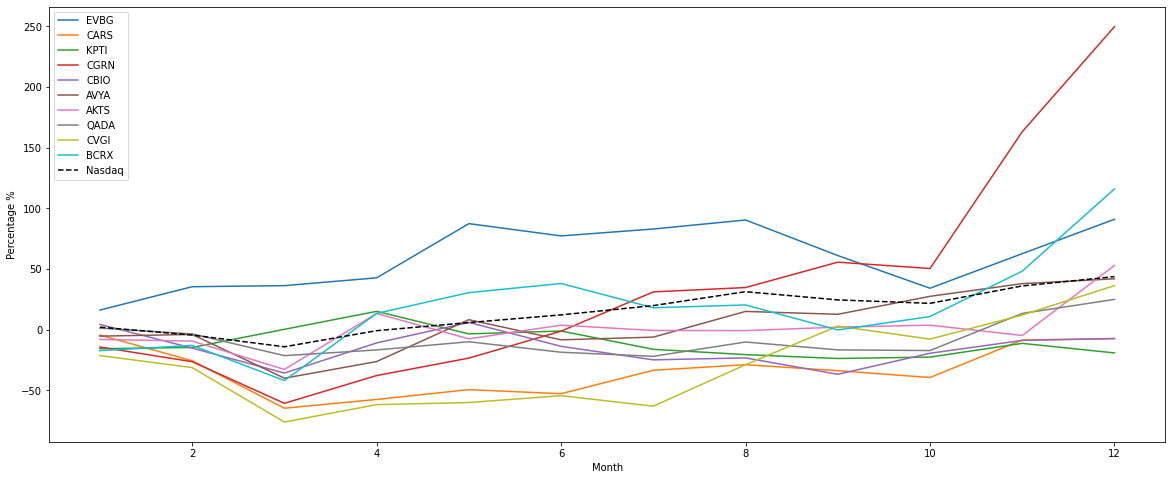

In [554]:
topus = df_comp_pos_rate_us.sort_values(['POS_%', 'Total'], ascending=False).head(10)
display(topus)

fig, ax = plt.subplots(figsize=(20,8))
for ticker in topus['ticker']:
    stock_mvmt_temp = stock_final.loc[ticker].pct_change()[1:13]
    stock_mvmt_temp = ((stock_mvmt_temp + 1).cumprod() - 1) * 100
    stock_mvmt_temp.index = [1,2,3,4,5,6,7,8,9,10,11,12]
    plt.plot(stock_mvmt_temp, label=ticker)

plt.plot('Nasdaq', data=index_mvmt_analysis_cum * 100, label='Nasdaq', ls='--', color='black')
plt.legend()
plt.xlabel("Month")
plt.ylabel("Percentage %")
plt.title("")
plt.show()

roberta            filtered_names_match  NEGATIVE  POSITIVE  Total  POS_%  \
1377       Royal Caribbean Cruises Ltd.       328       209    537   0.39   
1378     United Airlines Holdings, Inc.       920       572   1492   0.38   
1385             Southwest Airlines Co.       352       216    568   0.38   
1384         Carnival Corporation & Plc       348       213    561   0.38   
1392              Delta Air Lines, Inc.       458       271    729   0.37   
1395               Bishop Capital Corp.        36        20     56   0.36   
1397                    CoreCivic, Inc.        18        10     28   0.36   
1402                   News Corporation       142        74    216   0.34   
1427       Republic First Bancorp, Inc.        26        10     36   0.28   
1436        Pilgrim's Pride Corporation        20         7     27   0.26   

roberta ticker        country  listed  
1377       RCL  United States       1  
1378       UAL  United States       1  
1385       LUV  United States       1  
1384       CCL  United States       1  
1392       DAL  United States       1  
1395      BPCP  United States       1  
1397       CXW  United States       1  
1402      NWSA  United States       1  
1427      FRBK  United States       1  
1436       PPC  United States       1

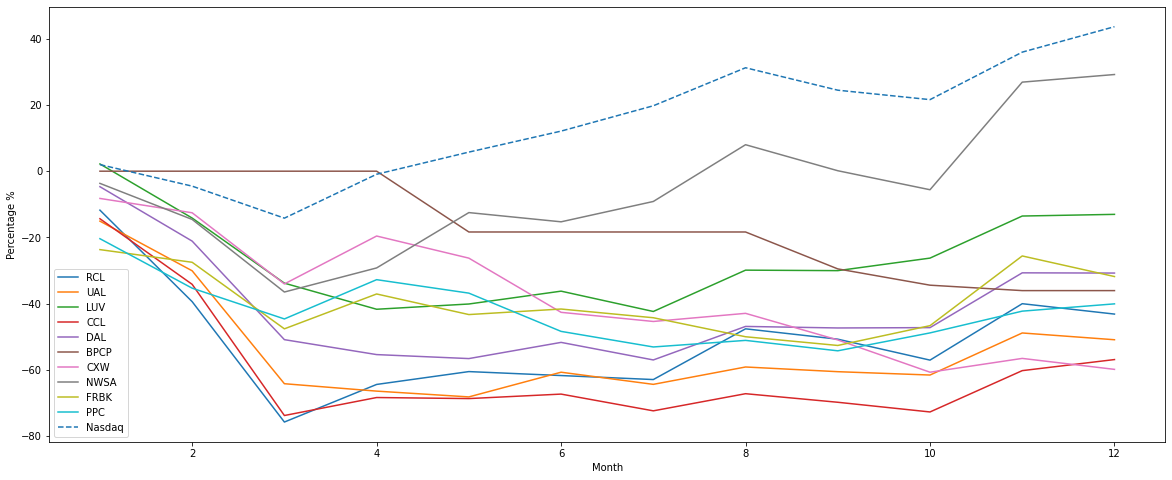

In [555]:
botus = df_comp_pos_rate_us.sort_values(['POS_%', 'Total'], ascending=False).tail(10)
display(botus)

fig, ax = plt.subplots(figsize=(20,8))
for ticker in botus['ticker']:
    stock_mvmt_temp = stock_final.loc[ticker].pct_change()[1:13]
    stock_mvmt_temp = ((stock_mvmt_temp + 1).cumprod() - 1) * 100
    stock_mvmt_temp.index = [1,2,3,4,5,6,7,8,9,10,11,12]
    plt.plot(stock_mvmt_temp, label=ticker)

plt.plot('Nasdaq', data=index_mvmt_analysis_cum * 100, label='Nasdaq', ls='--')
plt.legend()
plt.xlabel("Month")
plt.ylabel("Percentage %")
plt.title("")
plt.show()

roberta          filtered_names_match  NEGATIVE  POSITIVE  Total  POS_%  \
6               Eli Lilly and Company         0        83     83   1.00   
0         Sorrento Therapeutics, Inc.         0        57     57   1.00   
2                          Amgen Inc.         0        55     55   1.00   
3                         Biogen Inc.         0        55     55   1.00   
1                       Novavax, Inc.         0        49     49   1.00   
9                     Humanigen, Inc.         0        29     29   1.00   
5          Catalyst Biosciences, Inc.         0        27     27   1.00   
11       Bristol-Myers Squibb Company         2        96     98   0.98   
10                    Altimmune, Inc.         1        40     41   0.98   
15                       Nasdaq, Inc.        13       405    418   0.97   

roberta ticker        country  listed  
6          LLY  United States       1  
0         SRNE  United States       1  
2         AMGN  United States       1  
3         BIIB  United States       1  
1         NVAX  United States       1  
9         HGEN  United States       1  
5         CBIO  United States       1  
11         BMY  United States       1  
10         ALT  United States       1  
15        NDAQ  United States       1

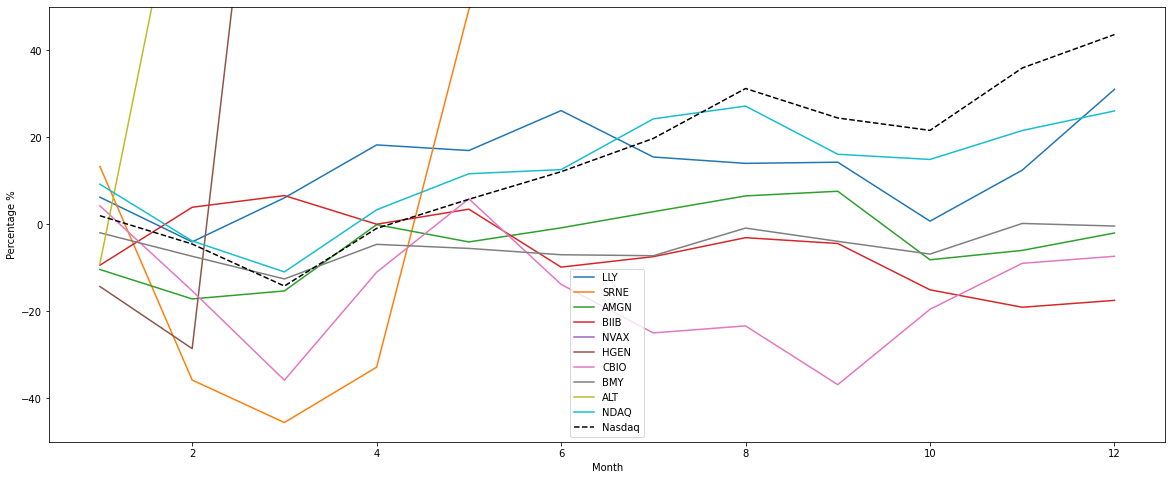

In [556]:
df_topic_selection = df_comp.sort_values('drug_discovery_word')[:5000]

df_comp_pos_rate = df_topic_selection[df_topic_selection['company_relevance'] >= 0.2].copy()

df_comp_pos_rate = df_comp_pos_rate.pivot_table(index='filtered_names_match', columns='roberta', values='date', aggfunc='count', fill_value=0)
df_comp_pos_rate['Total'] = df_comp_pos_rate.sum(axis=1)
df_comp_pos_rate['POS_%'] = round(df_comp_pos_rate['POSITIVE'] / df_comp_pos_rate['Total'],2)

# Exclude companies with less than 10 mentions
df_comp_pos_rate = df_comp_pos_rate[df_comp_pos_rate['Total'] >= 25]
df_comp_pos_rate = df_comp_pos_rate.sort_values("POS_%", ascending=False)

tickers = [comp_ticker_dict[comp] for comp in list(df_comp_pos_rate.index)]
countries = [comp_country_dict[comp] for comp in list(df_comp_pos_rate.index)]
df_comp_pos_rate = df_comp_pos_rate.reset_index()
df_comp_pos_rate['ticker'] = tickers
df_comp_pos_rate['country'] = countries
    
df_comp_pos_rate_us = df_comp_pos_rate[df_comp_pos_rate['country'] == 'United States'].sort_values(['POS_%', 'Total'], ascending=False)
df_comp_pos_rate_us['listed'] = df_comp_pos_rate_us['ticker'].apply(is_listed)
df_comp_pos_rate_us = df_comp_pos_rate_us[df_comp_pos_rate_us['listed'] == 1]

topus = df_comp_pos_rate_us.sort_values(['POS_%', 'Total'], ascending=False).head(10)
display(topus)

fig, ax = plt.subplots(figsize=(20,8))
for ticker in topus['ticker']:
    stock_mvmt_temp = stock_final.loc[ticker].pct_change()[1:13]
    stock_mvmt_temp = ((stock_mvmt_temp + 1).cumprod() - 1) * 100
    stock_mvmt_temp.index = [1,2,3,4,5,6,7,8,9,10,11,12]
    plt.plot(stock_mvmt_temp, label=ticker)

plt.plot('Nasdaq', data=index_mvmt_analysis_cum * 100, label='Nasdaq', ls='--', color='black')
plt.legend()
plt.xlabel("Month")
plt.ylim(-50,50)
plt.ylabel("Percentage %")
plt.title("")
plt.show()

roberta             filtered_names_match  NEGATIVE  POSITIVE  Total  POS_%  \
0                  Gilead Sciences, Inc.         6        36     42   0.86   
1                            Pfizer Inc.        41       182    223   0.82   
2                      Johnson & Johnson        68       226    294   0.77   
4           Inovio Pharmaceuticals, Inc.        11        31     42   0.74   
5        Regeneron Pharmaceuticals, Inc.        12        29     41   0.71   
6        Healthcare Services Group, Inc.        48       101    149   0.68   

roberta ticker        country  listed  
0         GILD  United States       1  
1          PFE  United States       1  
2          JNJ  United States       1  
4          INO  United States       1  
5         REGN  United States       1  
6         HCSG  United States       1

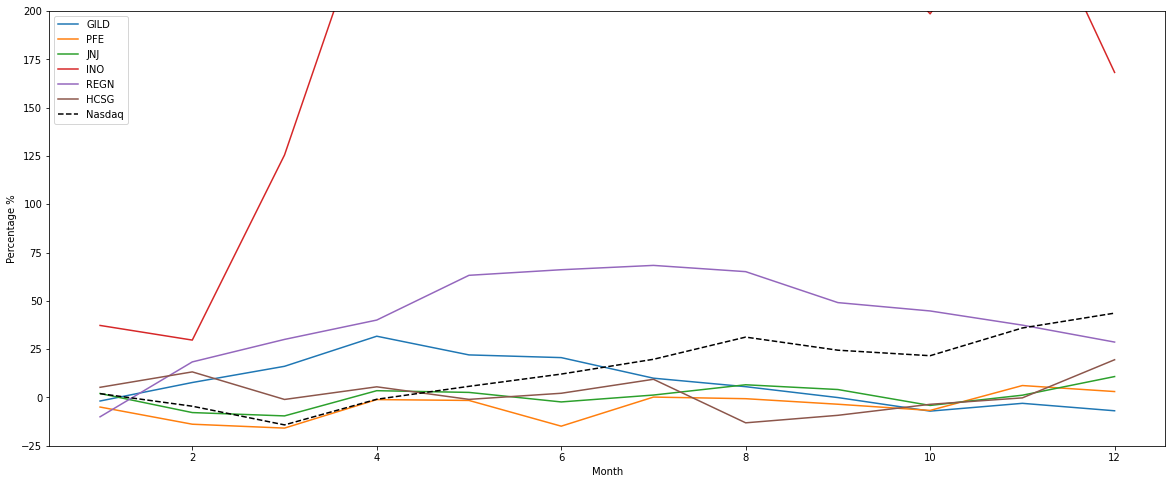

In [562]:
df_topic_selection = df_comp.sort_values('vaccines_word')[:5000]

df_comp_pos_rate = df_topic_selection[df_topic_selection['company_relevance'] >= 0.2].copy()

df_comp_pos_rate = df_comp_pos_rate.pivot_table(index='filtered_names_match', columns='roberta', values='date', aggfunc='count', fill_value=0)
df_comp_pos_rate['Total'] = df_comp_pos_rate.sum(axis=1)
df_comp_pos_rate['POS_%'] = round(df_comp_pos_rate['POSITIVE'] / df_comp_pos_rate['Total'],2)

# Exclude companies with less than 10 mentions
df_comp_pos_rate = df_comp_pos_rate[df_comp_pos_rate['Total'] >= 25]
df_comp_pos_rate = df_comp_pos_rate.sort_values("POS_%", ascending=False)

tickers = [comp_ticker_dict[comp] for comp in list(df_comp_pos_rate.index)]
countries = [comp_country_dict[comp] for comp in list(df_comp_pos_rate.index)]
df_comp_pos_rate = df_comp_pos_rate.reset_index()
df_comp_pos_rate['ticker'] = tickers
df_comp_pos_rate['country'] = countries
    
df_comp_pos_rate_us = df_comp_pos_rate[df_comp_pos_rate['country'] == 'United States'].sort_values(['POS_%', 'Total'], ascending=False)
df_comp_pos_rate_us['listed'] = df_comp_pos_rate_us['ticker'].apply(is_listed)
df_comp_pos_rate_us = df_comp_pos_rate_us[df_comp_pos_rate_us['listed'] == 1]

topus = df_comp_pos_rate_us.sort_values(['POS_%', 'Total'], ascending=False).head(10)
display(topus)

fig, ax = plt.subplots(figsize=(20,8))
for ticker in topus['ticker']:
    stock_mvmt_temp = stock_final.loc[ticker].pct_change()[1:13]
    stock_mvmt_temp = ((stock_mvmt_temp + 1).cumprod() - 1) * 100
    stock_mvmt_temp.index = [1,2,3,4,5,6,7,8,9,10,11,12]
    plt.plot(stock_mvmt_temp, label=ticker)

plt.plot('Nasdaq', data=index_mvmt_analysis_cum * 100, label='Nasdaq', ls='--', color='black')
plt.legend()
plt.xlabel("Month")
plt.ylim(-25,200)
plt.ylabel("Percentage %")
plt.title("")
plt.show()

roberta             filtered_names_match  NEGATIVE  POSITIVE  Total  POS_%  \
1          The Goldman Sachs Group, Inc.         4        24     28   0.86   
3                           Nasdaq, Inc.         7        32     39   0.82   
4                       Amazon.com, Inc.        18        70     88   0.80   
6                   The Home Depot, Inc.         9        28     37   0.76   
7                              eBay Inc.        15        45     60   0.75   
9                         Morgan Stanley         8        22     30   0.73   
8                           Wayfair Inc.         7        19     26   0.73   
12                    Target Corporation        81       181    262   0.69   
10                          Walmart Inc.        47       105    152   0.69   
11       American Eagle Outfitters, Inc.        10        22     32   0.69   

roberta ticker        country  listed  
1           GS  United States       1  
3         NDAQ  United States       1  
4         AMZN  United States       1  
6           HD  United States       1  
7         EBAY  United States       1  
9           MS  United States       1  
8            W  United States       1  
12         TGT  United States       1  
10         WMT  United States       1  
11         AEO  United States       1

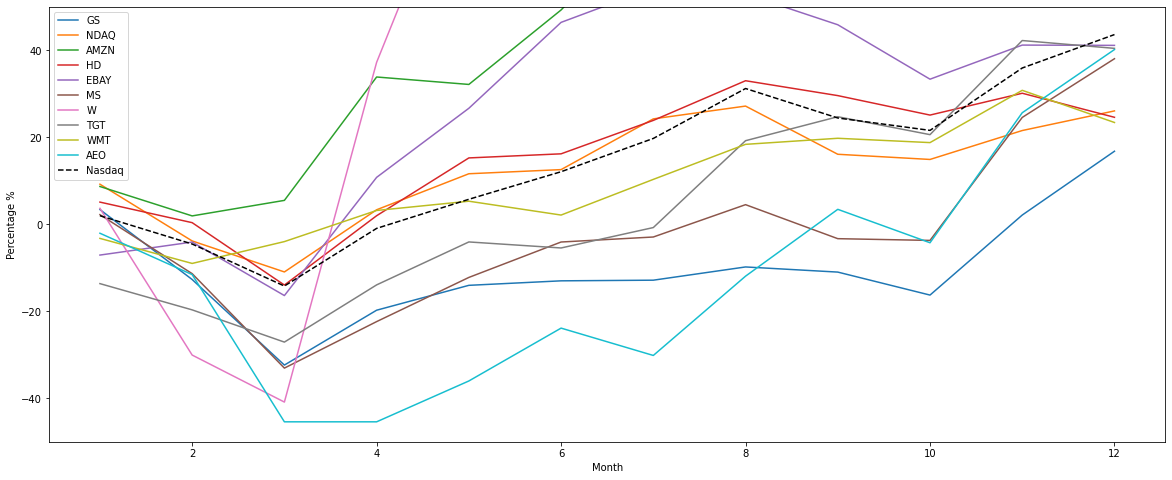

In [558]:
df_topic_selection = df_comp.sort_values('store_closure')[:5000]

df_comp_pos_rate = df_topic_selection[df_topic_selection['company_relevance'] >= 0.2].copy()

df_comp_pos_rate = df_comp_pos_rate.pivot_table(index='filtered_names_match', columns='roberta', values='date', aggfunc='count', fill_value=0)
df_comp_pos_rate['Total'] = df_comp_pos_rate.sum(axis=1)
df_comp_pos_rate['POS_%'] = round(df_comp_pos_rate['POSITIVE'] / df_comp_pos_rate['Total'],2)

# Exclude companies with less than 10 mentions
df_comp_pos_rate = df_comp_pos_rate[df_comp_pos_rate['Total'] >= 25]
df_comp_pos_rate = df_comp_pos_rate.sort_values("POS_%", ascending=False)

tickers = [comp_ticker_dict[comp] for comp in list(df_comp_pos_rate.index)]
countries = [comp_country_dict[comp] for comp in list(df_comp_pos_rate.index)]
df_comp_pos_rate = df_comp_pos_rate.reset_index()
df_comp_pos_rate['ticker'] = tickers
df_comp_pos_rate['country'] = countries
    
df_comp_pos_rate_us = df_comp_pos_rate[df_comp_pos_rate['country'] == 'United States'].sort_values(['POS_%', 'Total'], ascending=False)
df_comp_pos_rate_us['listed'] = df_comp_pos_rate_us['ticker'].apply(is_listed)
df_comp_pos_rate_us = df_comp_pos_rate_us[df_comp_pos_rate_us['listed'] == 1]

topus = df_comp_pos_rate_us.sort_values(['POS_%', 'Total'], ascending=False).head(10)
display(topus)

fig, ax = plt.subplots(figsize=(20,8))
for ticker in topus['ticker']:
    stock_mvmt_temp = stock_final.loc[ticker].pct_change()[1:13]
    stock_mvmt_temp = ((stock_mvmt_temp + 1).cumprod() - 1) * 100
    stock_mvmt_temp.index = [1,2,3,4,5,6,7,8,9,10,11,12]
    plt.plot(stock_mvmt_temp, label=ticker)

plt.plot('Nasdaq', data=index_mvmt_analysis_cum * 100, label='Nasdaq', ls='--', color='black')
plt.legend()
plt.xlabel("Month")
plt.ylim(-50,50)
plt.ylabel("Percentage %")
plt.title("")
plt.show()

roberta                    filtered_names_match  NEGATIVE  POSITIVE  Total  \
1        The PNC Financial Services Group, Inc.        16        21     37   
0                        McDonald's Corporation        13        17     30   
5                            The Boeing Company        47        34     81   
6                  American Airlines Group Inc.        30        22     52   
7                                    Apple Inc.        51        34     85   
8                United Airlines Holdings, Inc.        39        21     60   
9                                  Nasdaq, Inc.        67        35    102   
12                  Bank of America Corporation        26        13     39   
13                                     Dow Inc.        86        41    127   
15                The Goldman Sachs Group, Inc.        73        24     97   

roberta  POS_% ticker        country  listed  
1         0.57    PNC  United States       1  
0         0.57    MCD  United States       1  
5         0.42     BA  United States       1  
6         0.42    AAL  United States       1  
7         0.40   AAPL  United States       1  
8         0.35    UAL  United States       1  
9         0.34   NDAQ  United States       1  
12        0.33    BAC  United States       1  
13        0.32    DOW  United States       1  
15        0.25     GS  United States       1

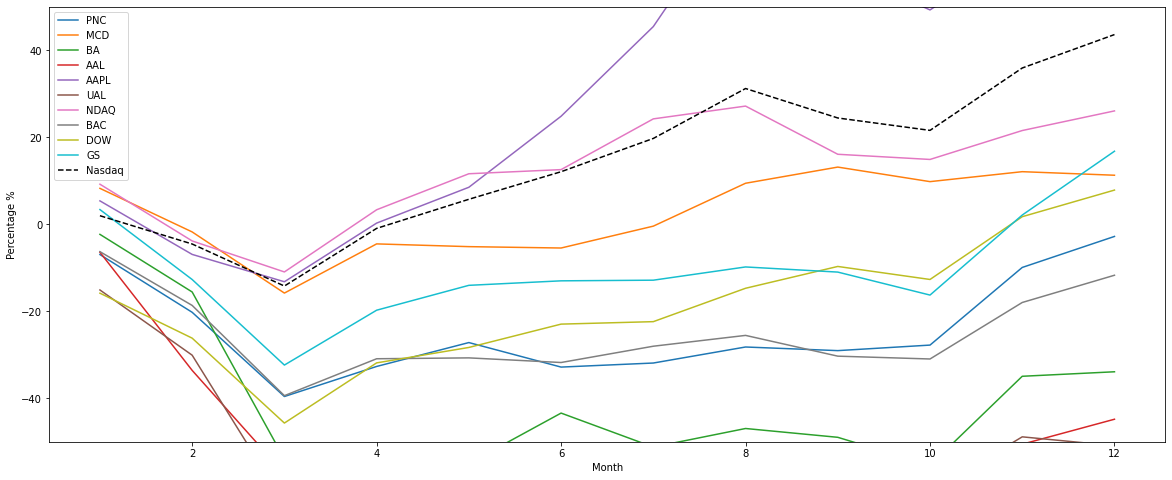

In [559]:
df_topic_selection = df_comp.sort_values('shutdown')[:5000]

df_comp_pos_rate = df_topic_selection[df_topic_selection['company_relevance'] >= 0.2].copy()

df_comp_pos_rate = df_comp_pos_rate.pivot_table(index='filtered_names_match', columns='roberta', values='date', aggfunc='count', fill_value=0)
df_comp_pos_rate['Total'] = df_comp_pos_rate.sum(axis=1)
df_comp_pos_rate['POS_%'] = round(df_comp_pos_rate['POSITIVE'] / df_comp_pos_rate['Total'],2)

# Exclude companies with less than 10 mentions
df_comp_pos_rate = df_comp_pos_rate[df_comp_pos_rate['Total'] >= 25]
df_comp_pos_rate = df_comp_pos_rate.sort_values("POS_%", ascending=False)

tickers = [comp_ticker_dict[comp] for comp in list(df_comp_pos_rate.index)]
countries = [comp_country_dict[comp] for comp in list(df_comp_pos_rate.index)]
df_comp_pos_rate = df_comp_pos_rate.reset_index()
df_comp_pos_rate['ticker'] = tickers
df_comp_pos_rate['country'] = countries
    
df_comp_pos_rate_us = df_comp_pos_rate[df_comp_pos_rate['country'] == 'United States'].sort_values(['POS_%', 'Total'], ascending=False)
df_comp_pos_rate_us['listed'] = df_comp_pos_rate_us['ticker'].apply(is_listed)
df_comp_pos_rate_us = df_comp_pos_rate_us[df_comp_pos_rate_us['listed'] == 1]

topus = df_comp_pos_rate_us.sort_values(['POS_%', 'Total'], ascending=False).head(10)
display(topus)

fig, ax = plt.subplots(figsize=(20,8))
for ticker in topus['ticker']:
    stock_mvmt_temp = stock_final.loc[ticker].pct_change()[1:13]
    stock_mvmt_temp = ((stock_mvmt_temp + 1).cumprod() - 1) * 100
    stock_mvmt_temp.index = [1,2,3,4,5,6,7,8,9,10,11,12]
    plt.plot(stock_mvmt_temp, label=ticker)

plt.plot('Nasdaq', data=index_mvmt_analysis_cum * 100, label='Nasdaq', ls='--', color='black')
plt.legend()
plt.xlabel("Month")
plt.ylim(-50,50)
plt.ylabel("Percentage %")
plt.title("")
plt.show()

roberta                         filtered_names_match  NEGATIVE  POSITIVE  \
2                           General Electric Company         0        55   
3        International Business Machines Corporation         0        51   
5                                 Oracle Corporation         0        50   
0                                         3M Company         0        48   
4                                  Johnson & Johnson         0        38   
6                       The Procter & Gamble Company         0        30   
1                                         Apple Inc.         0        26   
8                              Microsoft Corporation         1        63   
9                       Honeywell International Inc.         2        75   
11                   Healthcare Services Group, Inc.         2        54   

roberta  Total  POS_% ticker        country  listed  
2           55   1.00     GE  United States       1  
3           51   1.00    IBM  United States       1  
5           50   1.00   ORCL  United States       1  
0           48   1.00    MMM  United States       1  
4           38   1.00    JNJ  United States       1  
6           30   1.00     PG  United States       1  
1           26   1.00   AAPL  United States       1  
8           64   0.98   MSFT  United States       1  
9           77   0.97    HON  United States       1  
11          56   0.96   HCSG  United States       1

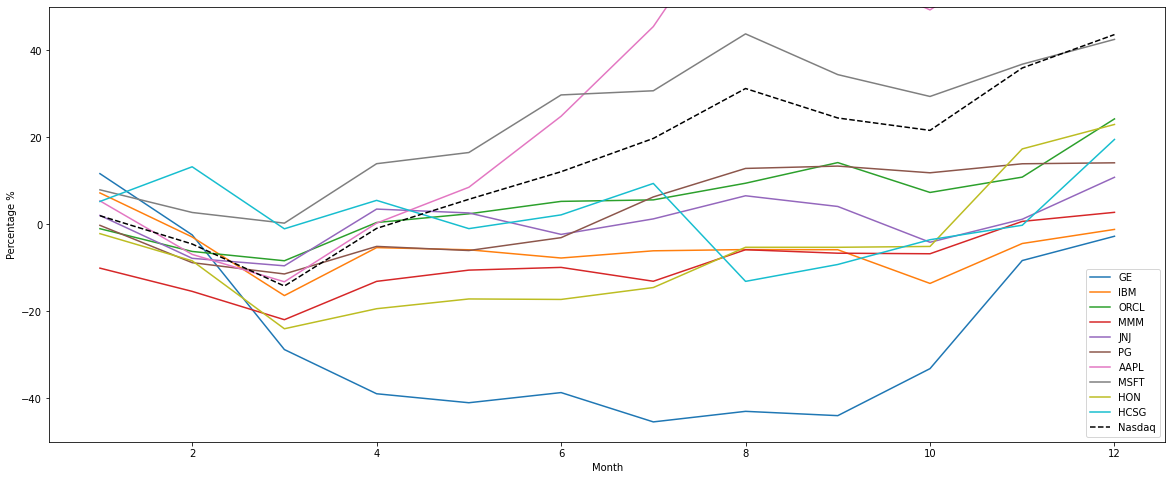

In [560]:
df_topic_selection = df_comp.sort_values('diversification')[:5000]

df_comp_pos_rate = df_topic_selection[df_topic_selection['company_relevance'] >= 0.2].copy()

df_comp_pos_rate = df_comp_pos_rate.pivot_table(index='filtered_names_match', columns='roberta', values='date', aggfunc='count', fill_value=0)
df_comp_pos_rate['Total'] = df_comp_pos_rate.sum(axis=1)
df_comp_pos_rate['POS_%'] = round(df_comp_pos_rate['POSITIVE'] / df_comp_pos_rate['Total'],2)

# Exclude companies with less than 10 mentions
df_comp_pos_rate = df_comp_pos_rate[df_comp_pos_rate['Total'] >= 25]
df_comp_pos_rate = df_comp_pos_rate.sort_values("POS_%", ascending=False)

tickers = [comp_ticker_dict[comp] for comp in list(df_comp_pos_rate.index)]
countries = [comp_country_dict[comp] for comp in list(df_comp_pos_rate.index)]
df_comp_pos_rate = df_comp_pos_rate.reset_index()
df_comp_pos_rate['ticker'] = tickers
df_comp_pos_rate['country'] = countries
    
df_comp_pos_rate_us = df_comp_pos_rate[df_comp_pos_rate['country'] == 'United States'].sort_values(['POS_%', 'Total'], ascending=False)
df_comp_pos_rate_us['listed'] = df_comp_pos_rate_us['ticker'].apply(is_listed)
df_comp_pos_rate_us = df_comp_pos_rate_us[df_comp_pos_rate_us['listed'] == 1]

topus = df_comp_pos_rate_us.sort_values(['POS_%', 'Total'], ascending=False).head(10)
display(topus)

fig, ax = plt.subplots(figsize=(20,8))
for ticker in topus['ticker']:
    stock_mvmt_temp = stock_final.loc[ticker].pct_change()[1:13]
    stock_mvmt_temp = ((stock_mvmt_temp + 1).cumprod() - 1) * 100
    stock_mvmt_temp.index = [1,2,3,4,5,6,7,8,9,10,11,12]
    plt.plot(stock_mvmt_temp, label=ticker)

plt.plot('Nasdaq', data=index_mvmt_analysis_cum * 100, label='Nasdaq', ls='--', color='black')
plt.legend()
plt.xlabel("Month")
plt.ylim(-50,50)
plt.ylabel("Percentage %")
plt.title("")
plt.show()

# Domain

In [88]:
df_combined['domain'].value_counts()

finance.yahoo      91304
marketscreener     77255
express            44938
reuters            23856
cnbc               20962
                   ...  
instyle               34
altassets             22
emerj                 20
just-auto              9
businessinsider        3
Name: domain, Length: 66, dtype: int64

<AxesSubplot:xlabel='domain'>

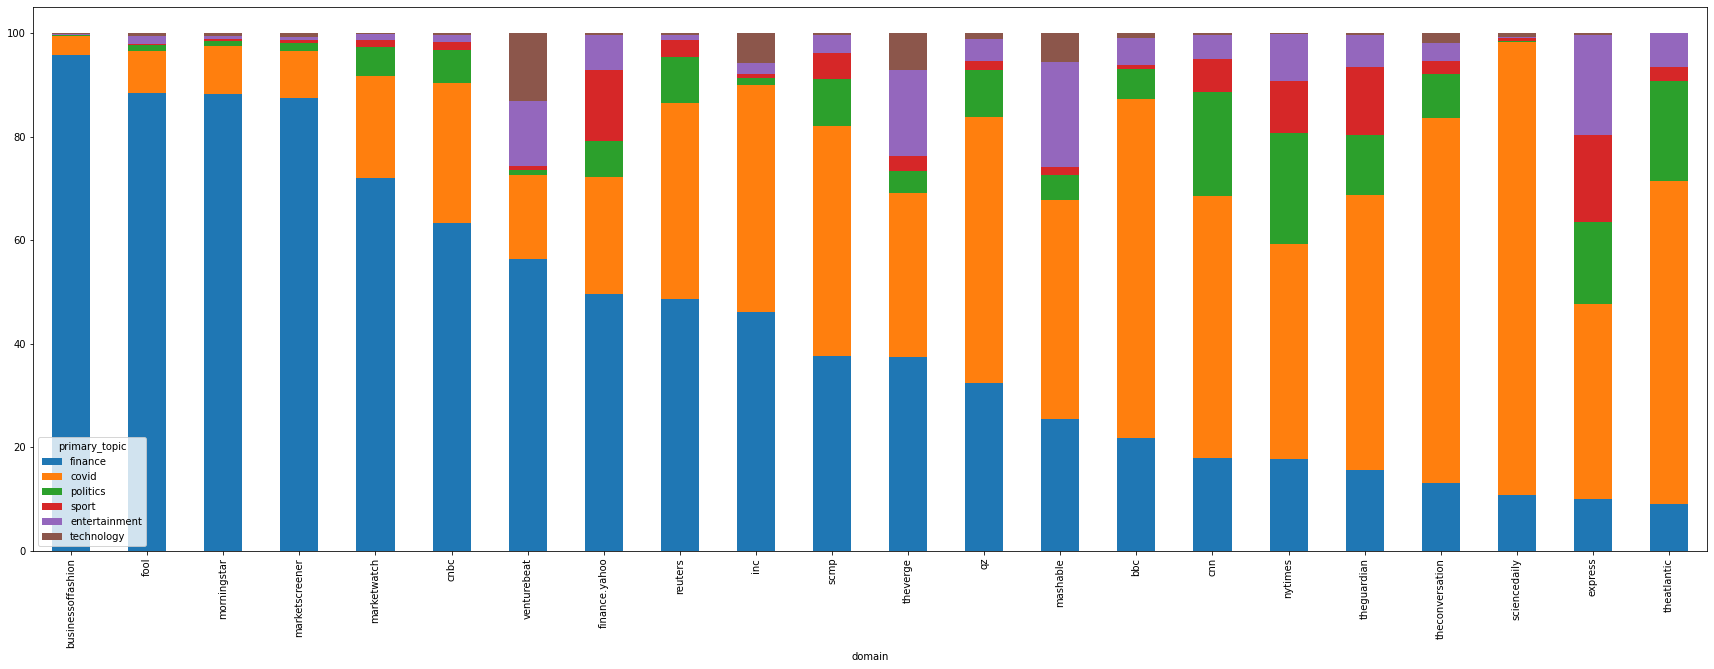

In [89]:
df_domain_chart = df_combined.pivot_table(index=['domain'], columns=['primary_topic'], values='date', aggfunc='count', fill_value=0)
num_articles_mask = df_domain_chart.sum(axis=1) > 1000
df_domain_chart = df_domain_chart[num_articles_mask]
df_domain_chart = df_domain_chart[['finance', 'covid', 'politics', 'sport', 'entertainment', 'technology']]
df_domain_chart = df_domain_chart.div(df_domain_chart.sum(axis=1), axis=0).multiply(100)
df_domain_chart = df_domain_chart.sort_values(by="finance", ascending=False)
df_domain_chart
df_domain_chart.plot.bar(stacked=True, figsize = (30,10))

<AxesSubplot:xlabel='domain'>

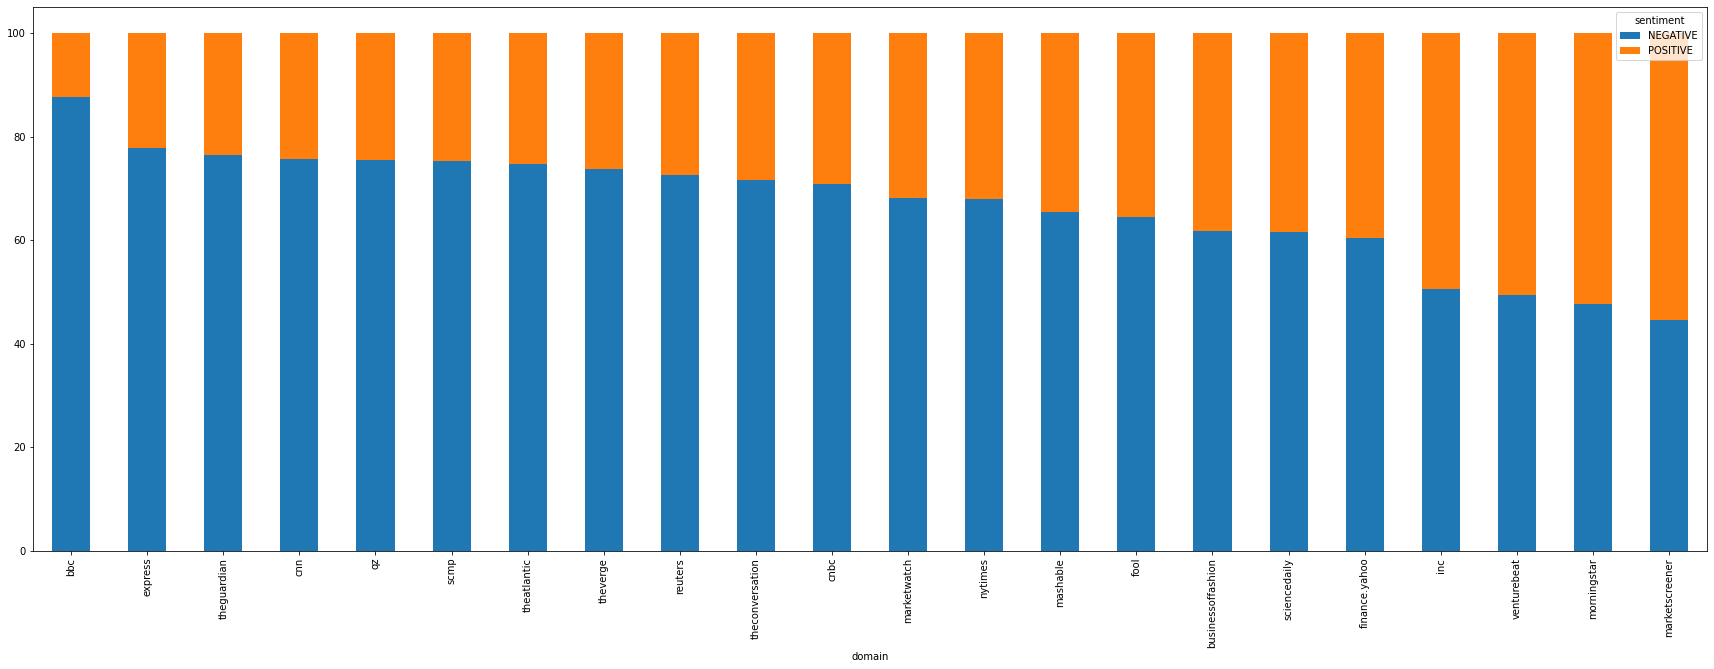

In [90]:
df_domain_chart = df_combined[df_combined['primary_topic'] == 'finance']
df_domain_chart = df_combined.pivot_table(index=['domain'], columns=['sentiment'], values='date', aggfunc='count', fill_value=0)
num_articles_mask = df_domain_chart.sum(axis=1) > 1000
df_domain_chart = df_domain_chart[num_articles_mask]
df_domain_chart = df_domain_chart.div(df_domain_chart.sum(axis=1), axis=0).multiply(100)
df_domain_chart = df_domain_chart.sort_values(by="NEGATIVE", ascending=False)
df_domain_chart.plot.bar(stacked=True, figsize = (30,10))

# End

In [68]:
df_combined[df_combined['content_processed'].str.contains('telehealth')]

author       date  \
6375                                                  NaN 2020-02-20   
7495                                    Josh Nathan-Kazis 2020-02-25   
7627           Eliott C. McLaughlin and Steve Almasy, CNN 2020-02-25   
7706    Berkeley Lovelace Jr.@BerkeleyJrWilliam Feuer@... 2020-02-25   
7773                                 Megan Thielking,STAT 2020-02-25   
...                                                   ...        ...   
367497                                                NaN 2020-12-28   
368165                                                NaN 2020-12-30   
368296                                       Paul Brandus 2020-12-30   
368659                                           Evie Liu 2020-12-31   
368909                                                NaN 2020-12-31   

                    domain                                              title  \
6375         finance.yahoo  Coronavirus' biggest winners: Tech providers i...   
7495           marketwatch  Coronavirus Will Spread Within the U.S., CDC O...   
7627                   cnn  CDC official warns Americans it's not a questi...   
7706                  cnbc  CDC outlines what closing schools, businesses ...   
7773    scientificamerican  CDC Expects Community Spread of Coronavirus in...   
...                    ...                                                ...   
367497      marketscreener  Rapid7 : Taking Inspiration from our Security ...   
368165      marketscreener  Chief Data Analytics Officer John Kahan: Thank...   
368296         marketwatch  Social Security and Medicare: Key things to kn...   
368659         marketwatch  Active, ESG, and Thematic ETFs Were 2020’s Big...   
368909      marketscreener  StageZero Life Sciences : Announces Appointmen...   

                                                      url  \
6375    https://finance.yahoo.com/news/technology-use-...   
7495    https://www.marketwatch.com/articles/coronavir...   
7627    https://www.cnn.com/2020/02/25/health/coronavi...   
7706    https://www.cnbc.com/2020/02/25/cdc-outlines-w...   
7773    https://www.scientificamerican.com/article/cdc...   
...                                                   ...   
367497  https://www.marketscreener.com/quote/stock/RAP...   
368165  https://www.marketscreener.com/quote/stock/MIC...   
368296  https://www.marketwatch.com/story/social-secur...   
368659  https://www.marketwatch.com/articles/active-es...   
368909  https://www.marketscreener.com/quote/stock/STA...   

                                                  content topic_area  \
6375    The coronavirus outbreak is roiling China, but...   business   
7495    The CDC warned Tuesday that the novel coronavi...   business   
7627     One of the top officials at the Centers for D...    general   
7706    The Centers for Disease Control and Prevention...    finance   
7773    The Centers for Disease Control and Prevention...    science   
...                                                   ...        ...   
367497  Well, what a year it has been. I won't waste y...   business   
368165  Just over a year and a half ago, I wrote about...   business   
368296  Now that a new year is here—good riddance to 2...   business   
368659  Amid everything else, a new market cliché emer...   business   
368909  TORONTO, ON / ACCESSWIRE / December 31, 2020 /...   business   

                                        content_processed distilbert  \
6375    coronavirus outbreak roiling china startup tec...   POSITIVE   
7495    cdc warned tuesday novel coronavirus spread yo...   NEGATIVE   
7627    officials centers disease control prevention w...   NEGATIVE   
7706    centers disease control prevention stepped tue...   NEGATIVE   
7773    centers disease control prevention tuesday war...   NEGATIVE   
...                                                   ...        ...   
367497  year waste time recapping difficulties offered...   POSITIVE   
368165  year half ago wrote broadband g